In [13]:
#pip install scikit-learn

In [14]:
#pip install tqdm

In [15]:
#pip install jax

In [16]:
#pip install --upgrade jupyter

In [17]:
#pip install --upgrade ipywidgets

In [18]:
#pip freeze > requirements.txt

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn import tree
import sympy
from tqdm.notebook import tqdm

import SCRBenchmark.SRSDFeynman as srsdf
import SCRBenchmark.Constants.StringKeys as sk
from SCRBenchmark import create_dataset_from_sampling_objectives
from SCRBenchmark import Benchmark

In [20]:
constraint_id =-1

def create_constraint(var_name, var_display_name, order_derivative, descriptor, derivative, sampling_space):
    global constraint_id
    constraint_id+=1
    return {
          sk.EQUATION_CONSTRAINTS_VAR_NAME_KEY: var_name,
          sk.EQUATION_CONSTRAINTS_VAR_DISPLAY_NAME_KEY:var_display_name,
          sk.EQUATION_CONSTRAINTS_ORDER_DERIVATIVE_KEY:order_derivative,
          sk.EQUATION_CONSTRAINTS_DESCRIPTOR_KEY: descriptor,
          sk.EQUATION_CONSTRAINTS_DERIVATIVE_KEY: str(derivative),
          sk.EQUATION_CONSTRAINTS_SAMPLE_SPACE_KEY: sampling_space,
          sk.EQUATION_CONSTRAINTS_ID_KEY: constraint_id  
          }

def node_value(clf, node):
    if clf.tree_.value[node][0][0] == 1:
        return sk.EQUATION_CONSTRAINTS_DESCRIPTOR_MONOTONIC_DECREASING_CONSTRAINT
    if clf.tree_.value[node][0][1] == 1:
        return sk.EQUATION_CONSTRAINTS_DESCRIPTOR_MONOTONIC_INCREASING_CONSTRAINT
    return None

def to_constraint(clf, node, bounds):
    if clf.tree_.children_left[node] == -1:
        return [(bounds, node_value(clf, node))]
    bleft = bounds.copy()
    bright = bounds.copy()
    f = clf.tree_.feature[node]
    s = clf.tree_.threshold[node]
    bleft[f] = (bounds[f][0], s)
    bright[f] = (s, bounds[f][1])
    return [x for x in to_constraint(clf, clf.tree_.children_left[node], bleft)] + \
    [x for x in to_constraint(clf, clf.tree_.children_right[node], bright)]

def get_values_fast( eq, local_dict, xs):
    f = sympy.lambdify(local_dict, eq,"numpy")
    #calculate gradient per data point
    # gradients = np.array([ f(*row) for row in xs ])
    # speedup of 5:
    def l(x):
        return f(*x)
    return xs.apply(l,axis=1, raw = True)

def range_to_space(range, names):
    return [{'name':str(names[i]),
    'low': float(range[i][0]),
    'high': float(range[i][1])} 
    for i in range]

cstrings = []
res = dict()
for dictEntry in tqdm(srsdf.AllEquations):
    res[dictEntry] = dict()
    scr = Benchmark(srsdf.AllEquations[dictEntry], initialize_constraint_checking_datasets=False)
    varnames = scr.equation.get_var_names()#scr.equation.x
    vars = [(x,y.get_value_range()) for (x,y) in zip(varnames, scr.equation.sampling_objs)]
    CONSTRAINT_SAMPLING_SIZE = 10_000
    data = pd.DataFrame(create_dataset_from_sampling_objectives([ samp.to_uniform_sampling() for samp in scr.equation.sampling_objs], # 
                                                      scr.equation.sympy_eq, 
                                                      scr.equation.eq_func, 
                                                      scr.equation.check_if_valid, 
                                                      CONSTRAINT_SAMPLING_SIZE,
                                                      patience = CONSTRAINT_SAMPLING_SIZE), columns= varnames+["target"])
    f_primes = [(sympy.Derivative(scr.equation.sympy_eq, var,1).doit(),var.name, var_display_name, 1) 
                 for (var,var_display_name) 
                 in list(zip(scr.equation.x, scr.equation.get_var_names()))]
    f_primes = f_primes + [(sympy.Derivative(scr.equation.sympy_eq, var,2).doit(),var.name, var_display_name, 2) 
                 for (var,var_display_name) 
                 in list(zip(scr.equation.x, scr.equation.get_var_names()))]
    print(f_primes)
    constraints = []
    sampling_space = [{ 'name': str(var),
                         'low': float(obj[0]),
                         'high':float(obj[1])} 
                         for (var,obj) in vars]
    
    ranges = {i: (x[1][0],x[1][1]) for i, x in enumerate(vars)}
    for d, v, name,degree in f_primes:
        dname = f'{name}_{degree}'
        data[dname] = get_values_fast(d, scr.equation.x, data[varnames])
        tname = f'{name} {degree} sign'
        data[tname] = np.sign(data[dname])
        d1 = data[data[tname]!=0]
        classes = np.unique(d1[tname])
        if len(classes) == 0:
            res[dictEntry][tname] = 0
            constraints.append(create_constraint(v, name, degree, sk.EQUATION_CONSTRAINTS_DESCRIPTOR_CONSTANT_CONSTRAINT, d, sampling_space))
        elif len(classes) == 1:
            res[dictEntry][tname] = classes[0]
            ctype = sk.EQUATION_CONSTRAINTS_DESCRIPTOR_MONOTONIC_INCREASING_CONSTRAINT if classes[0] == 1 else sk.EQUATION_CONSTRAINTS_DESCRIPTOR_MONOTONIC_DECREASING_CONSTRAINT
            constraints.append(create_constraint(v, name, degree, ctype, d, sampling_space))
        else:
            clf = tree.DecisionTreeClassifier(max_depth=2)
            clf = clf.fit(d1[varnames], d1[tname]) # clf.fit(data[varnames], data[tname])
            if clf.score(d1[varnames], d1[tname])< 1-1/CONSTRAINT_SAMPLING_SIZE:
                res[dictEntry][tname] = None
            else:
                res[dictEntry][tname] = (clf,varnames)
                for x in to_constraint(clf, 0, ranges):
                    s = range_to_space(x[0], scr.equation.x)
                    constraints.append(create_constraint(v, name, degree, x[1], d, s))
    cstrings.append(str({sk.EQUATION_EQUATION_NAME_KEY:scr.equation.get_eq_name(),
        sk.EQUATION_CONSTRAINTS_CONSTRAINTS_KEY: constraints}).replace('\'','\"'))

  0%|          | 0/120 [00:00<?, ?it/s]

[(-sqrt(2)*x0*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**3), 'x0', 'theta', 1), (sqrt(2)*x0**2*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**4) - sqrt(2)*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**2), 'x1', 'sigma', 1), (sqrt(2)*(x0**2/x1**2 - 1)*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**3), 'x0', 'theta', 2), (sqrt(2)*(x0**2*(x0**2/x1**2 - 3)/(2*x1**2) - x0**2/x1**2 + 1)*exp(-x0**2/(2*x1**2))/(sqrt(pi)*x1**3), 'x1', 'sigma', 2)]
[(-sqrt(2)*x0*exp(-x0**2/2)/(2*sqrt(pi)), 'x0', 'theta', 1), (sqrt(2)*(x0**2 - 1)*exp(-x0**2/2)/(2*sqrt(pi)), 'x0', 'theta', 2)]
[(-sqrt(2)*(2*x0 - 2*x1)*exp(-(x0 - x1)**2/(2*x2**2))/(4*sqrt(pi)*x2**2), 'x0', 'theta', 1), (-sqrt(2)*(-2*x0 + 2*x1)*exp(-(x0 - x1)**2/(2*x2**2))/(4*sqrt(pi)*x2**2), 'x1', 'theta1', 1), (sqrt(2)*(x0 - x1)**2*exp(-(x0 - x1)**2/(2*x2**2))/(2*sqrt(pi)*x2**3), 'x2', 'sigma', 1), (-sqrt(2)*(1 - (x0 - x1)**2/x2**2)*exp(-(x0 - x1)**2/(2*x2**2))/(2*sqrt(pi)*x2**2), 'x0', 'theta', 2), (-sqrt(2)*(1 - (x0 - x1)**2/x2**2)*exp(-(x0 - x1)**2/(2*x2**2))/(2*sqrt(pi)*x2*

In [21]:
with open("generate/feynman_srsdf_constraint_info_bernhard.json", "w") as text_file:
  text_file.write('[')
  #iterate over all equations
  text_file.write(',\n'.join(cstrings))
  text_file.write(']')

120 16


  0%|          | 0/120 [00:00<?, ?it/s]

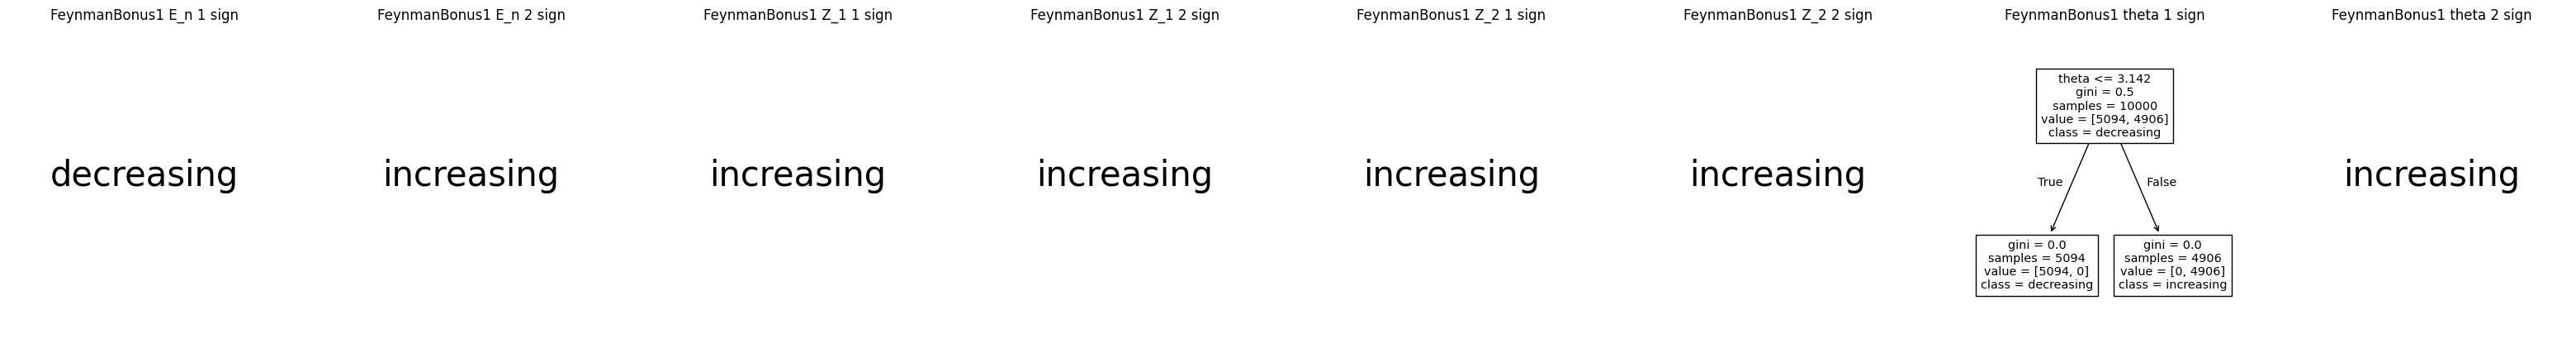

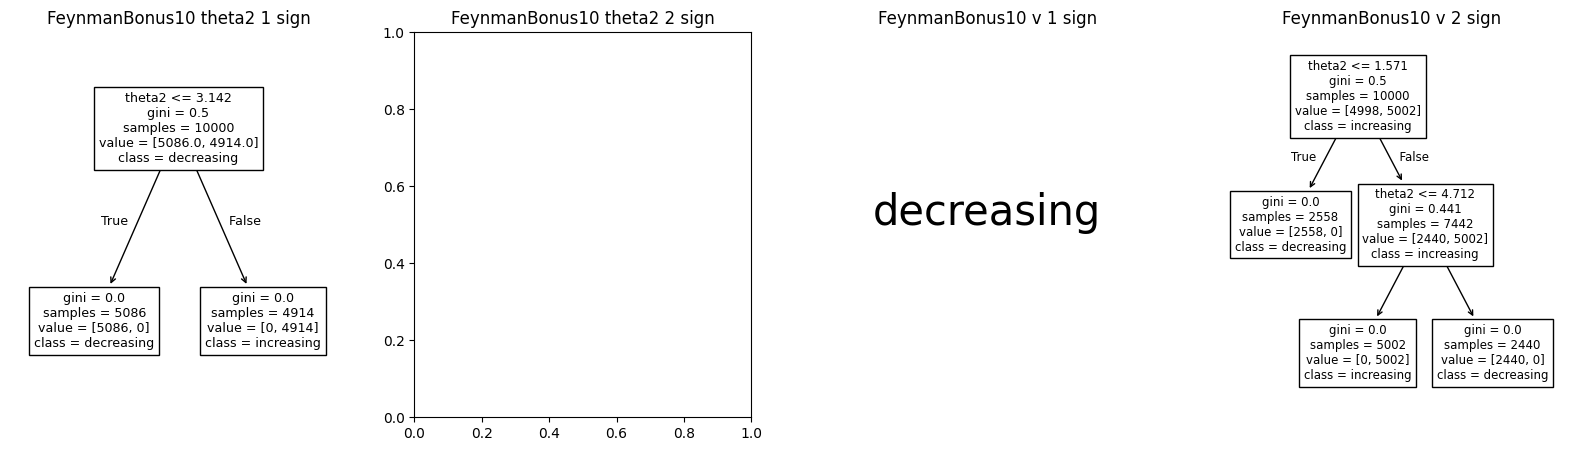

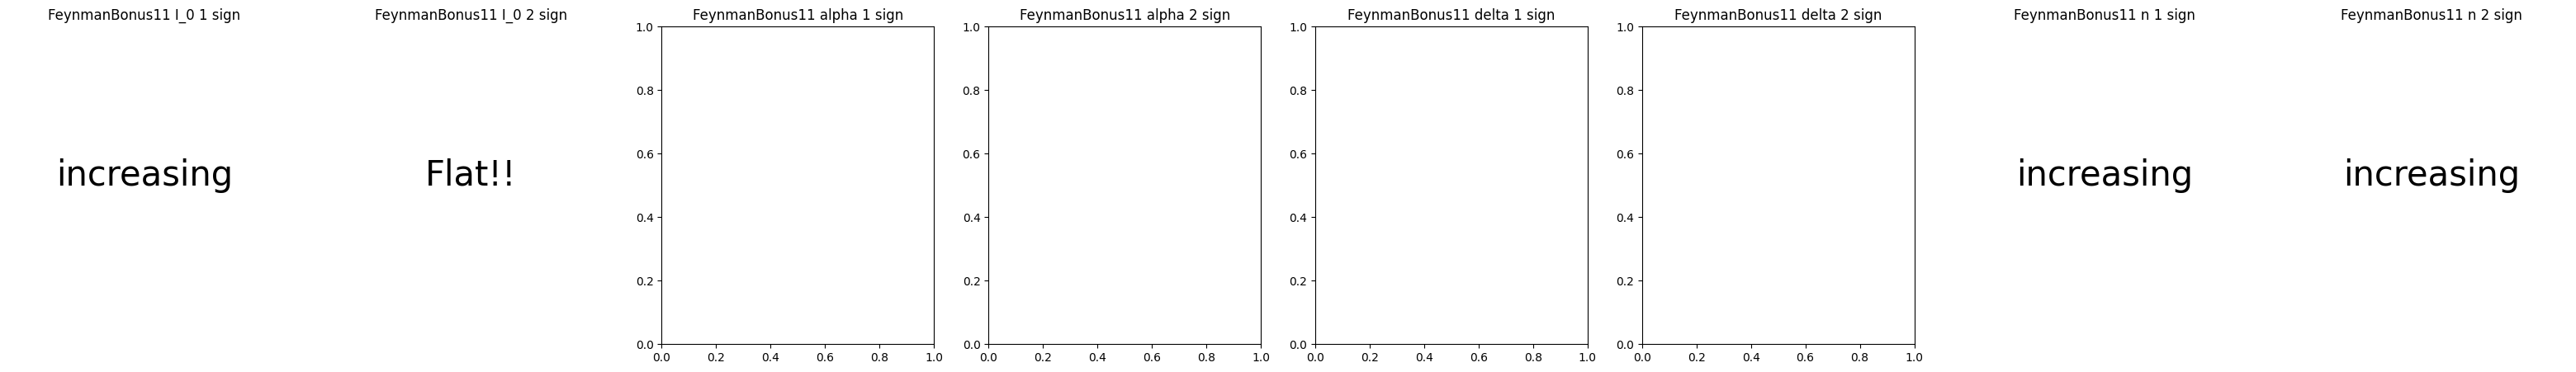

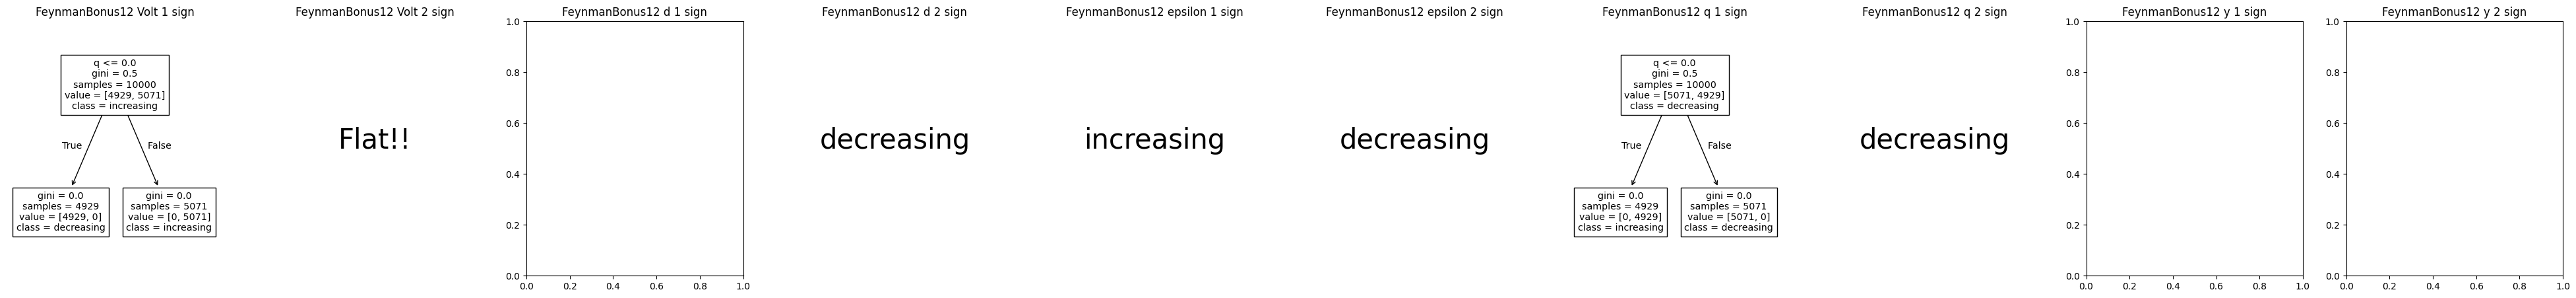

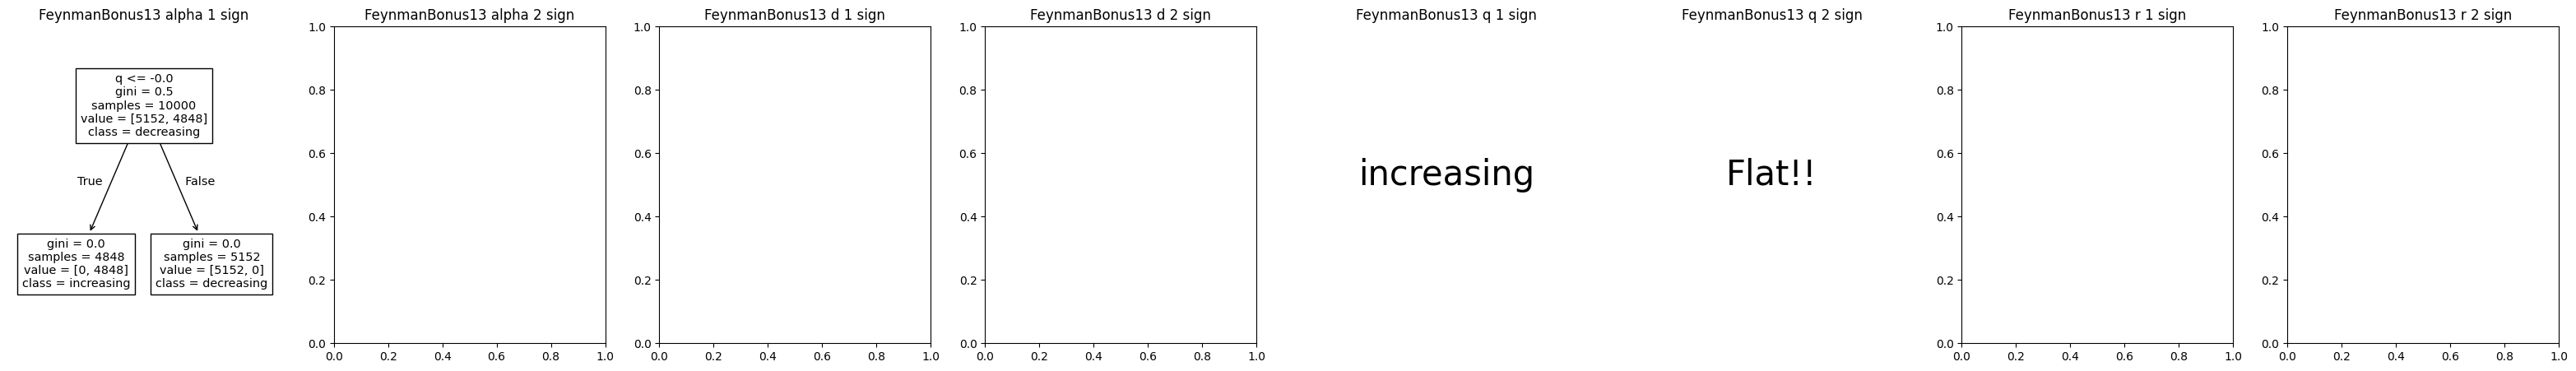

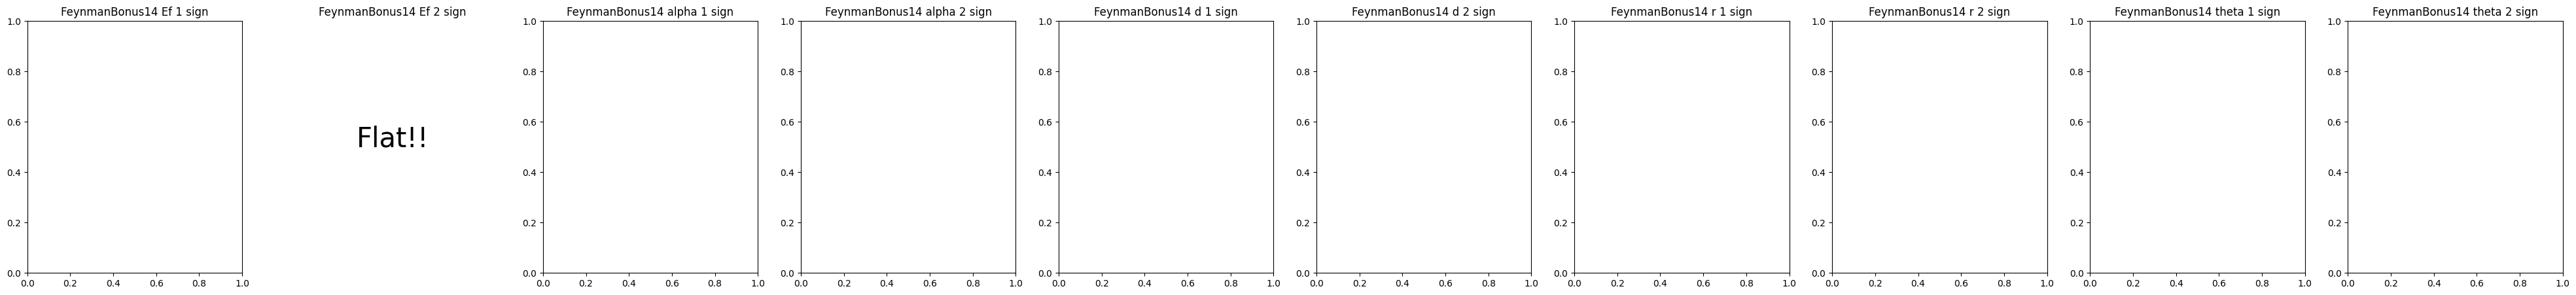

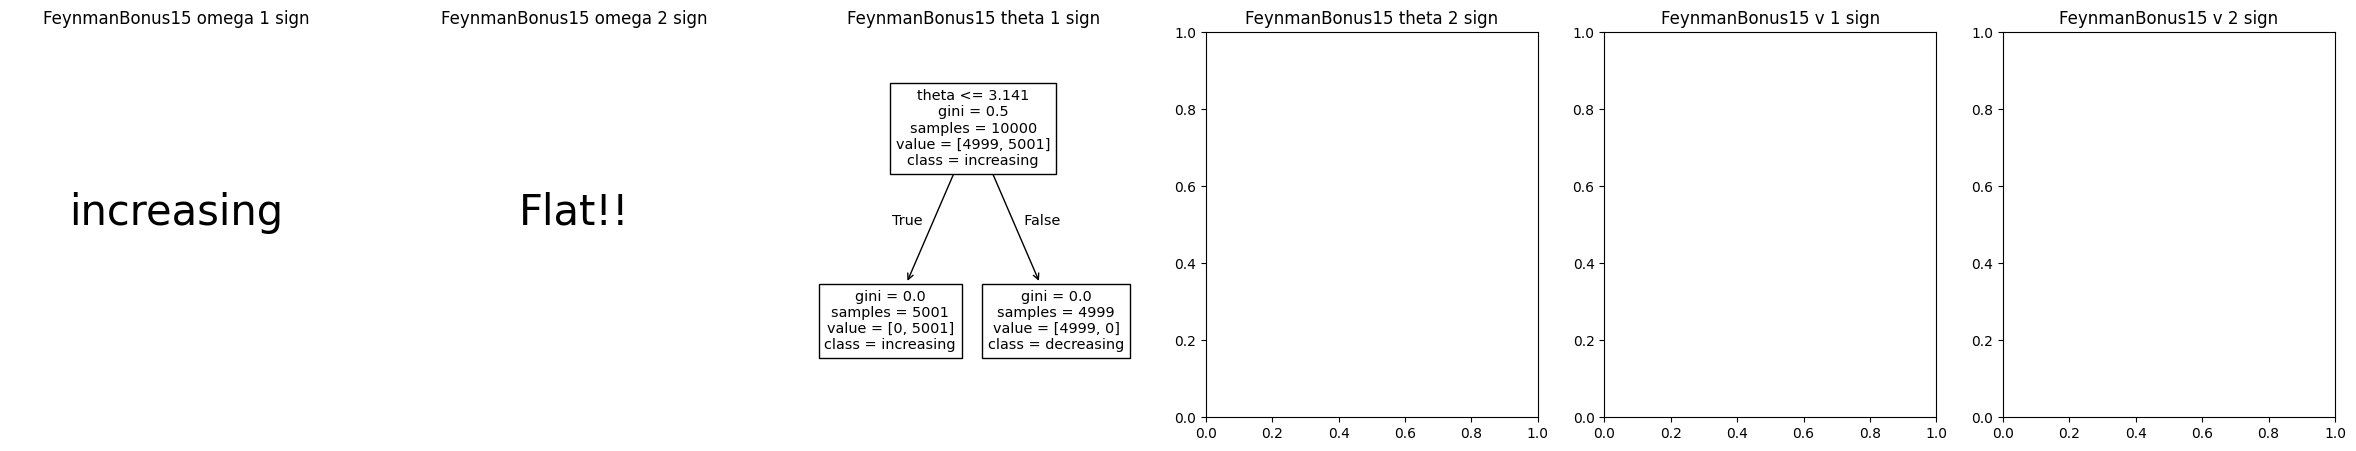

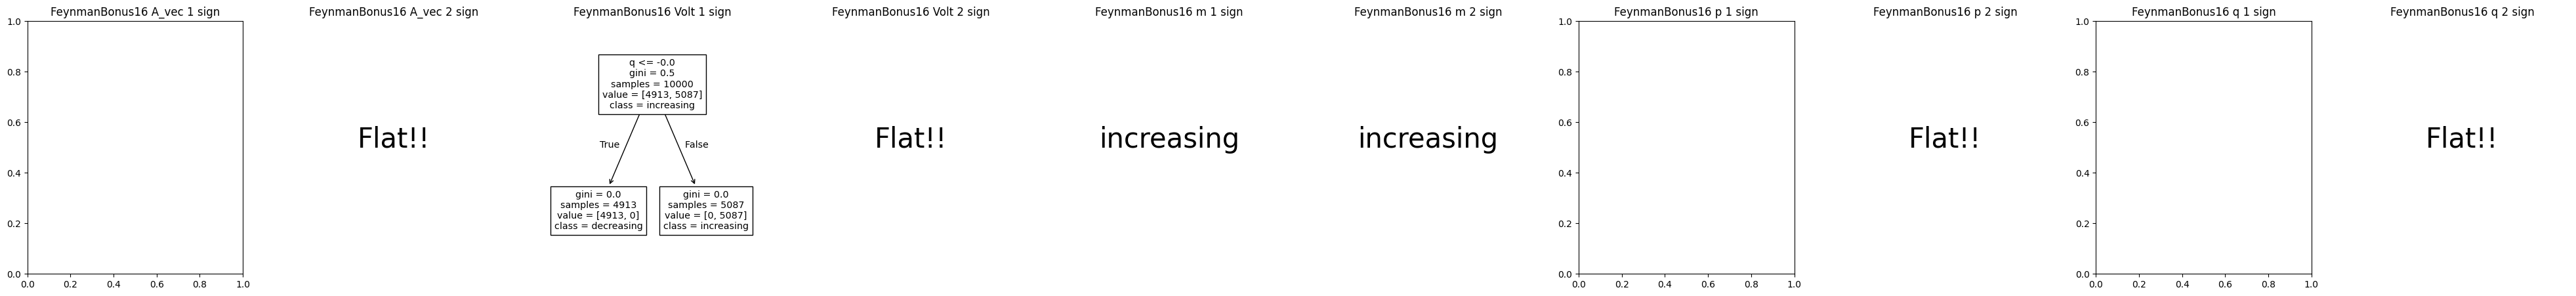

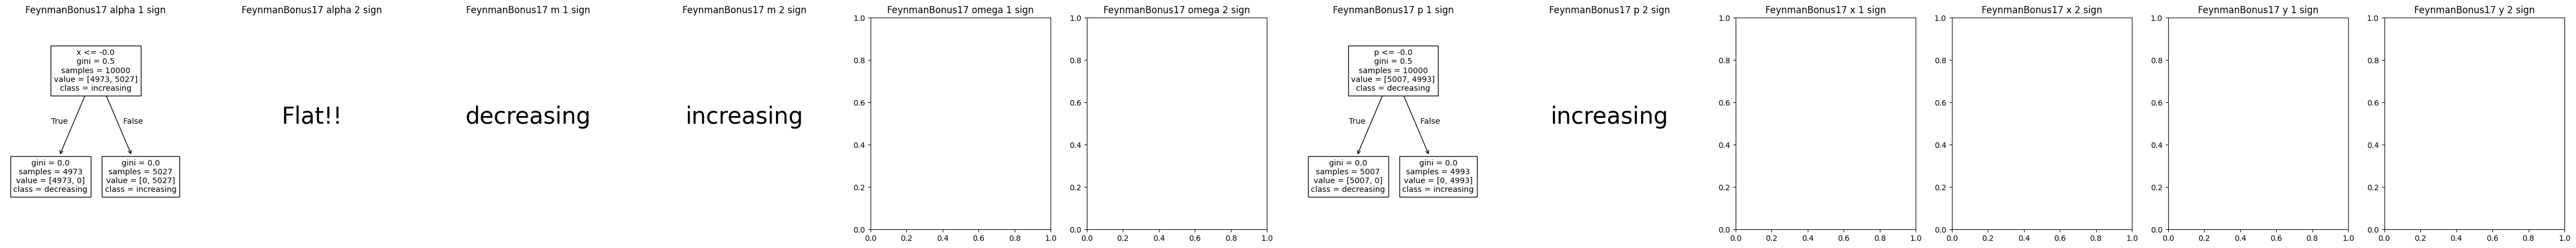

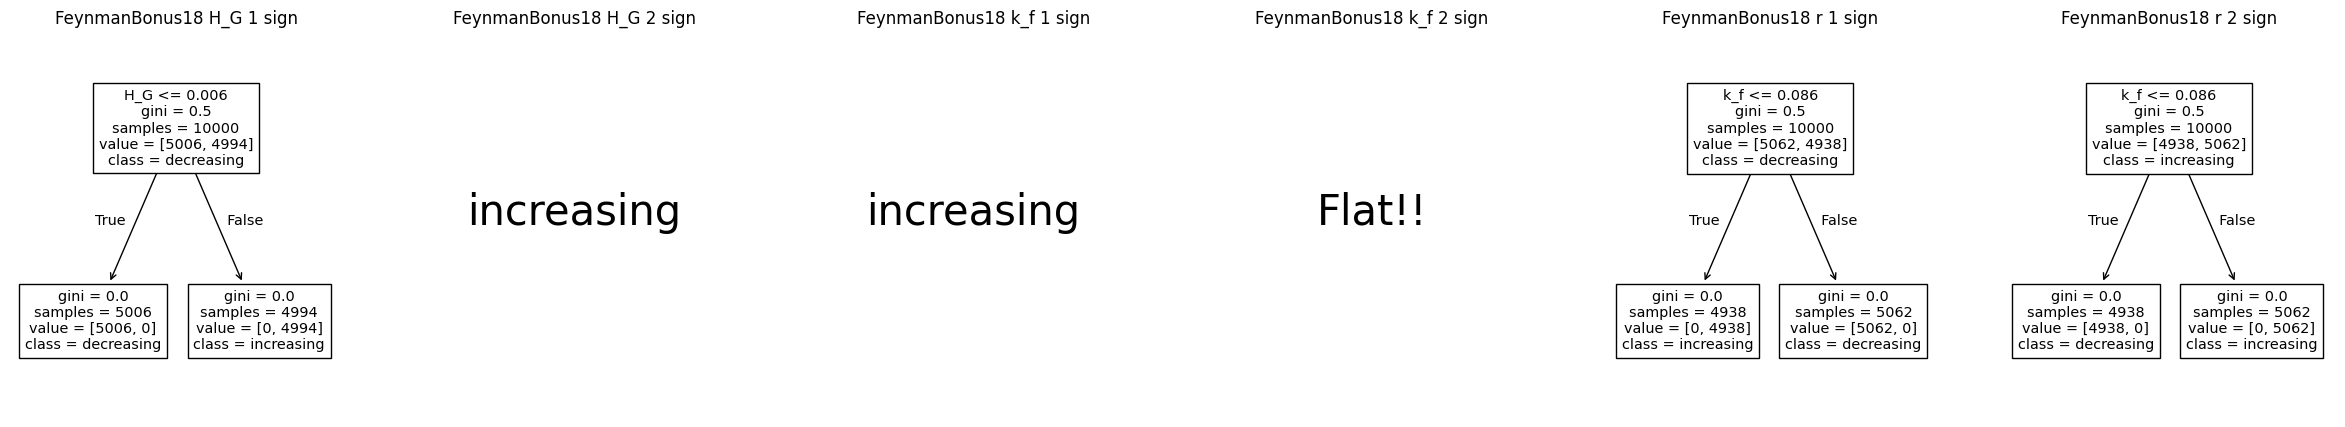

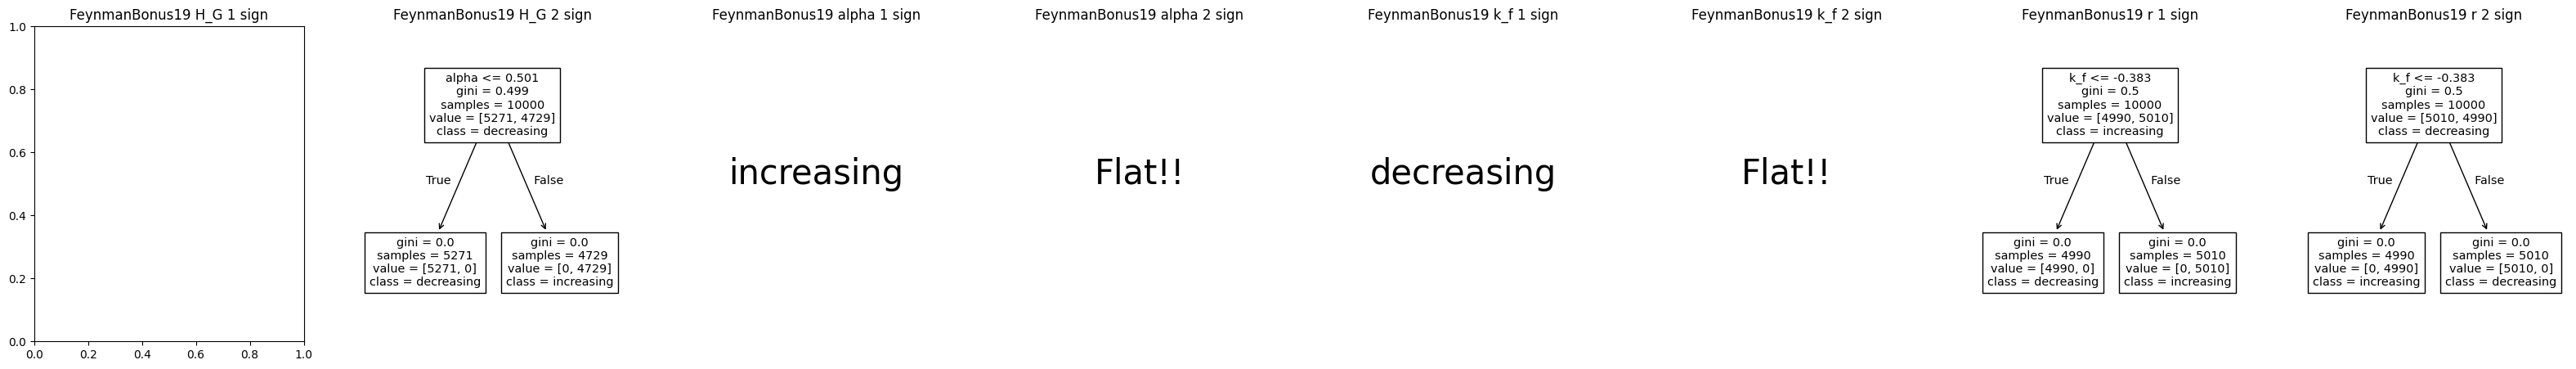

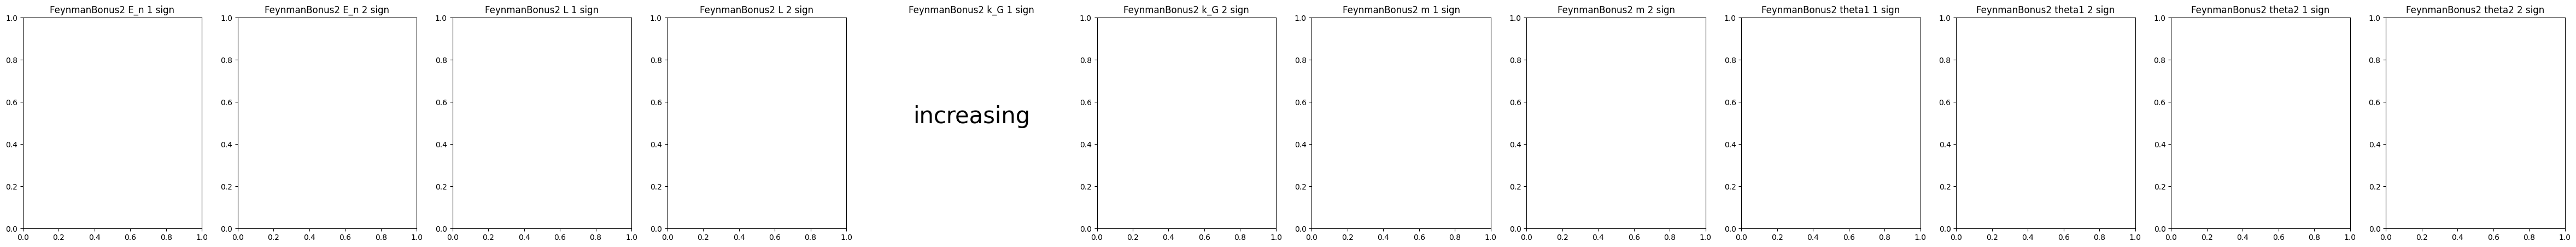

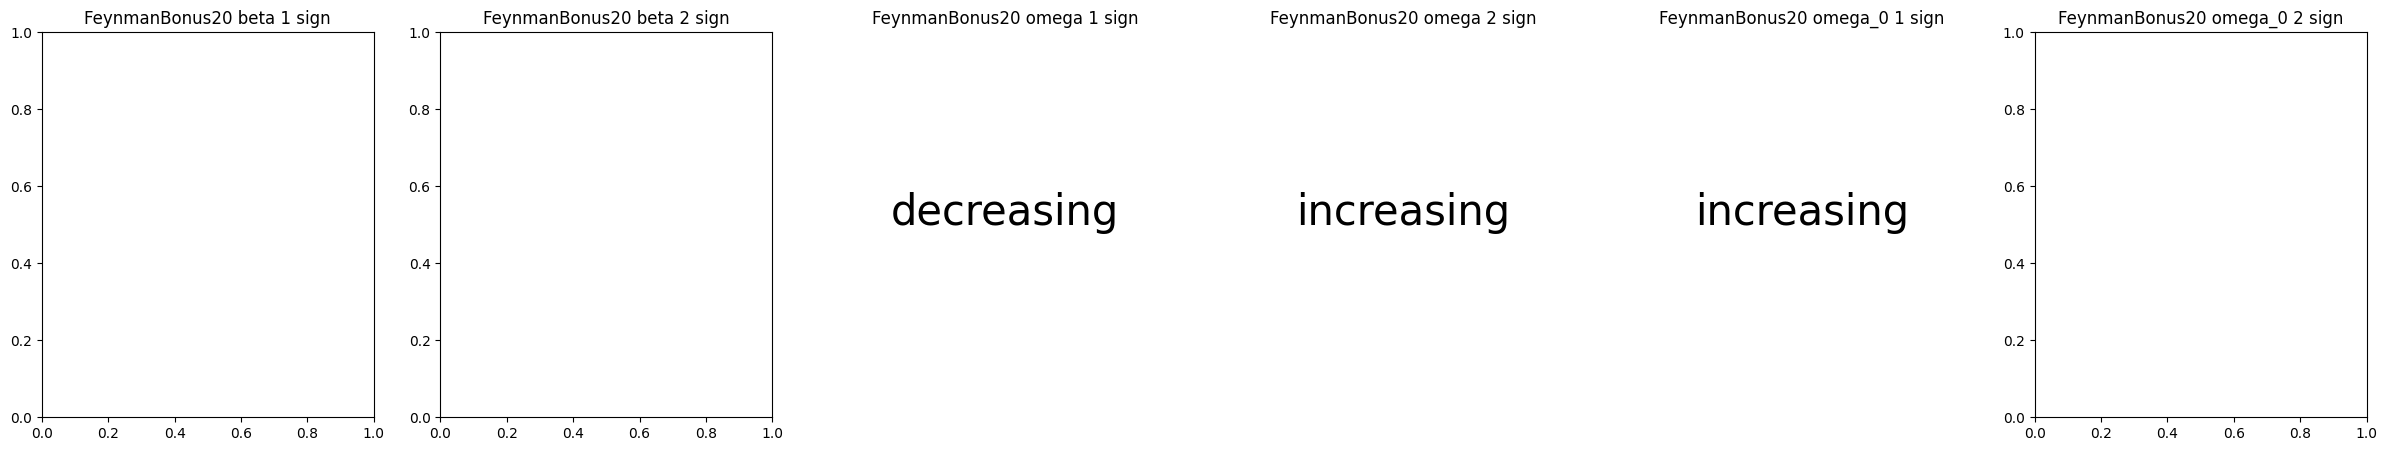

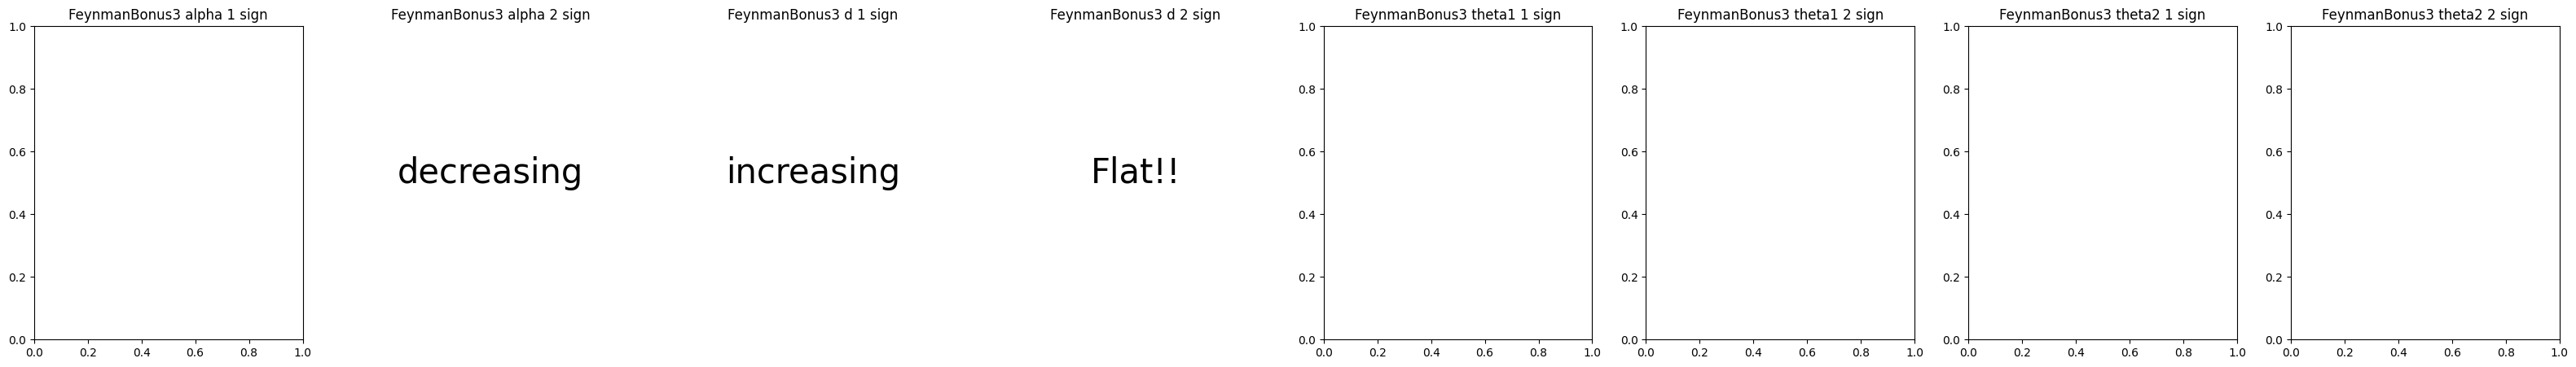

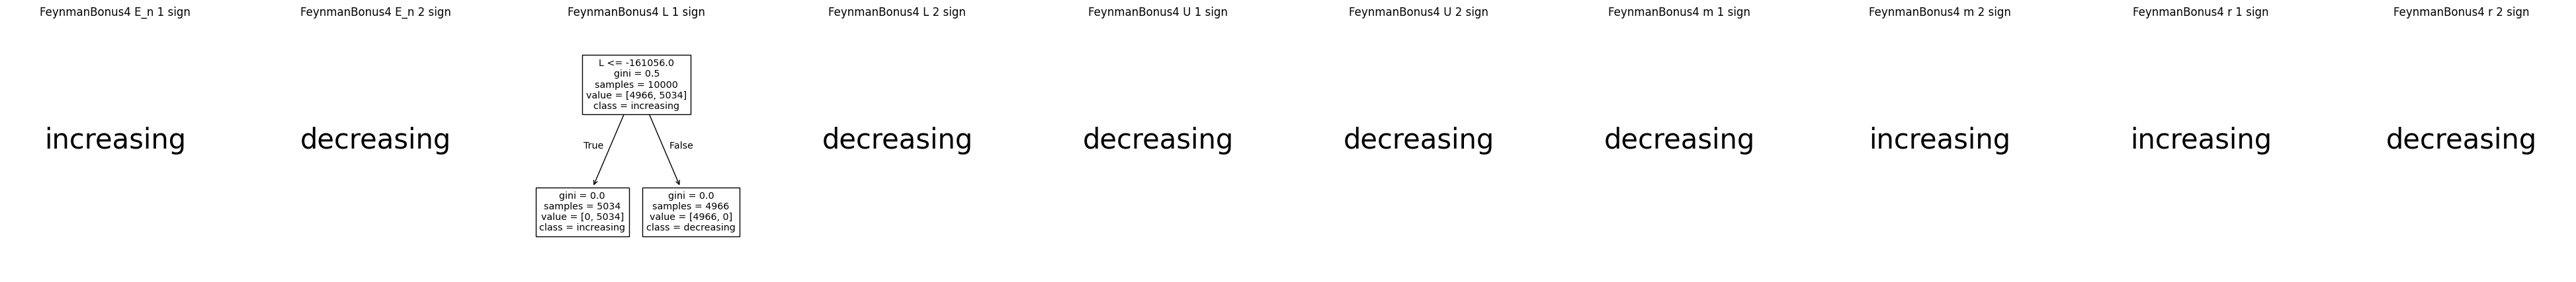

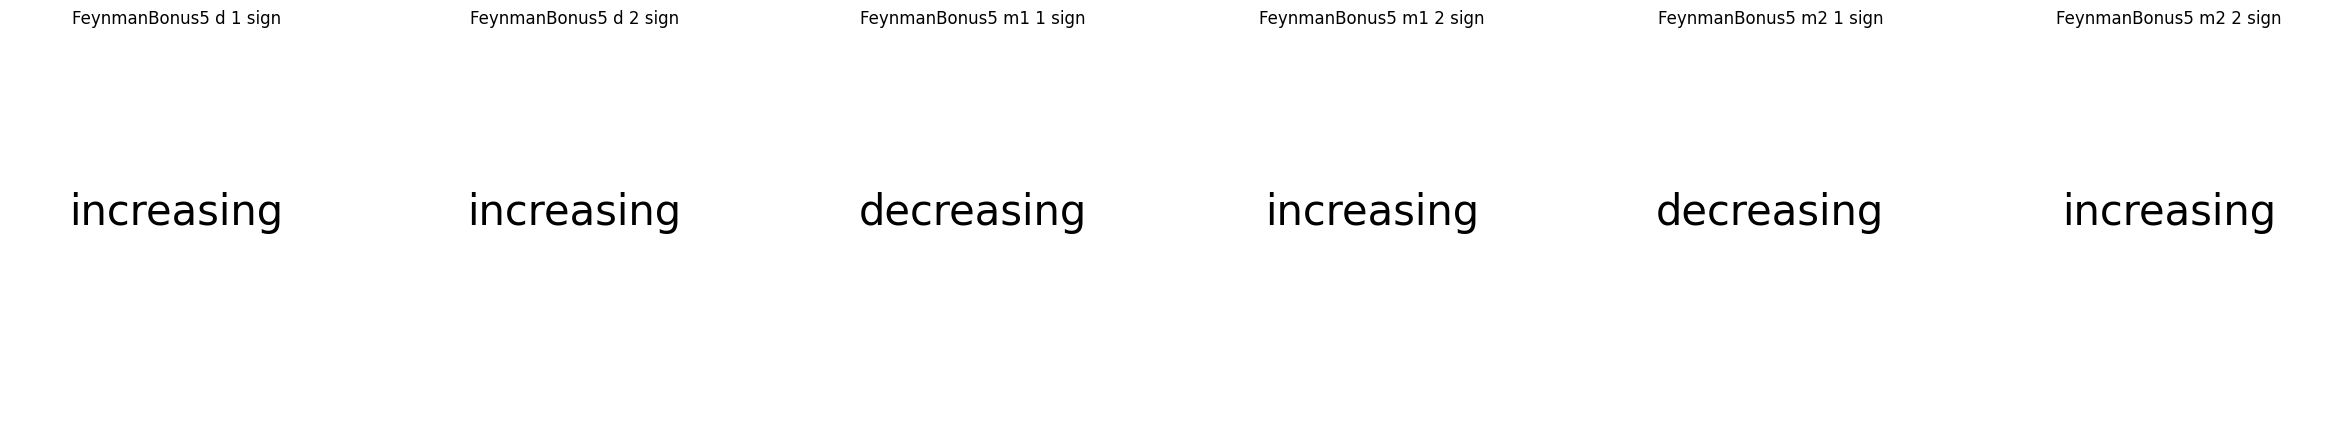

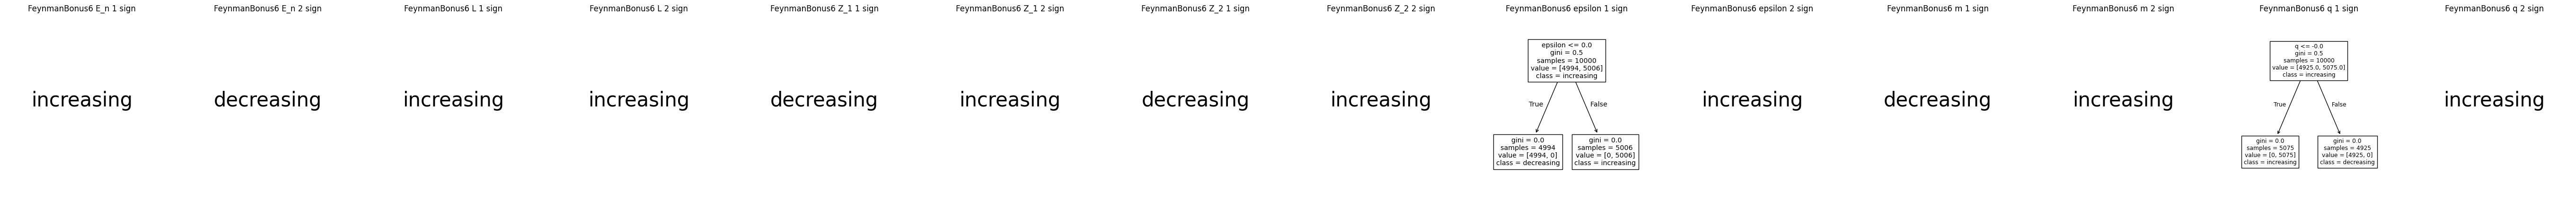

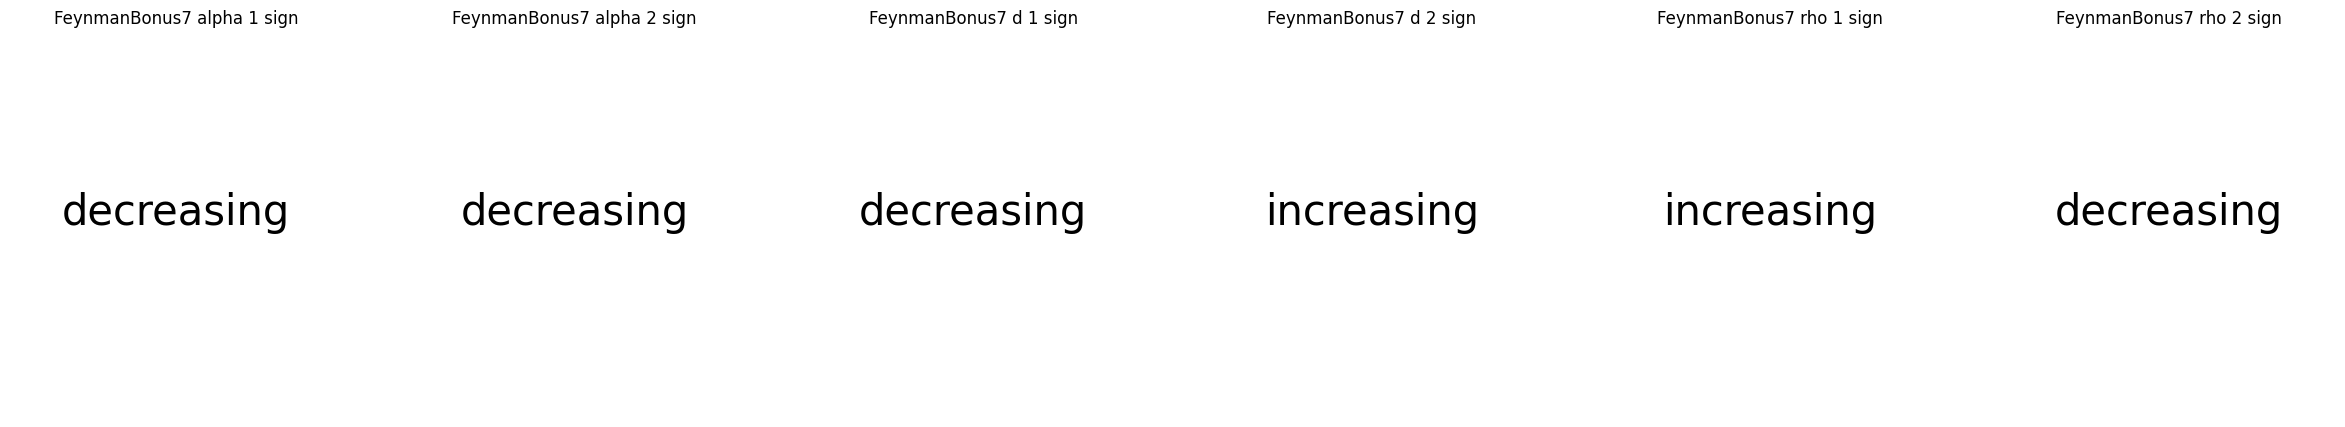

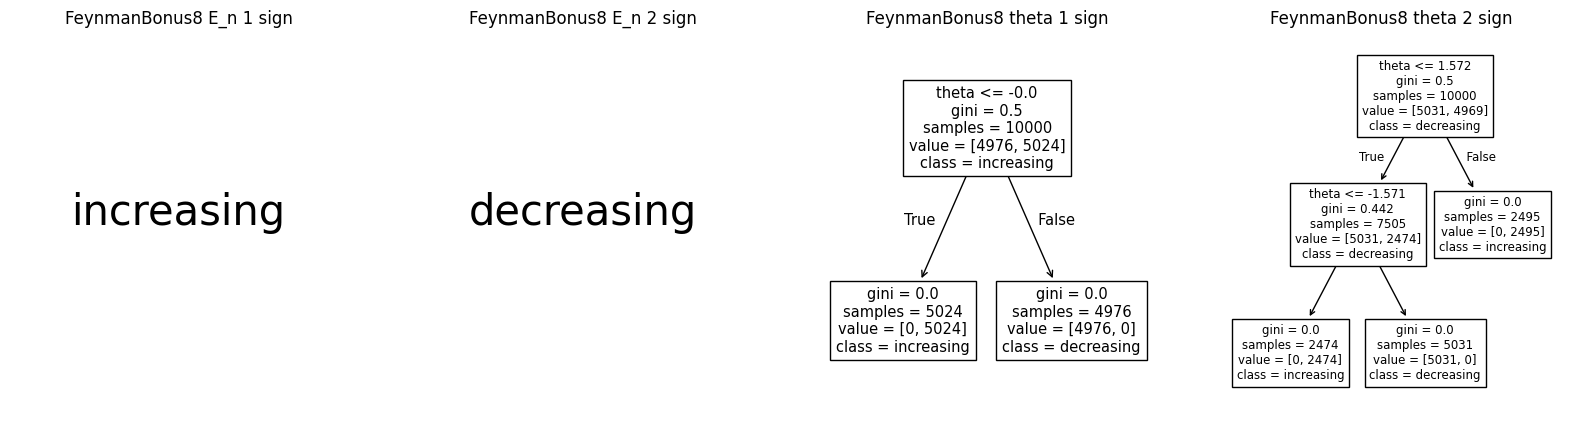

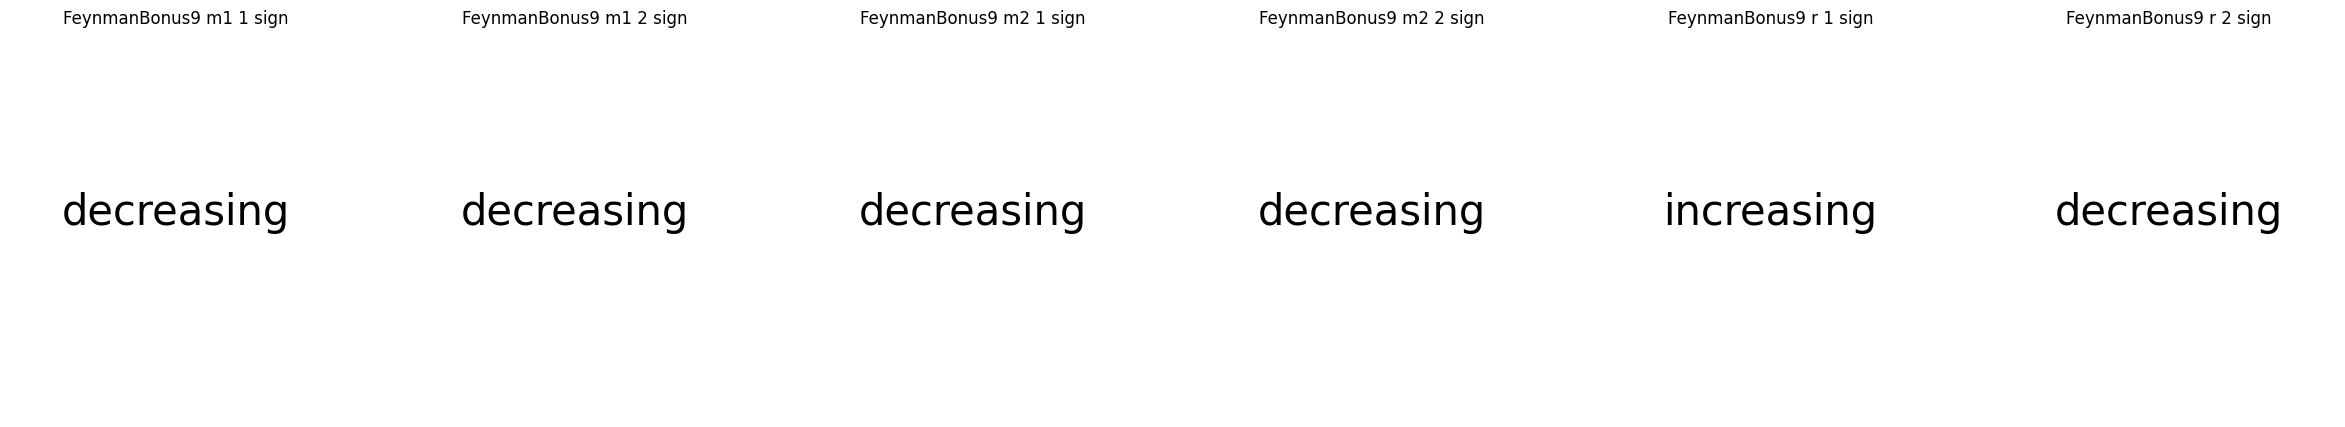

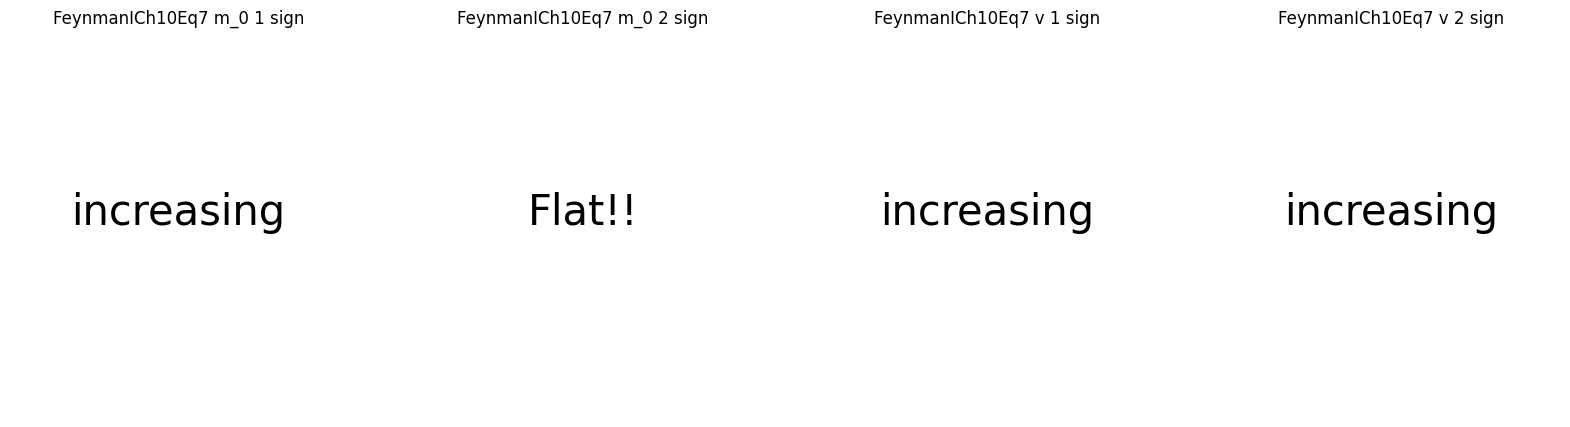

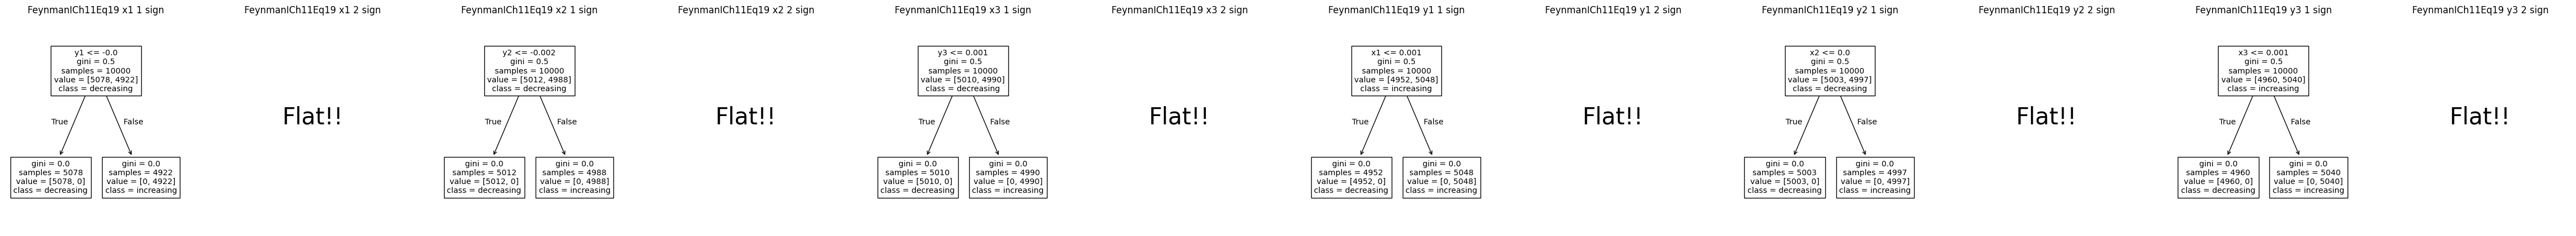

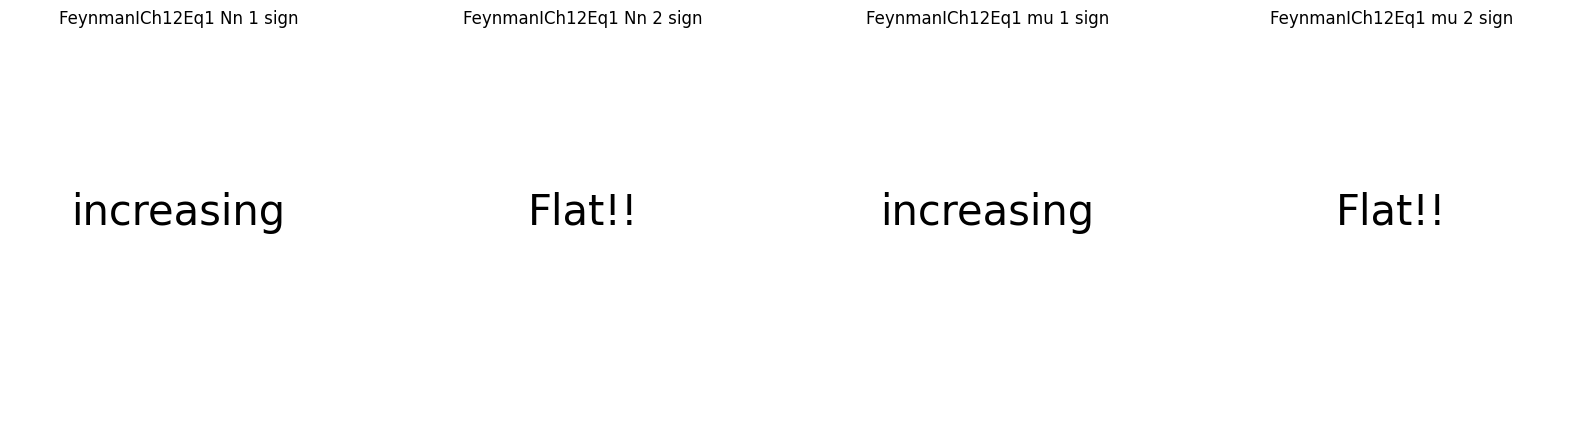

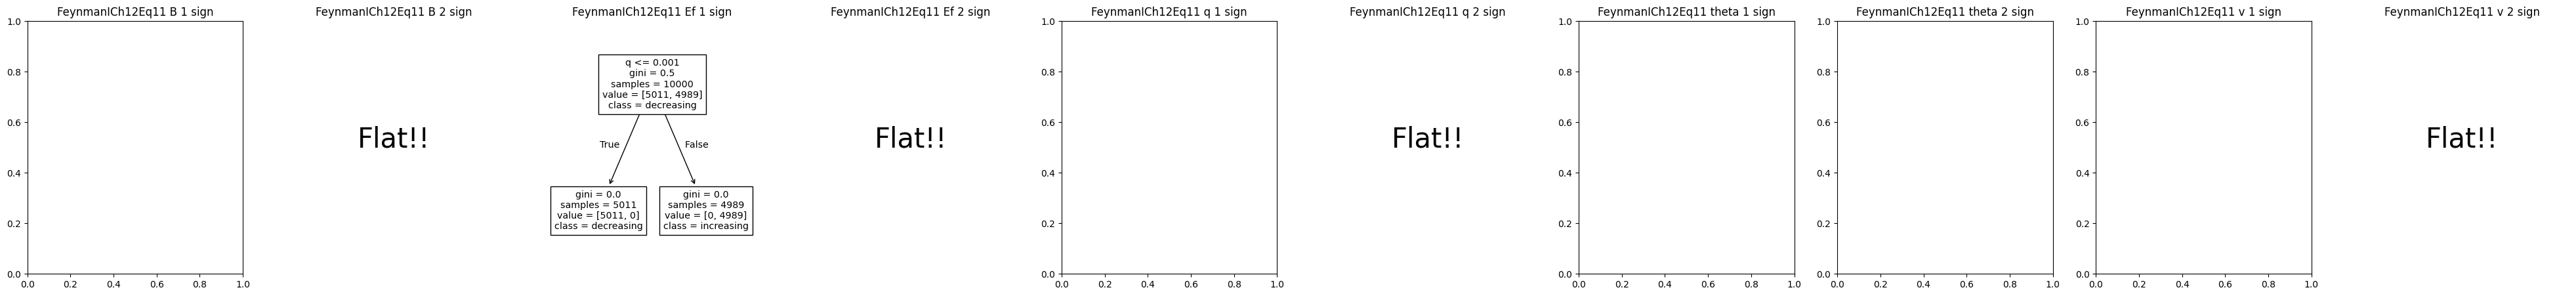

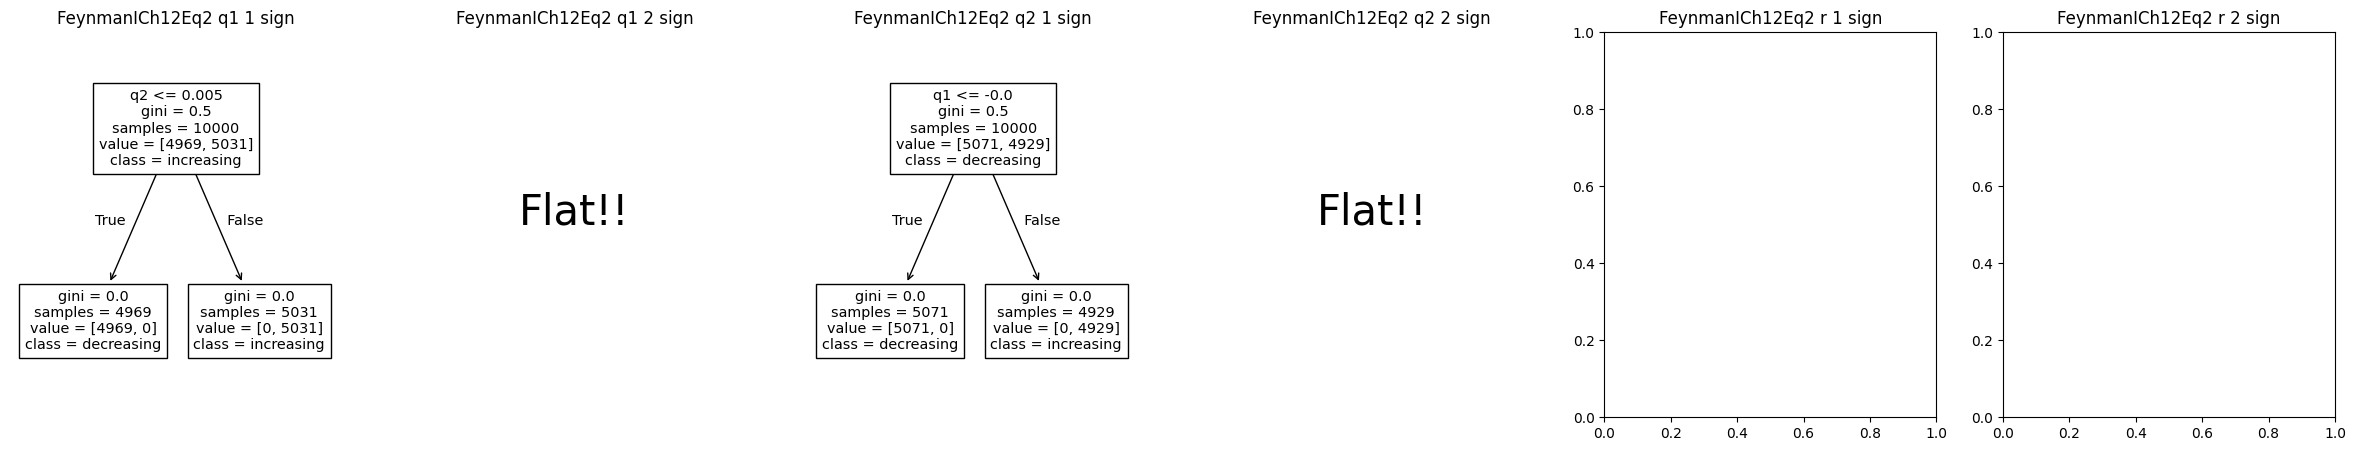

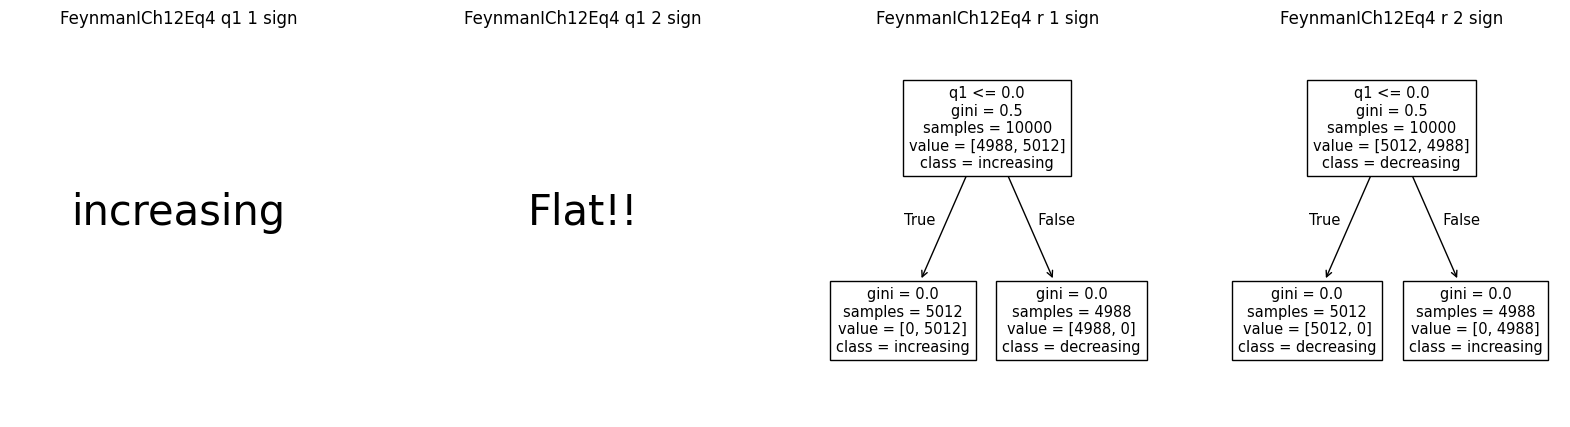

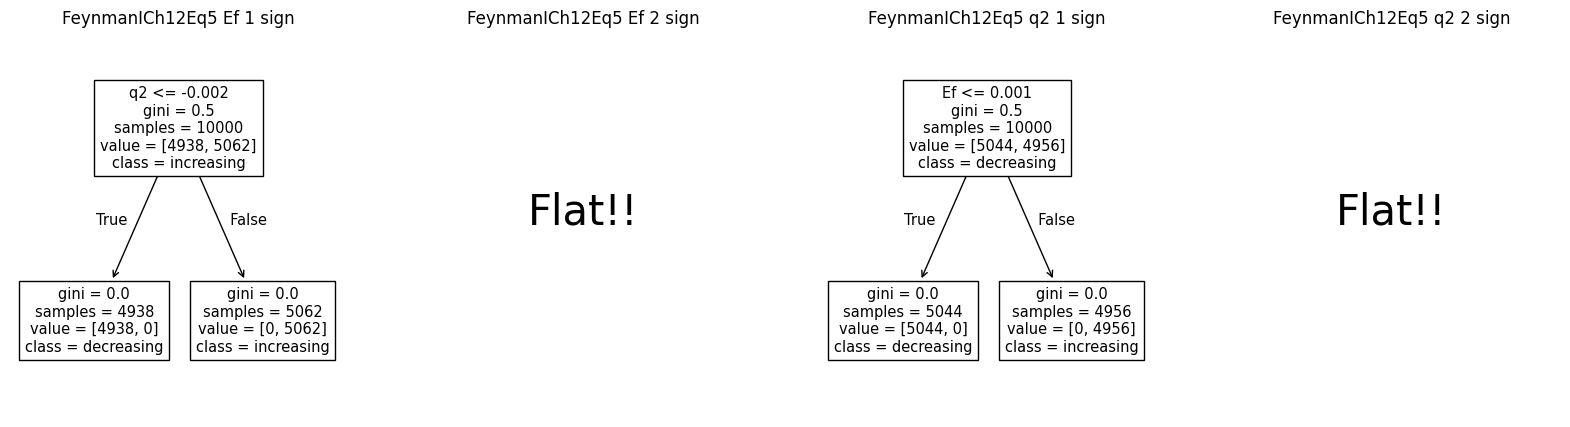

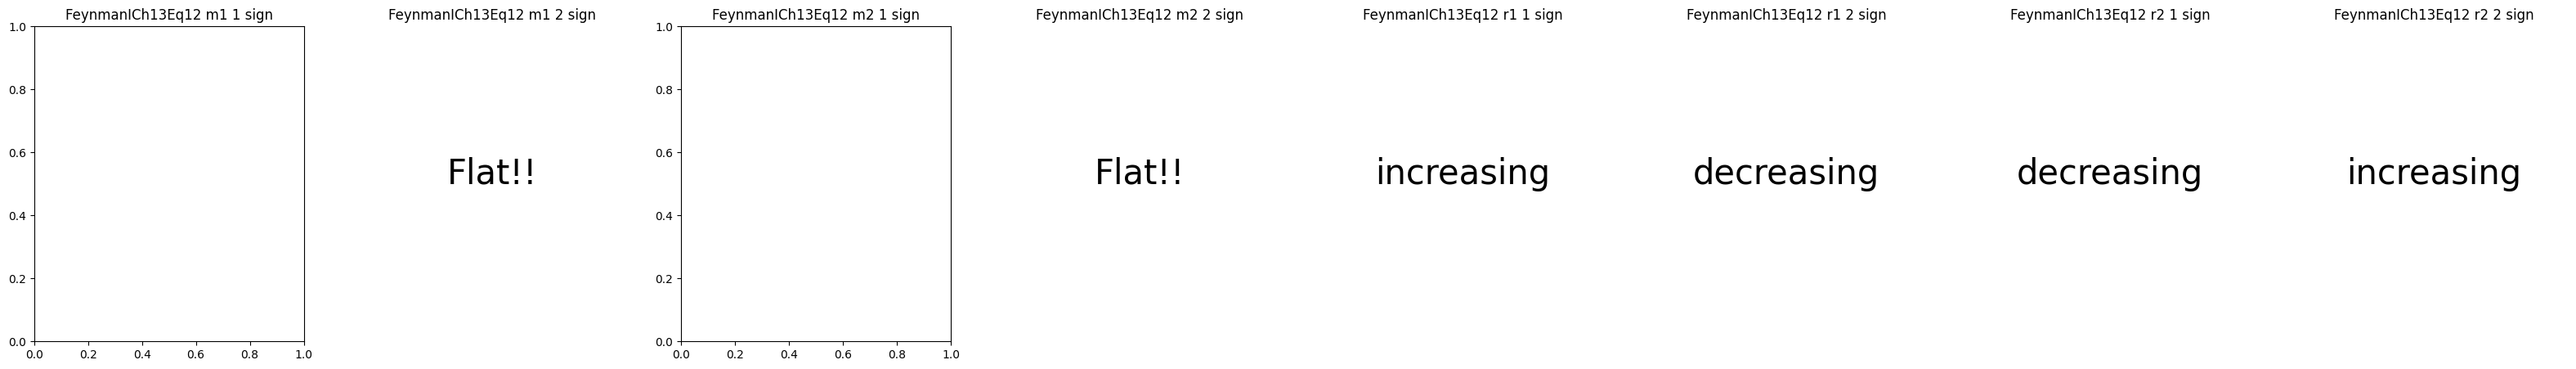

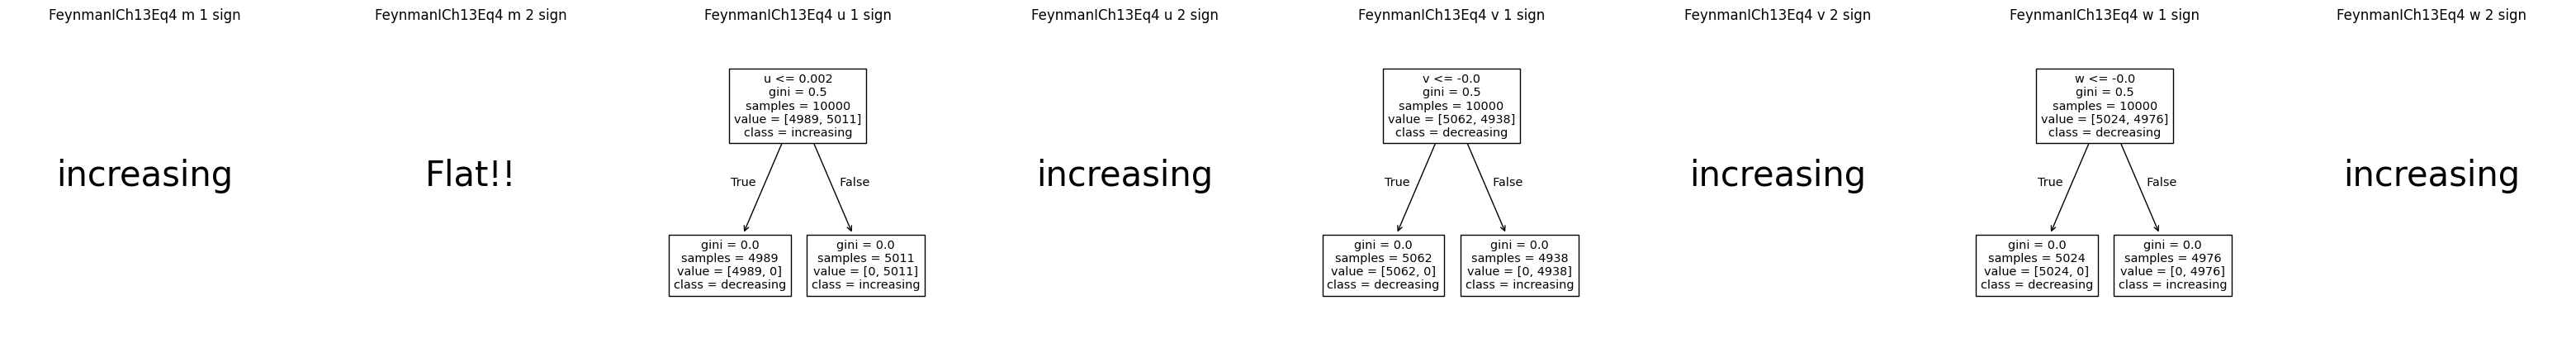

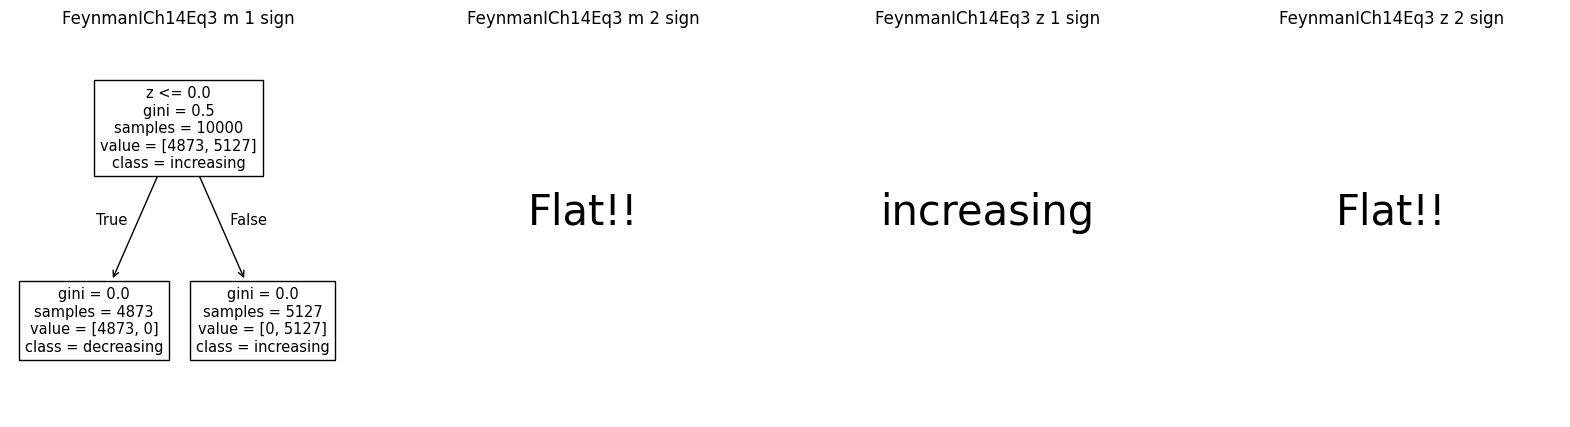

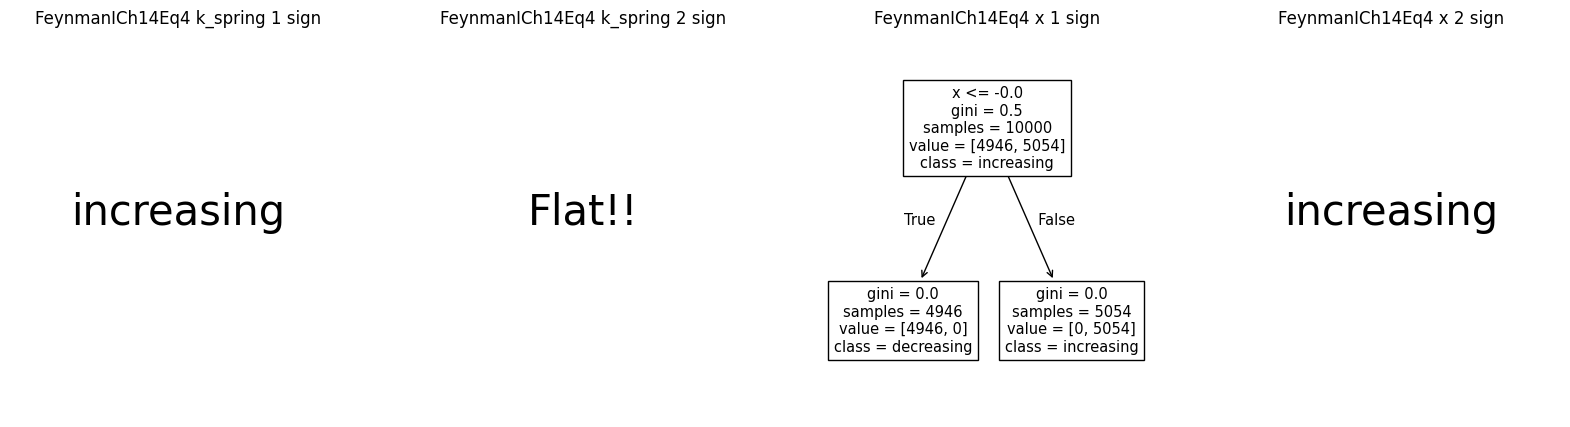

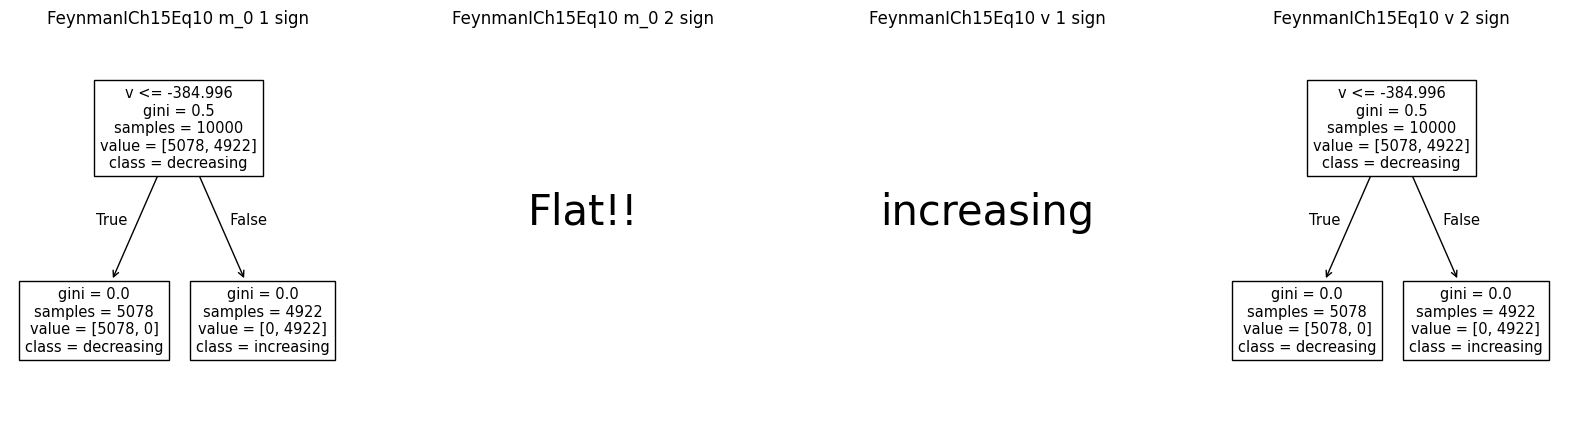

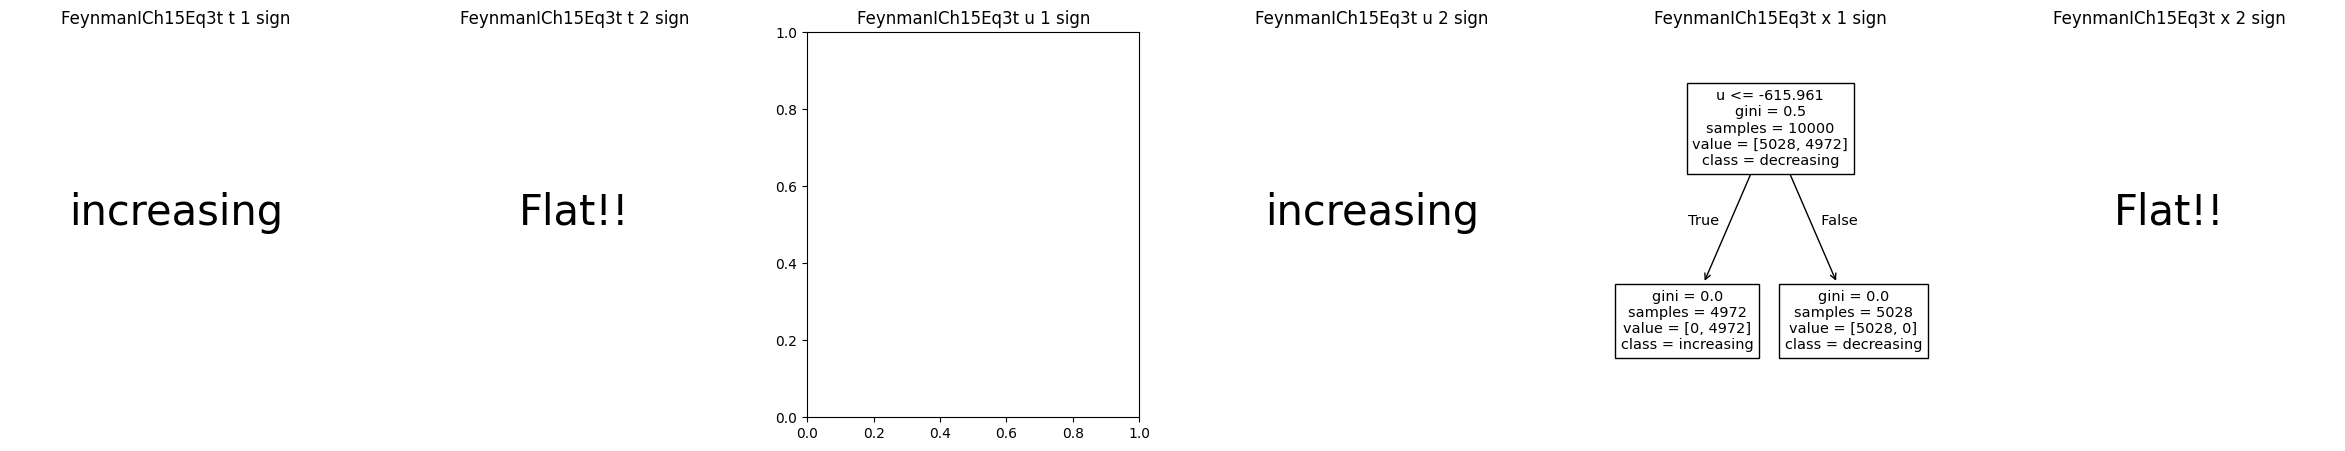

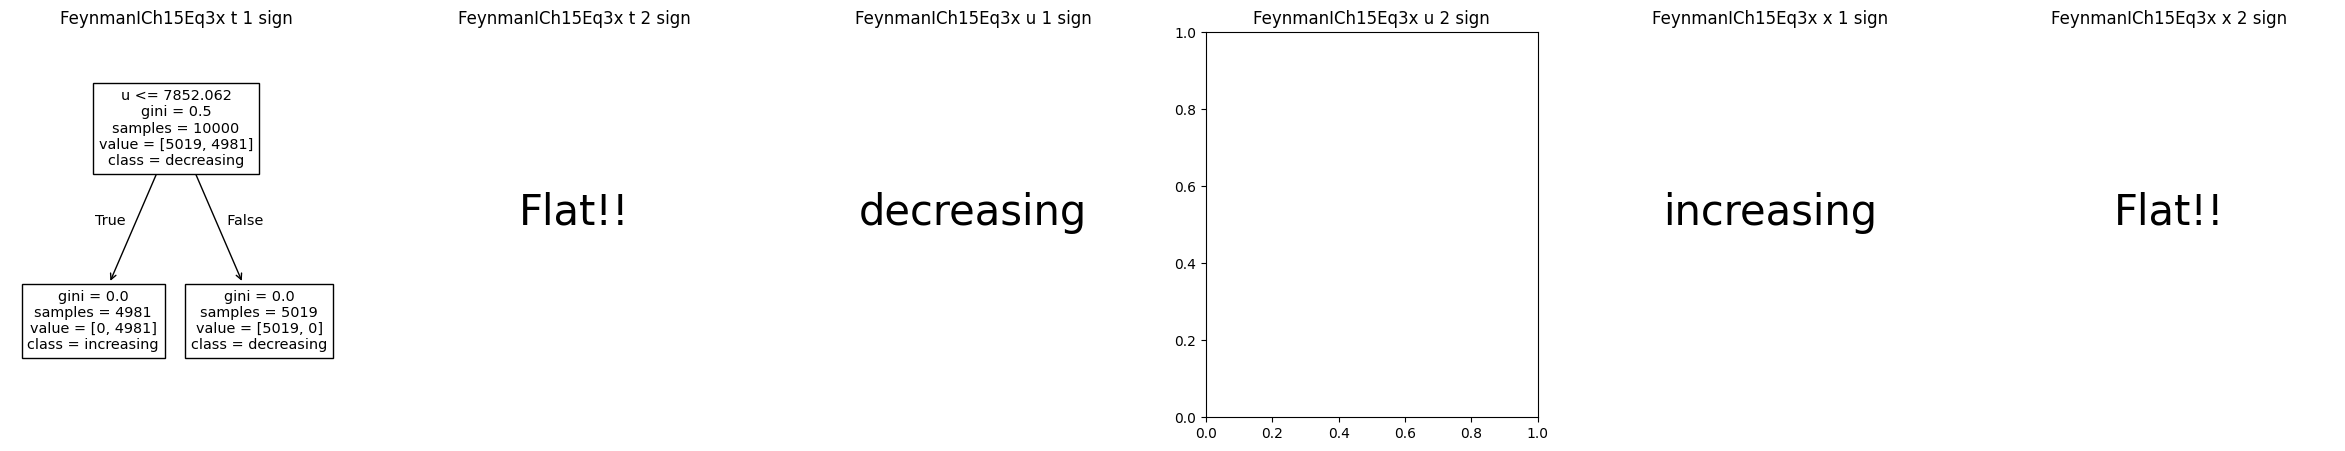

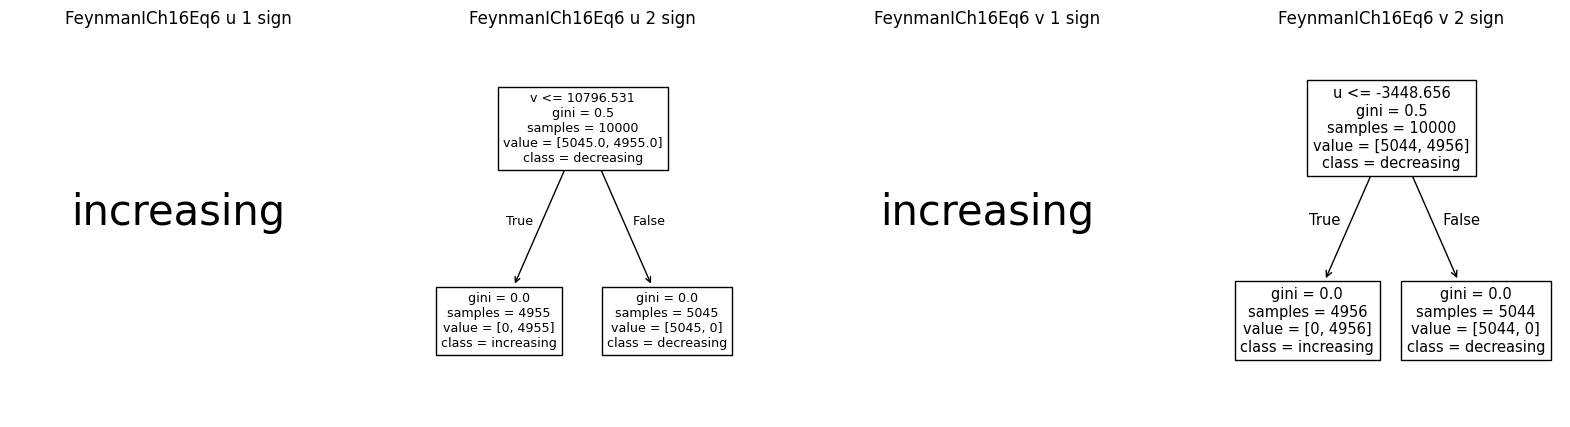

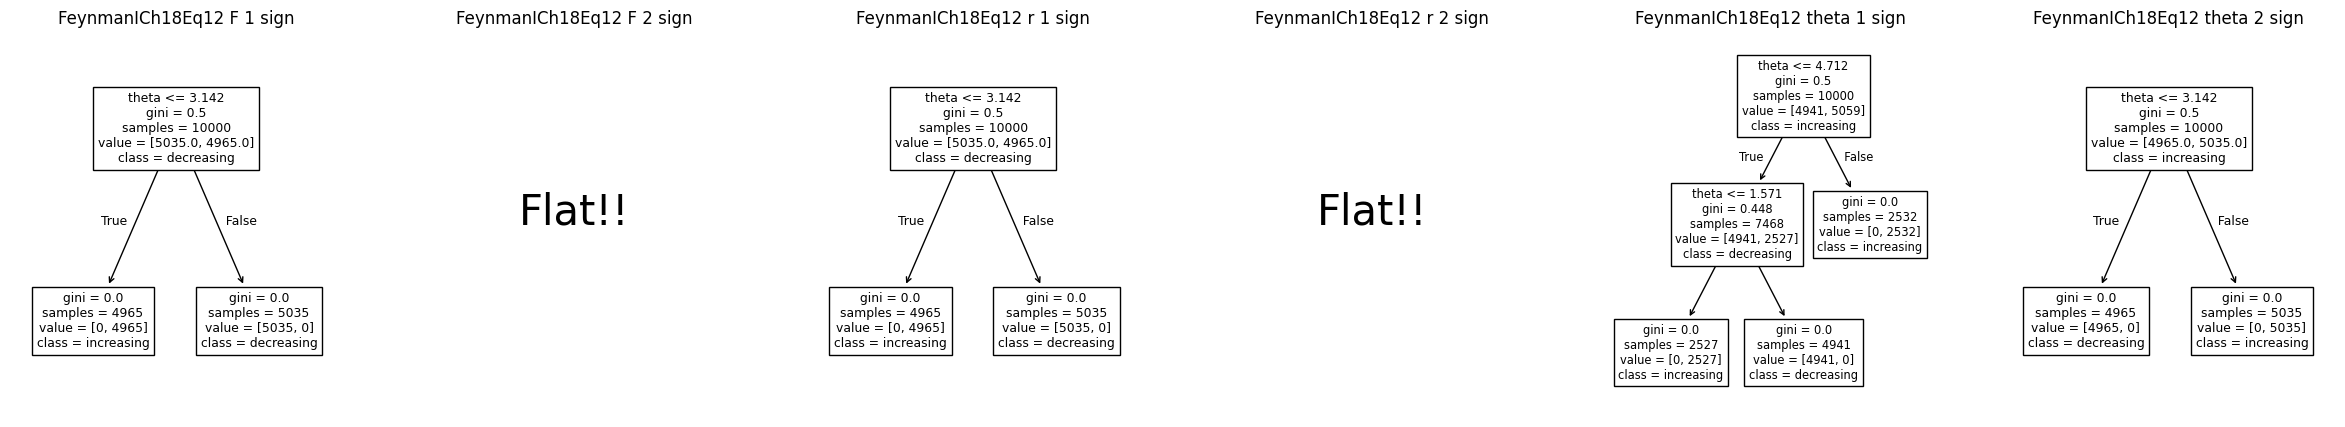

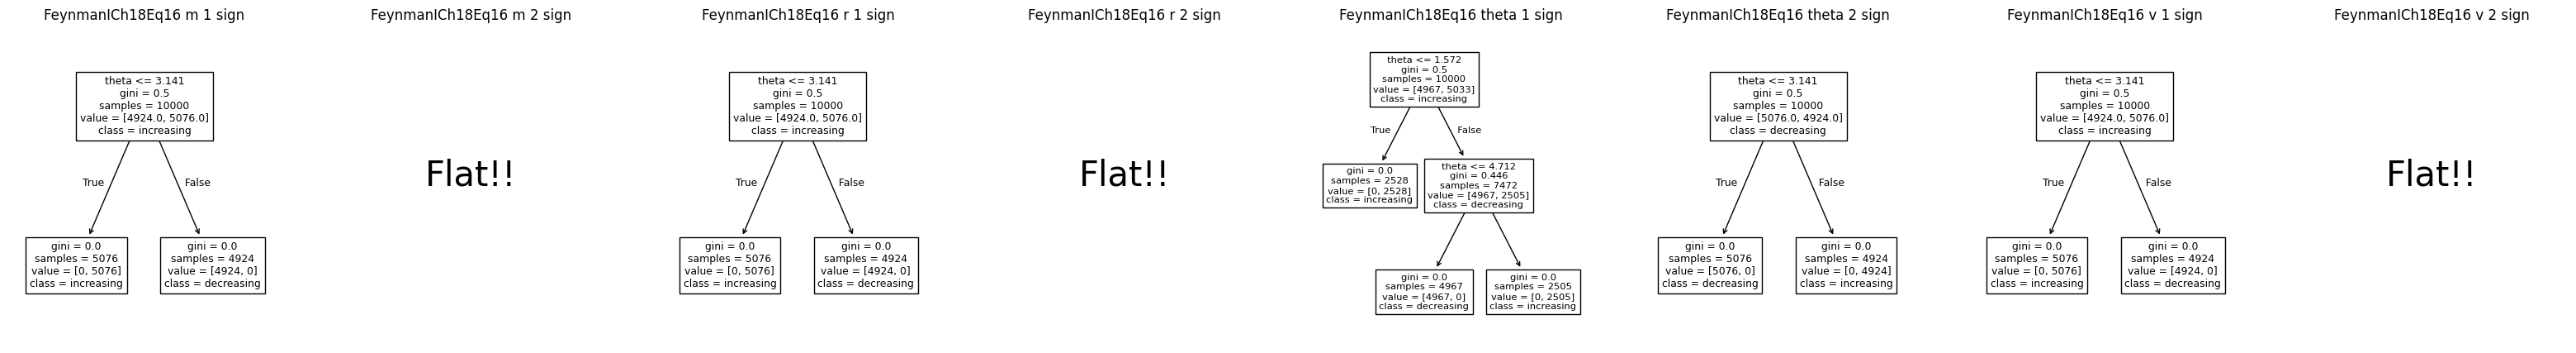

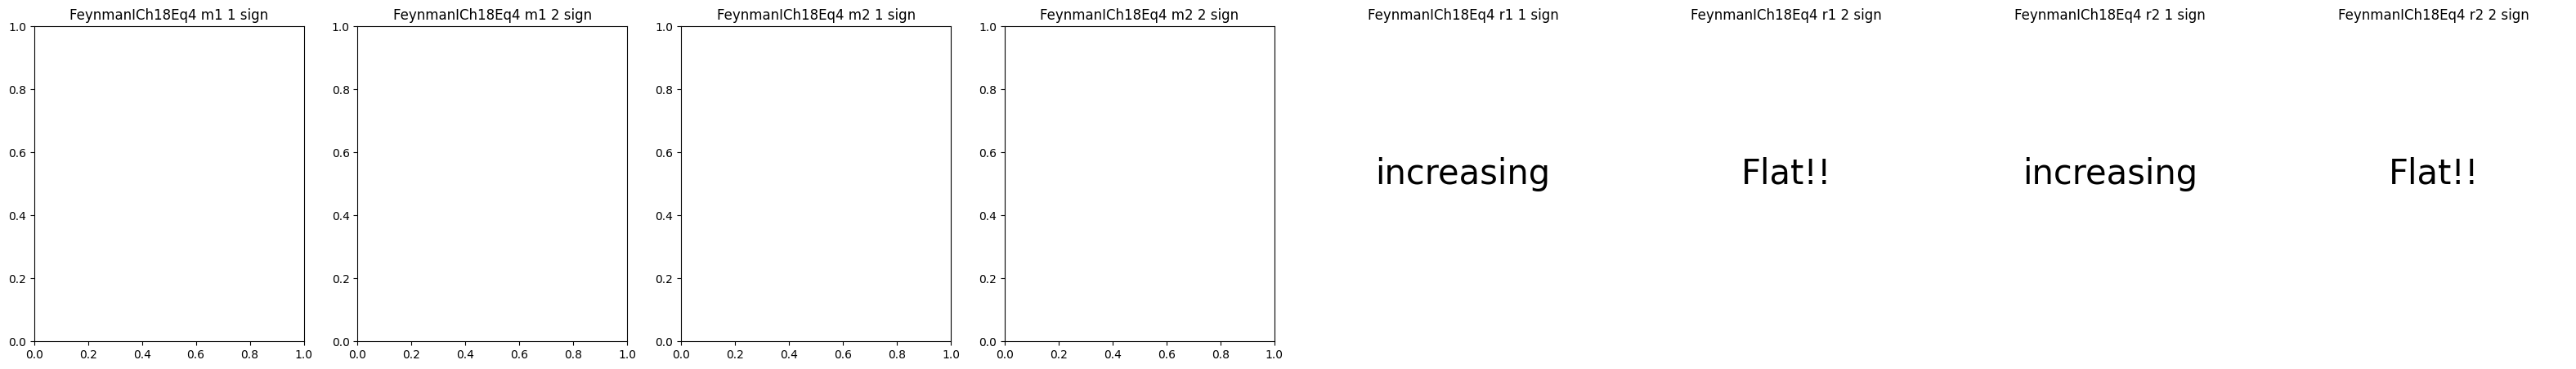

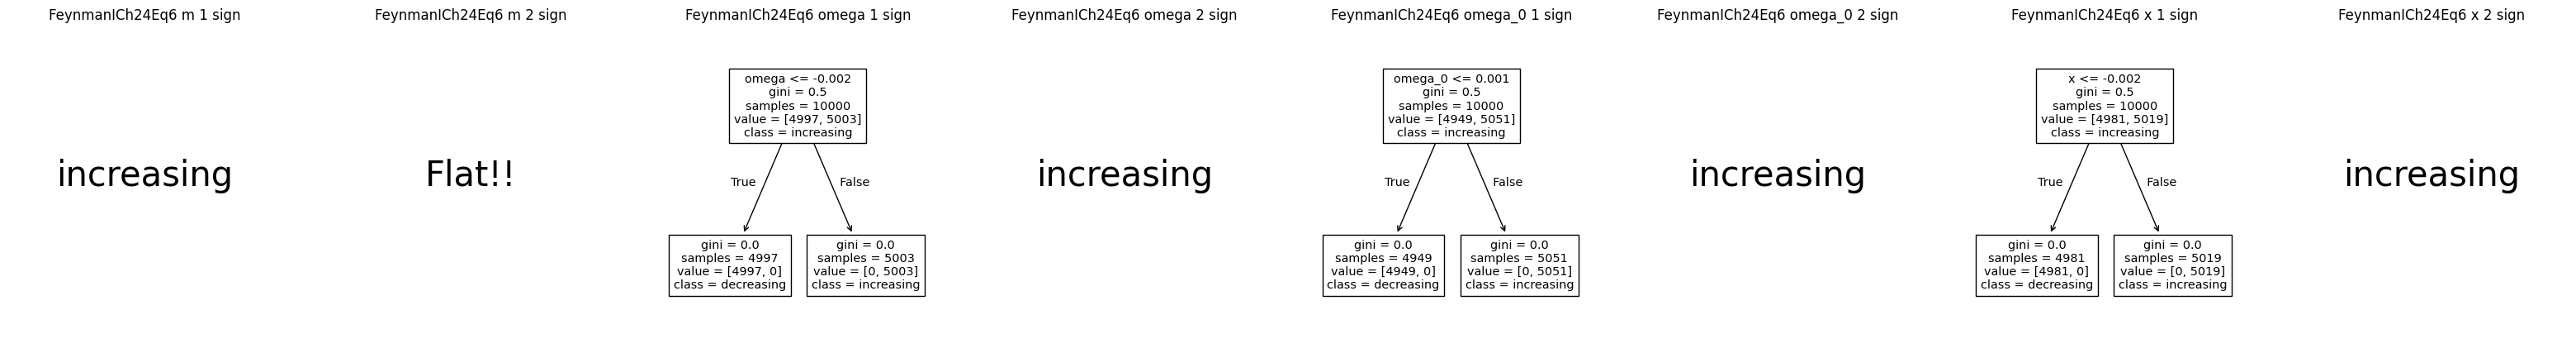

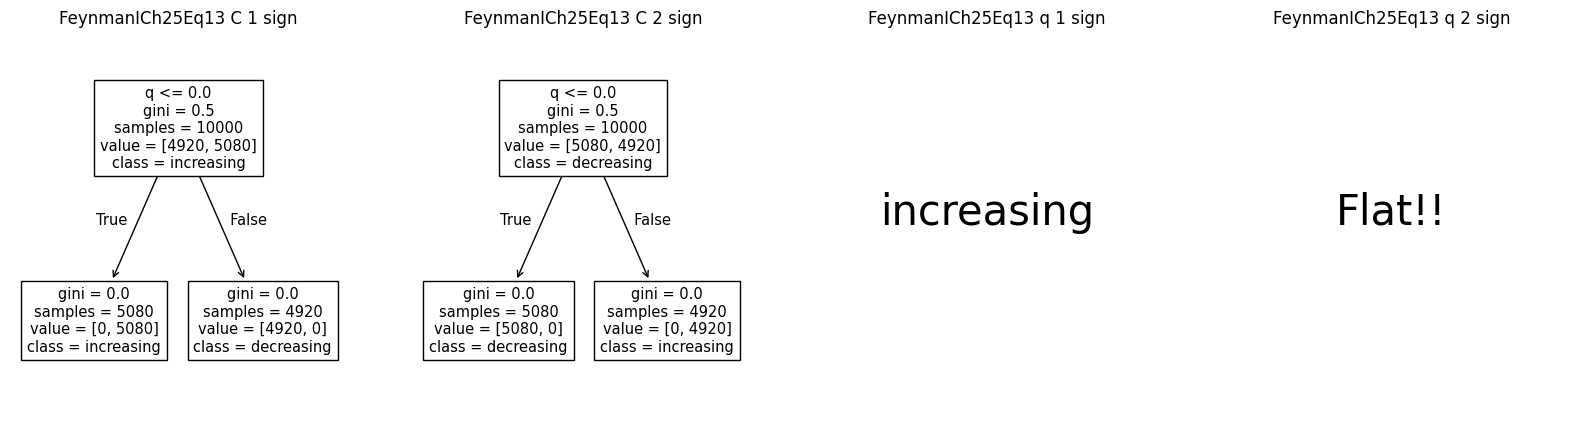

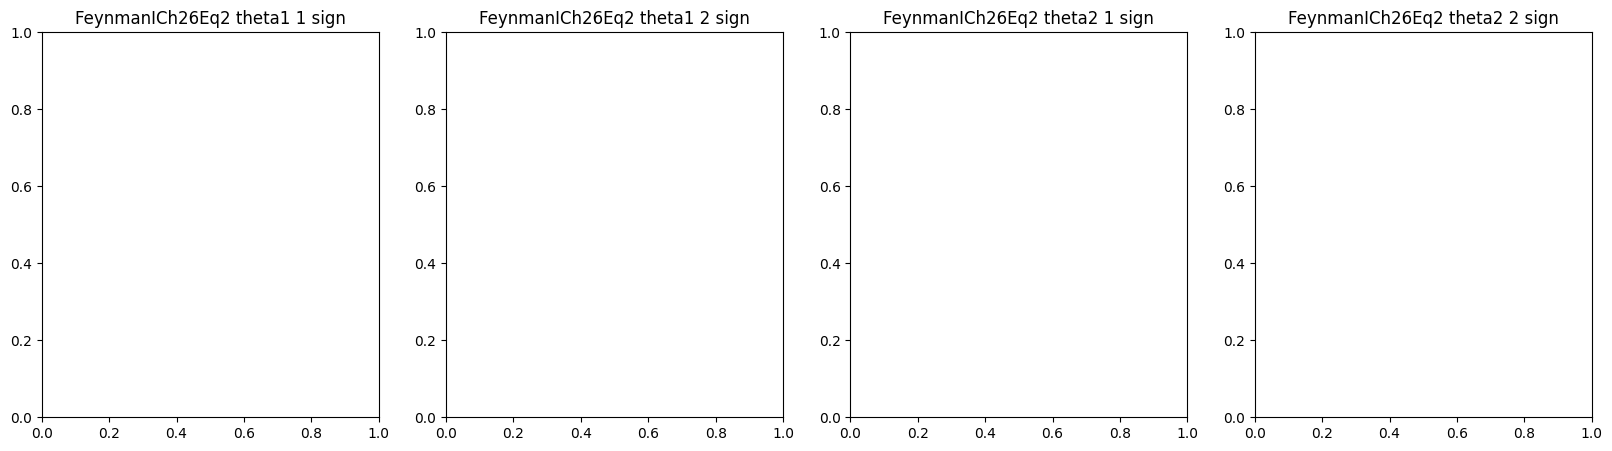

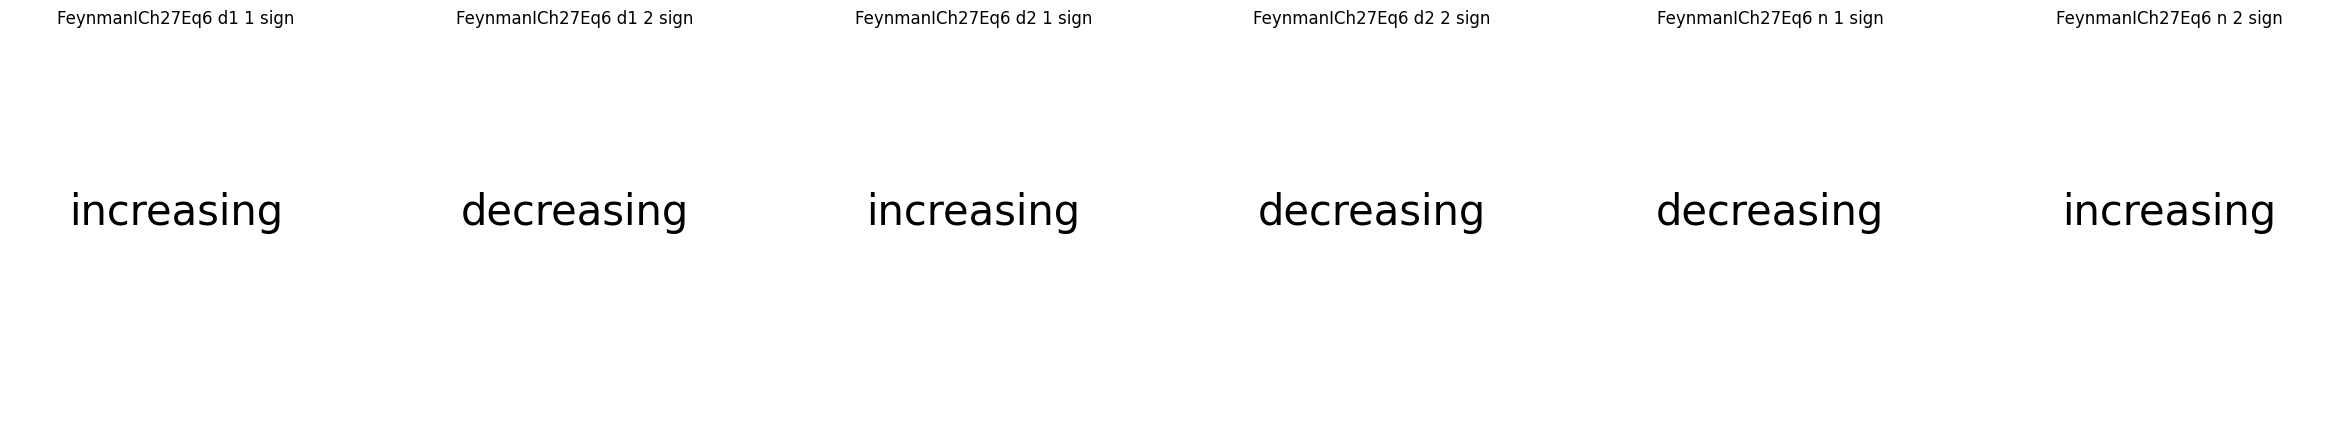

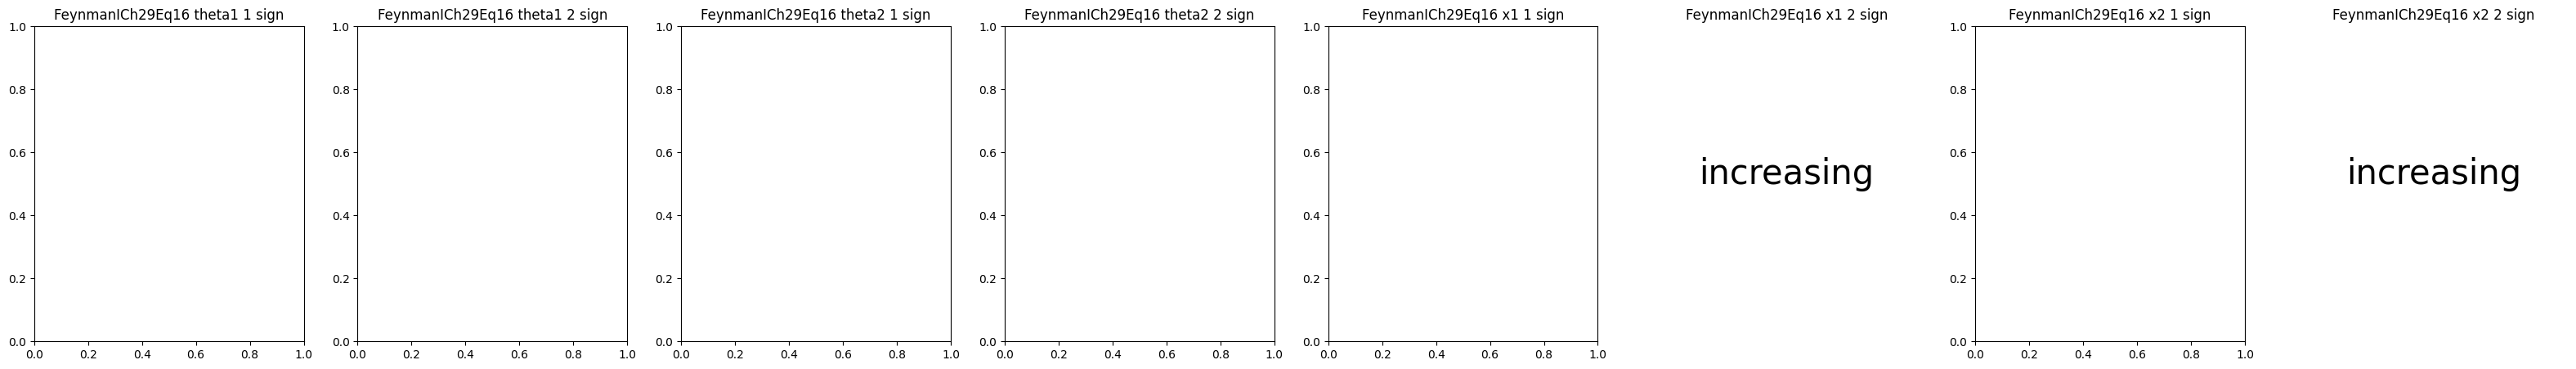

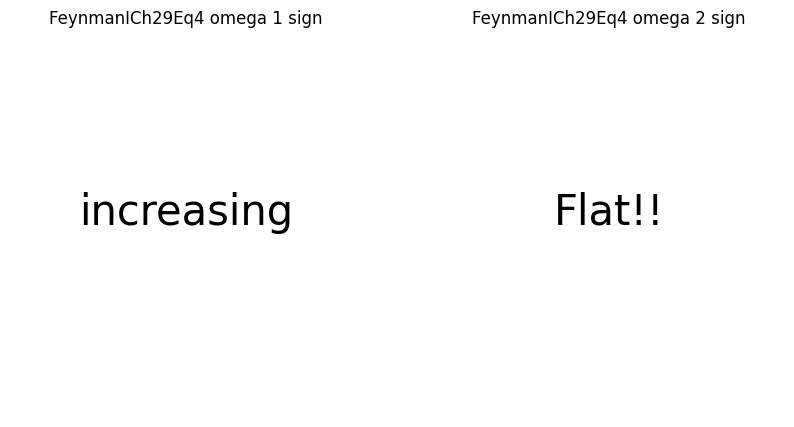

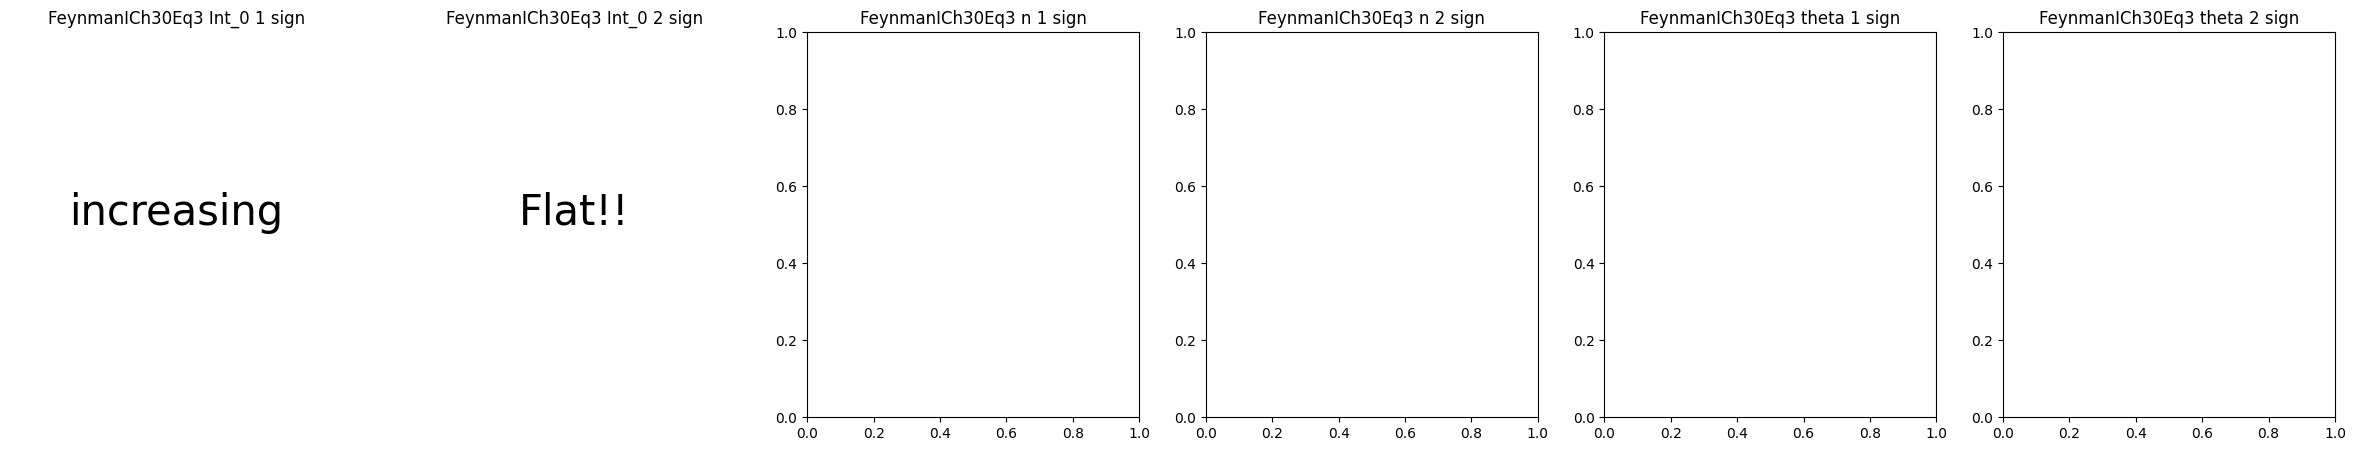

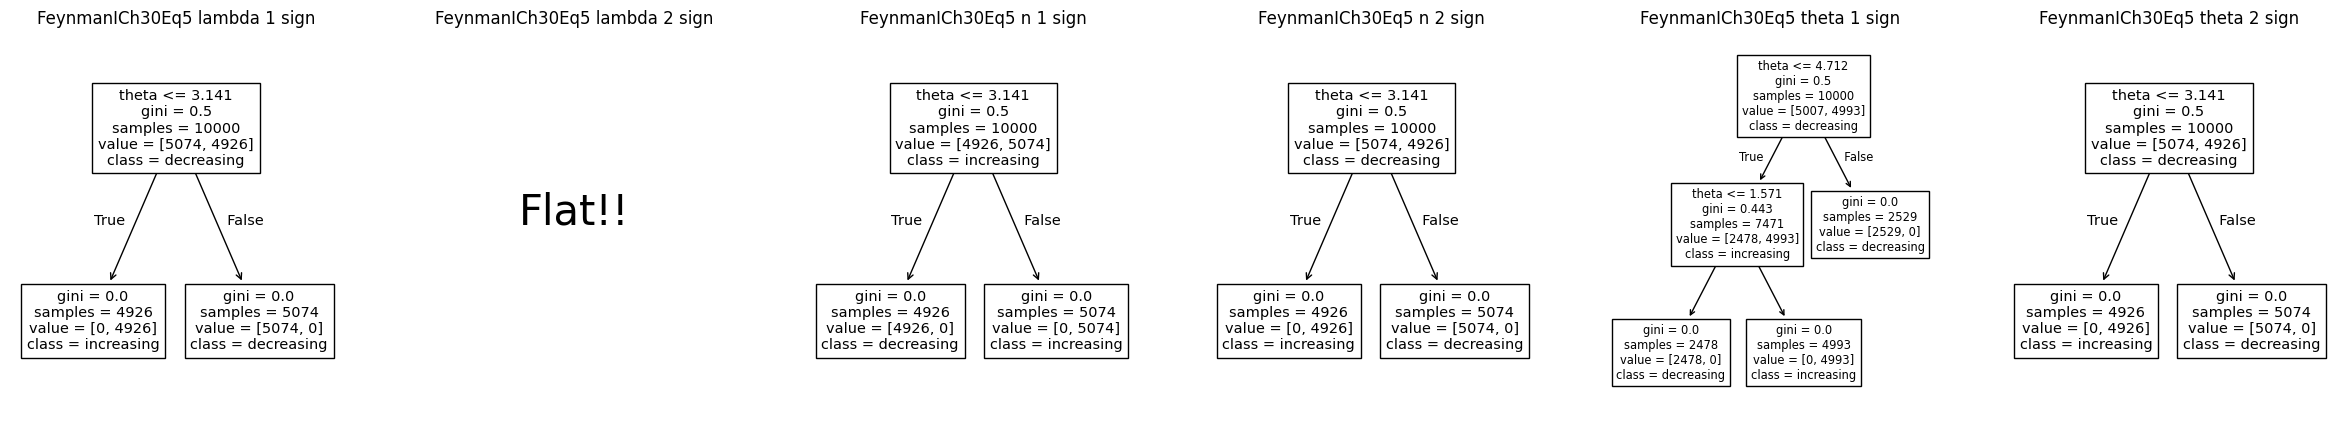

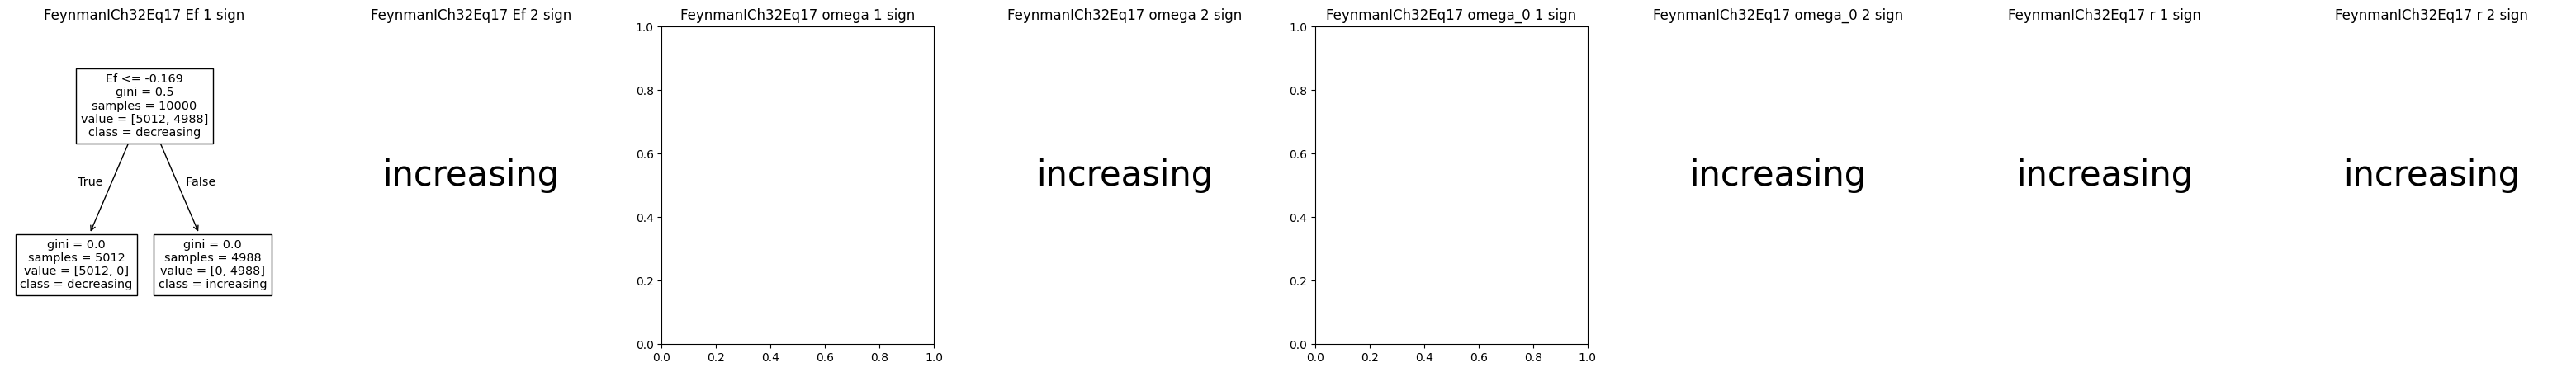

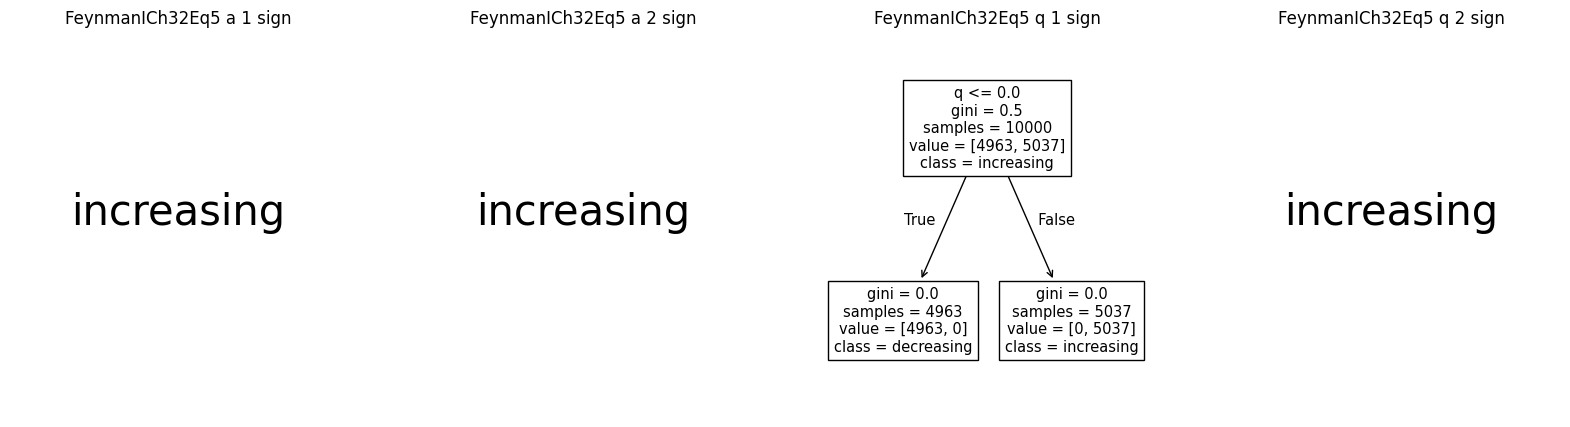

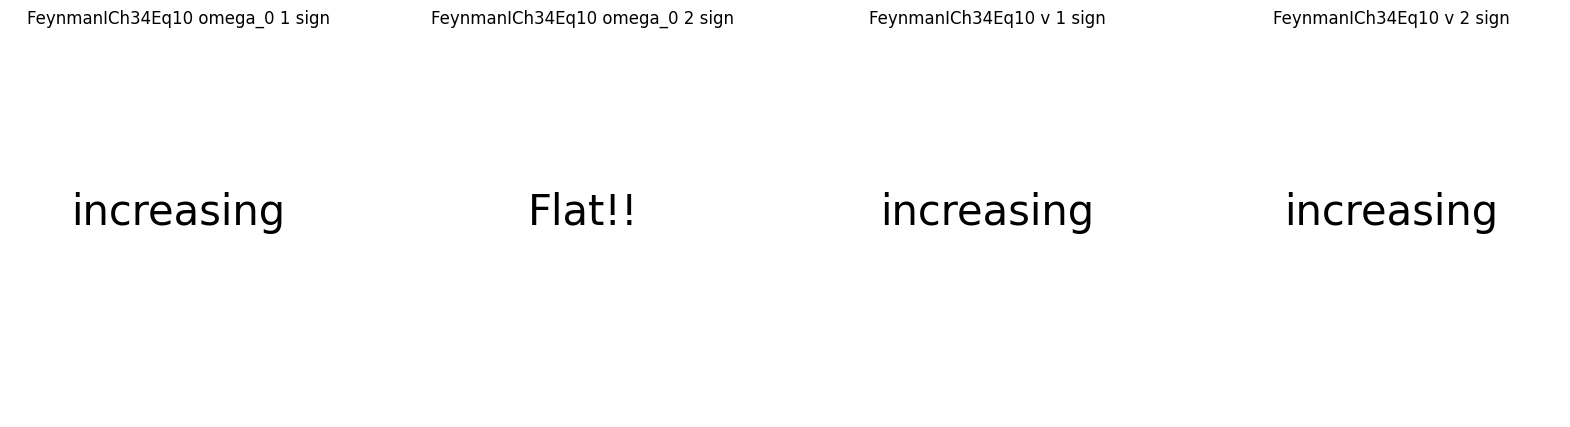

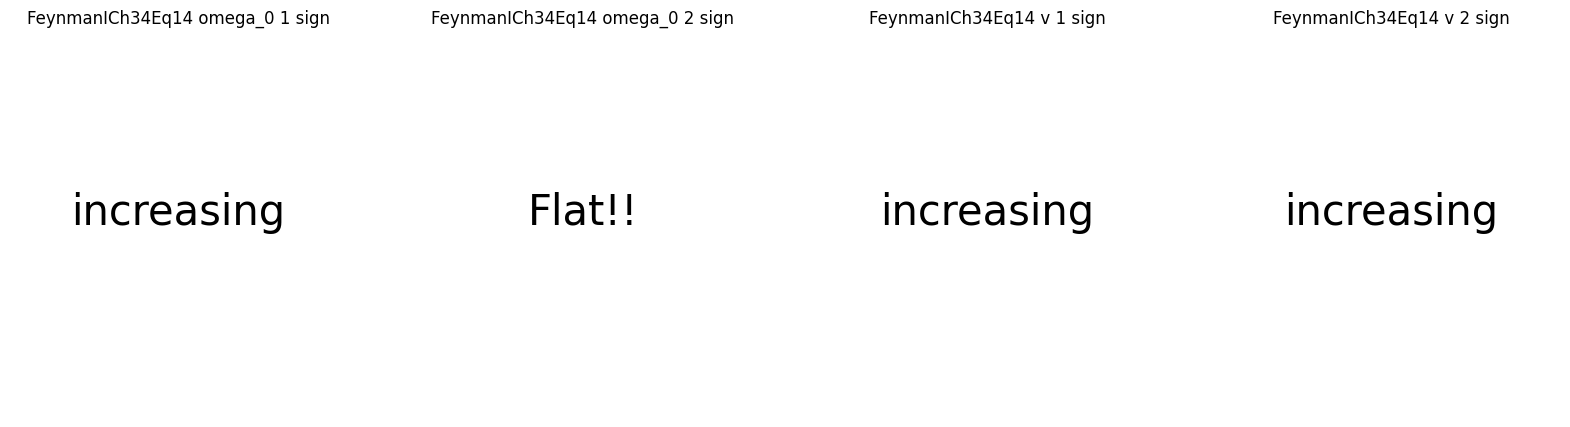

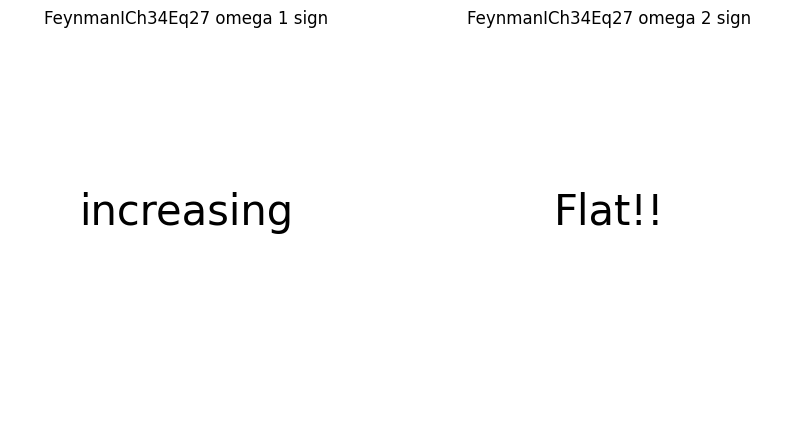

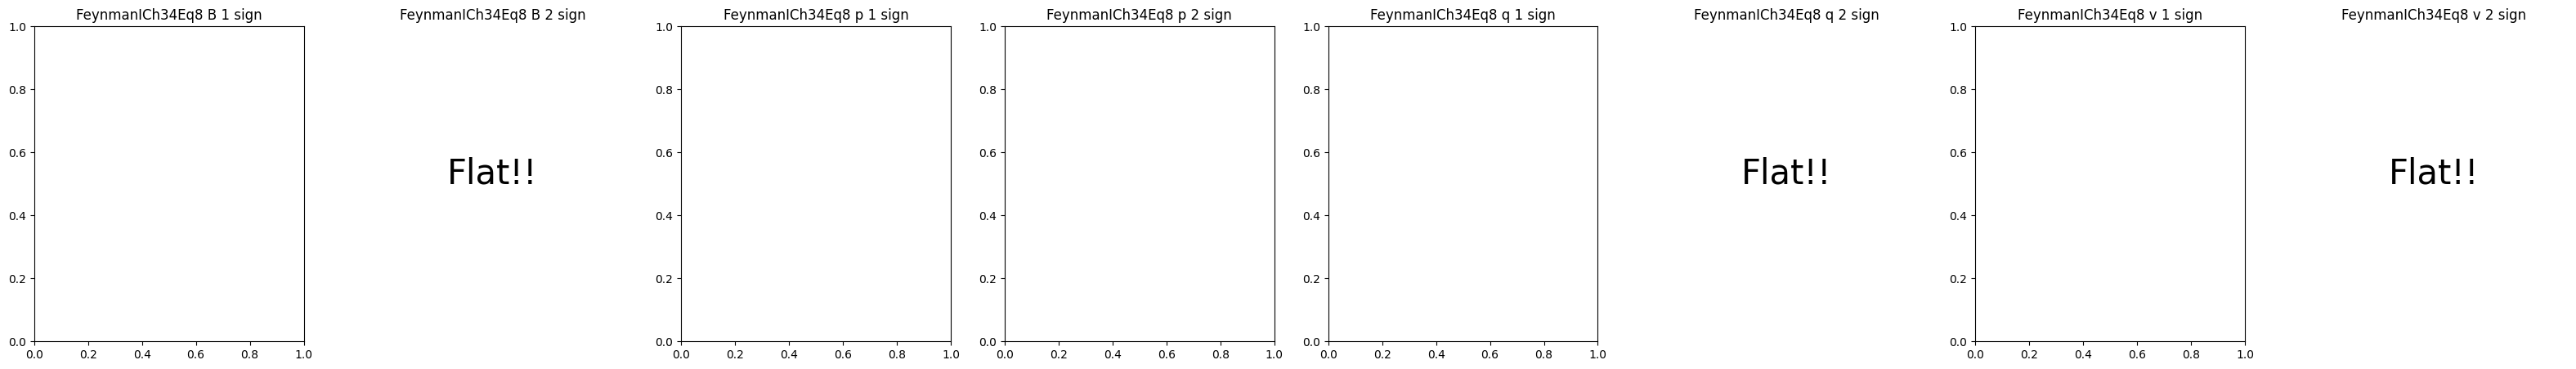

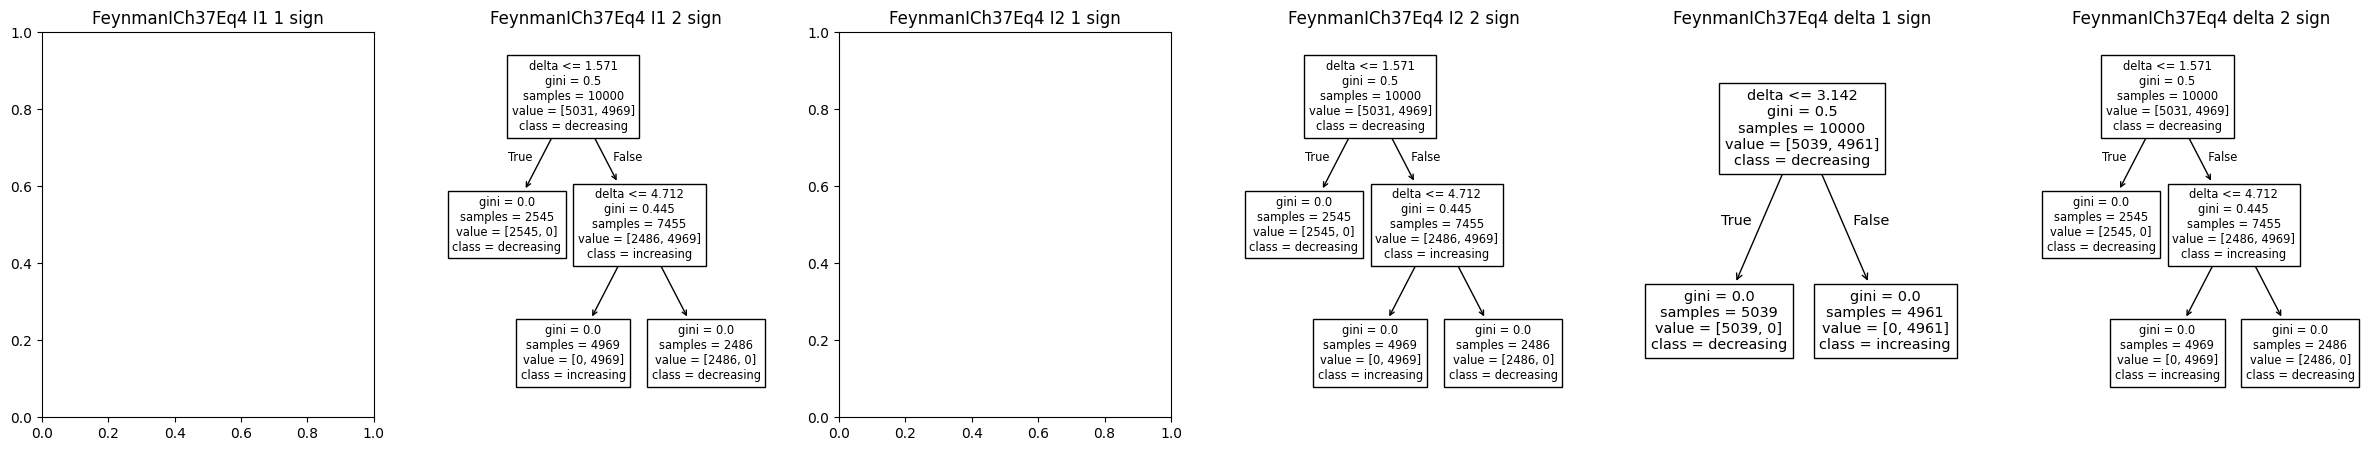

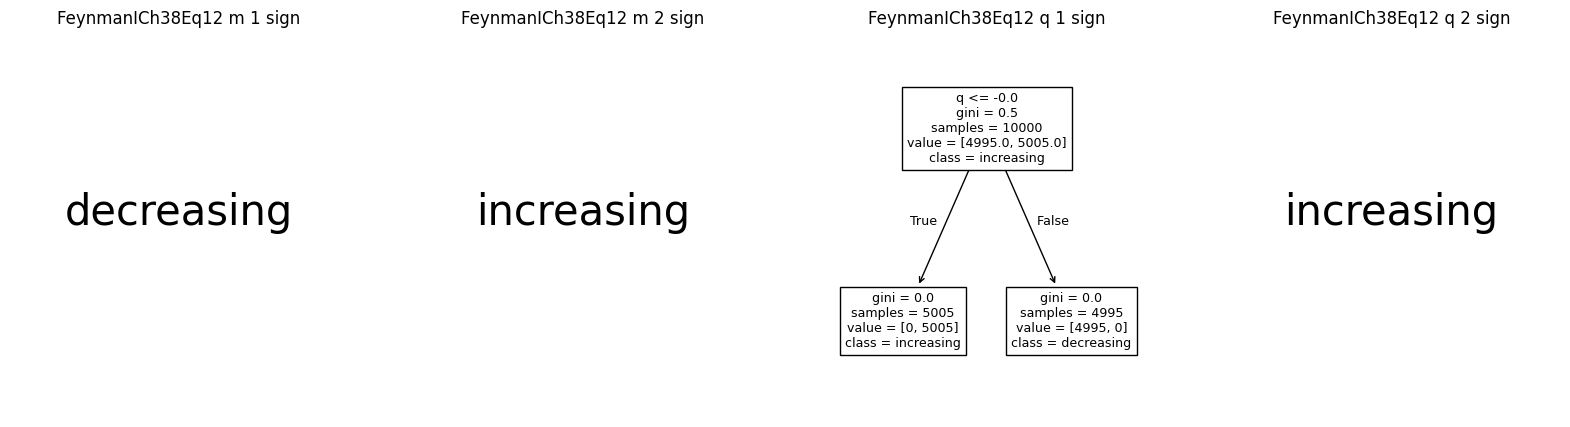

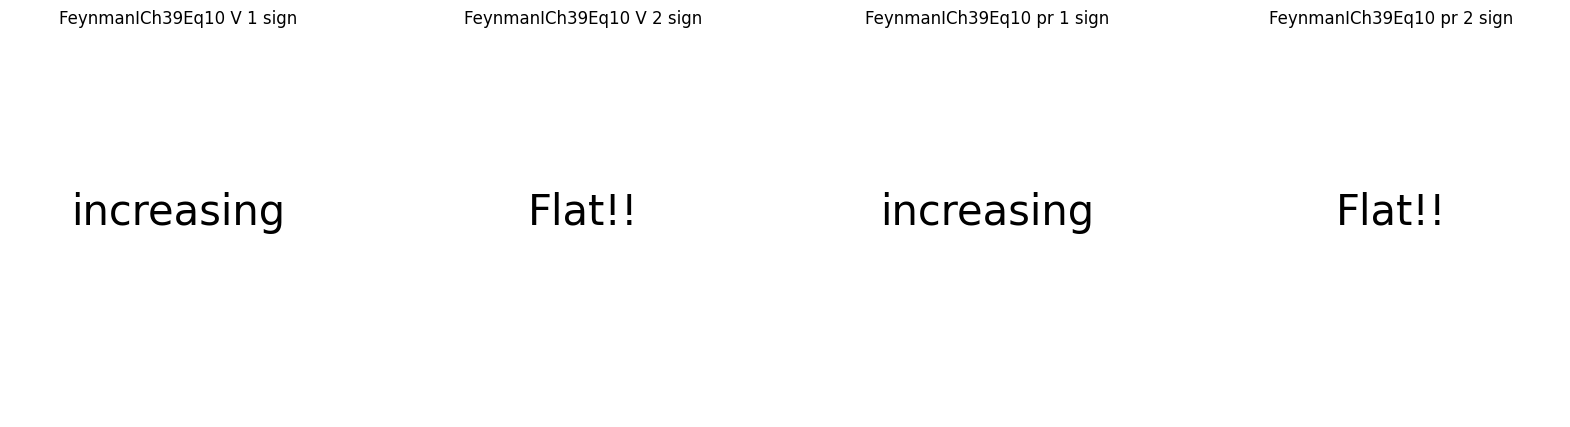

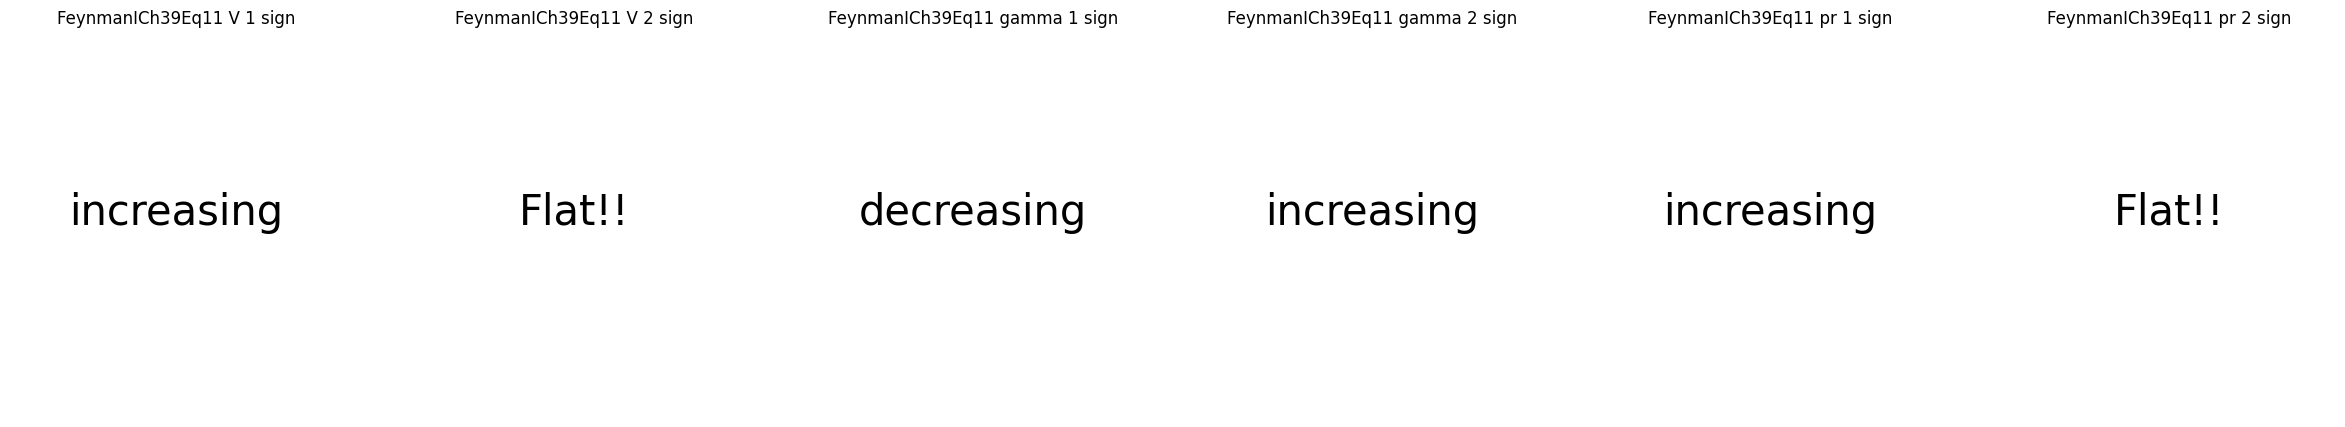

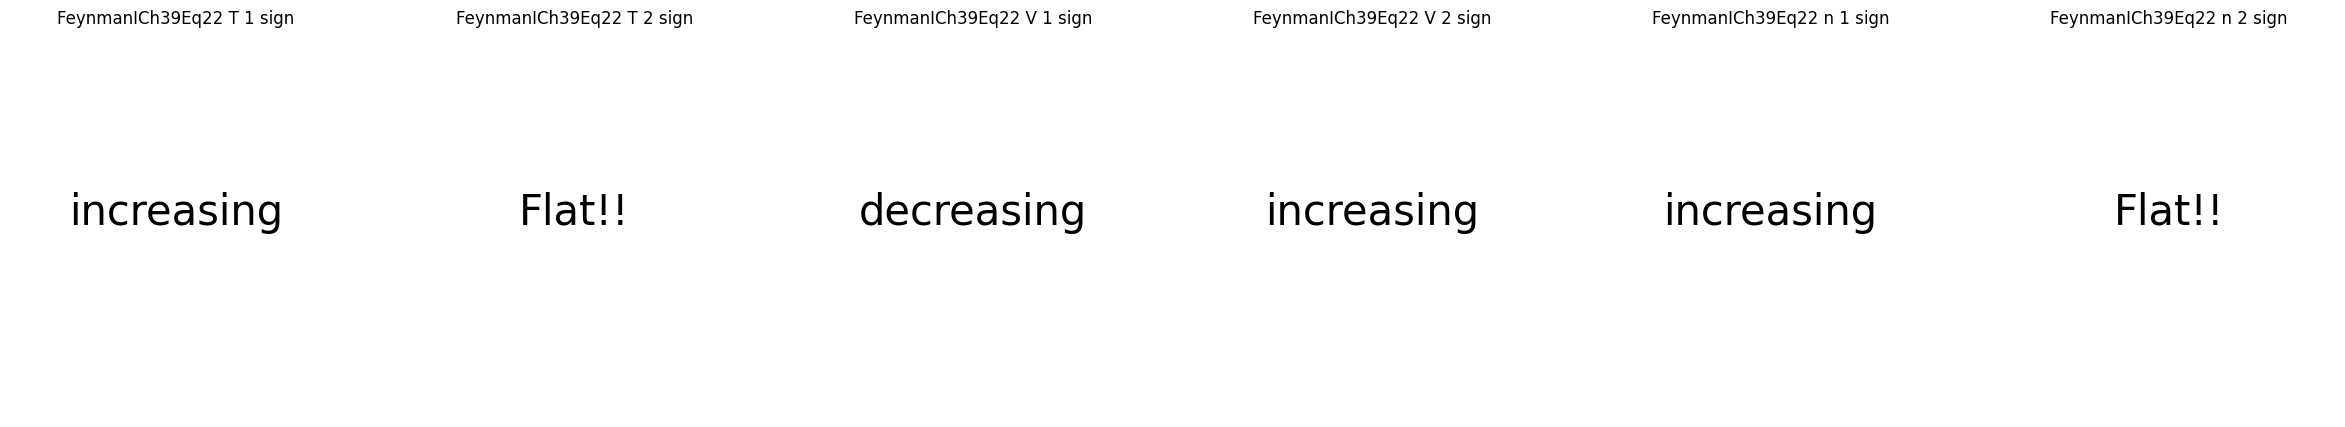

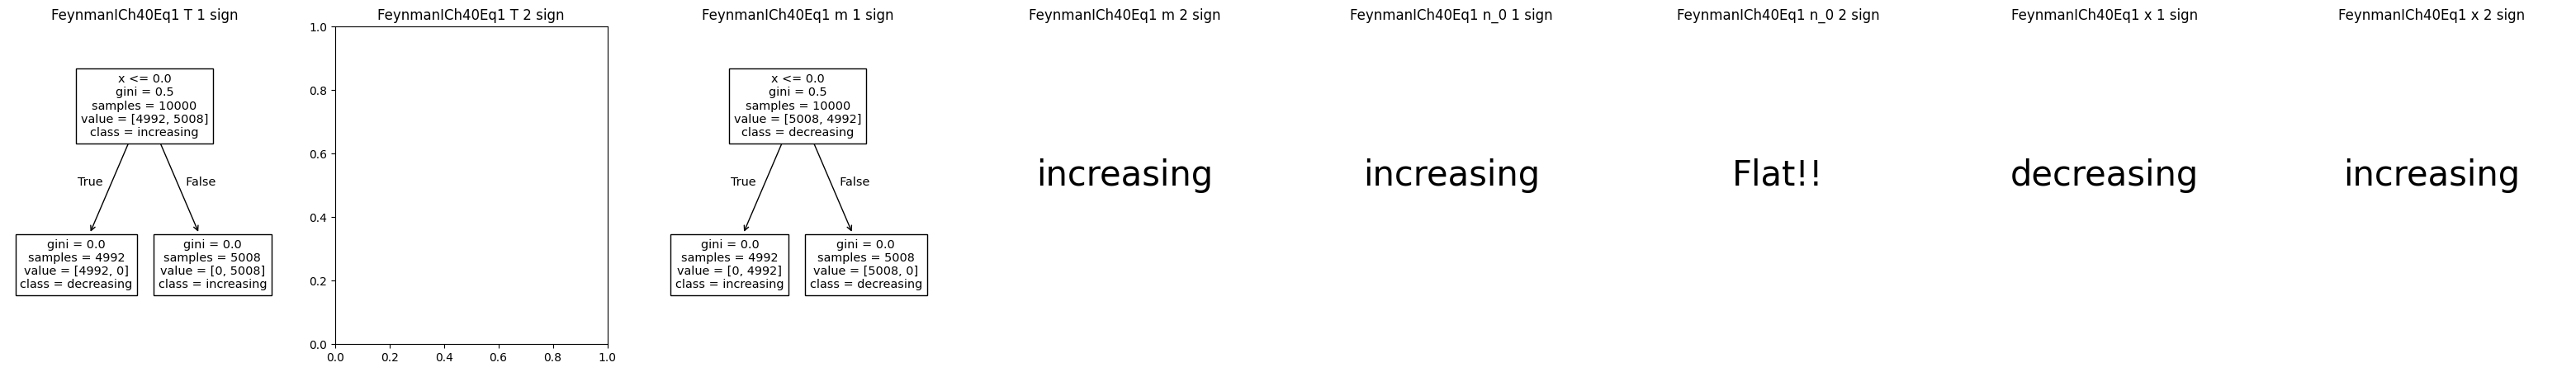

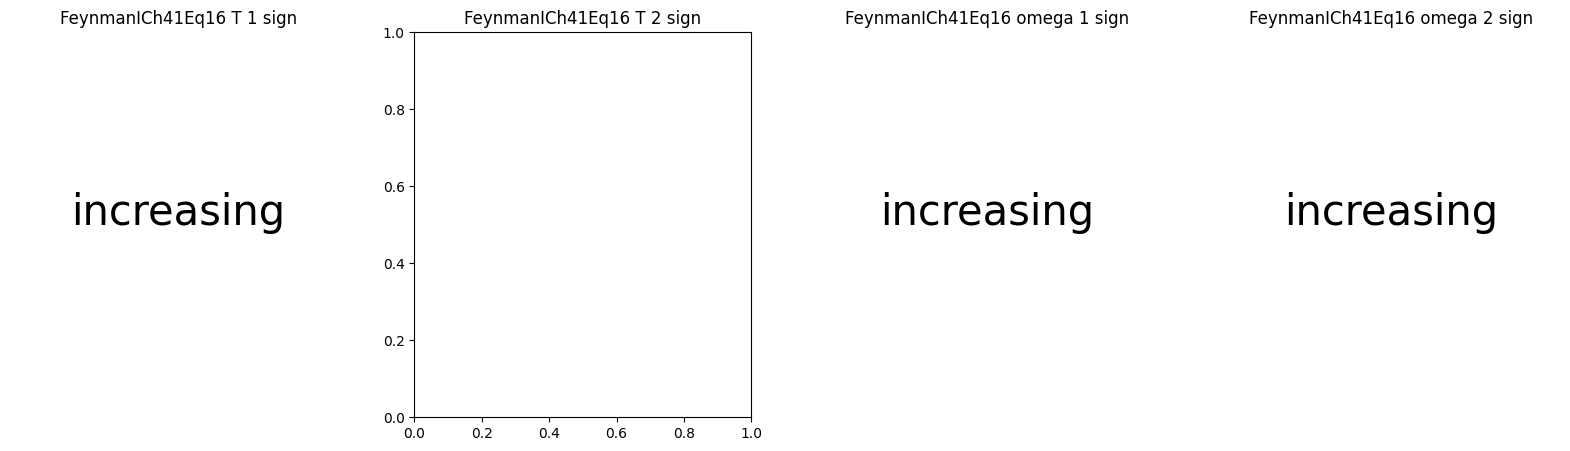

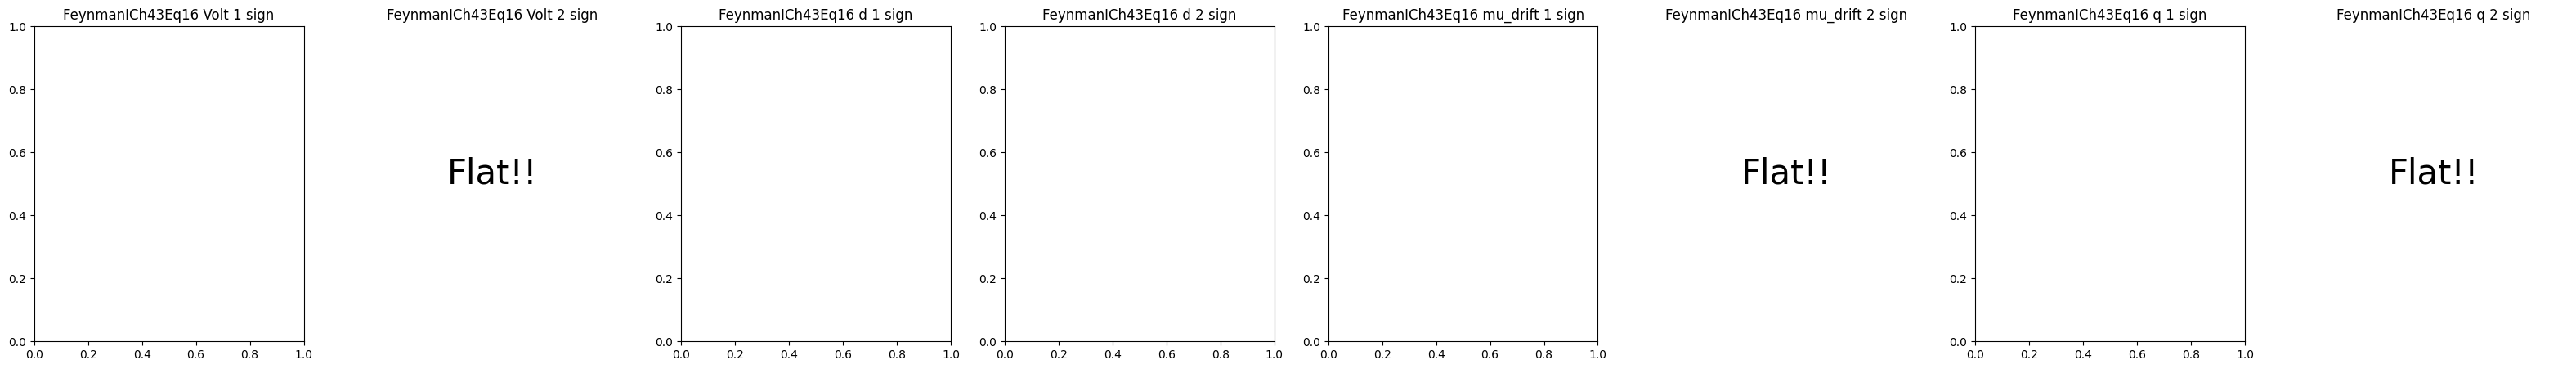

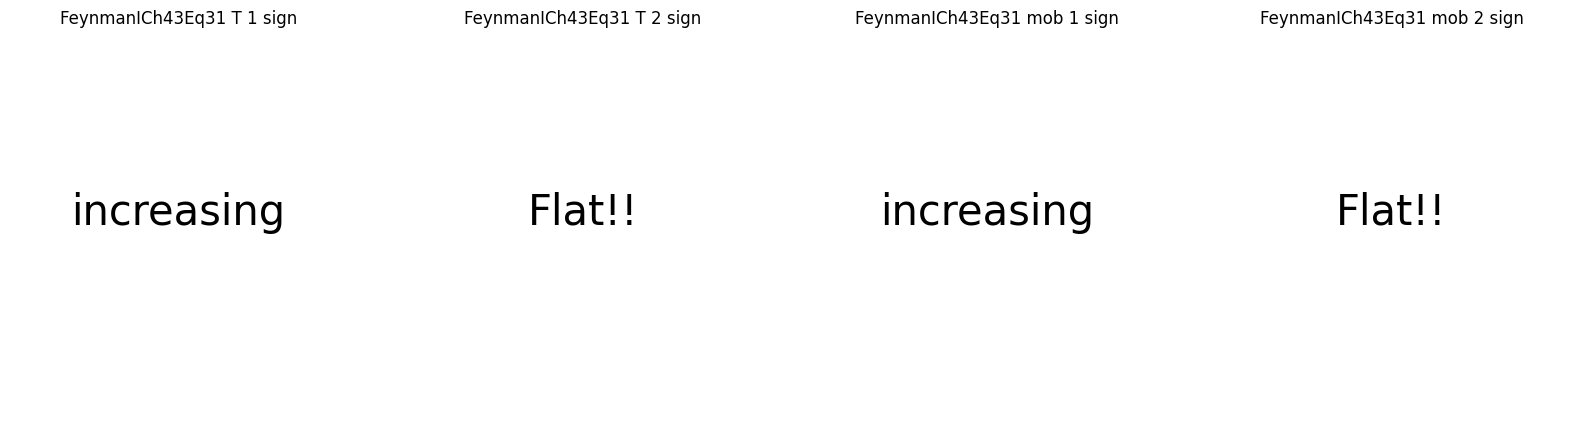

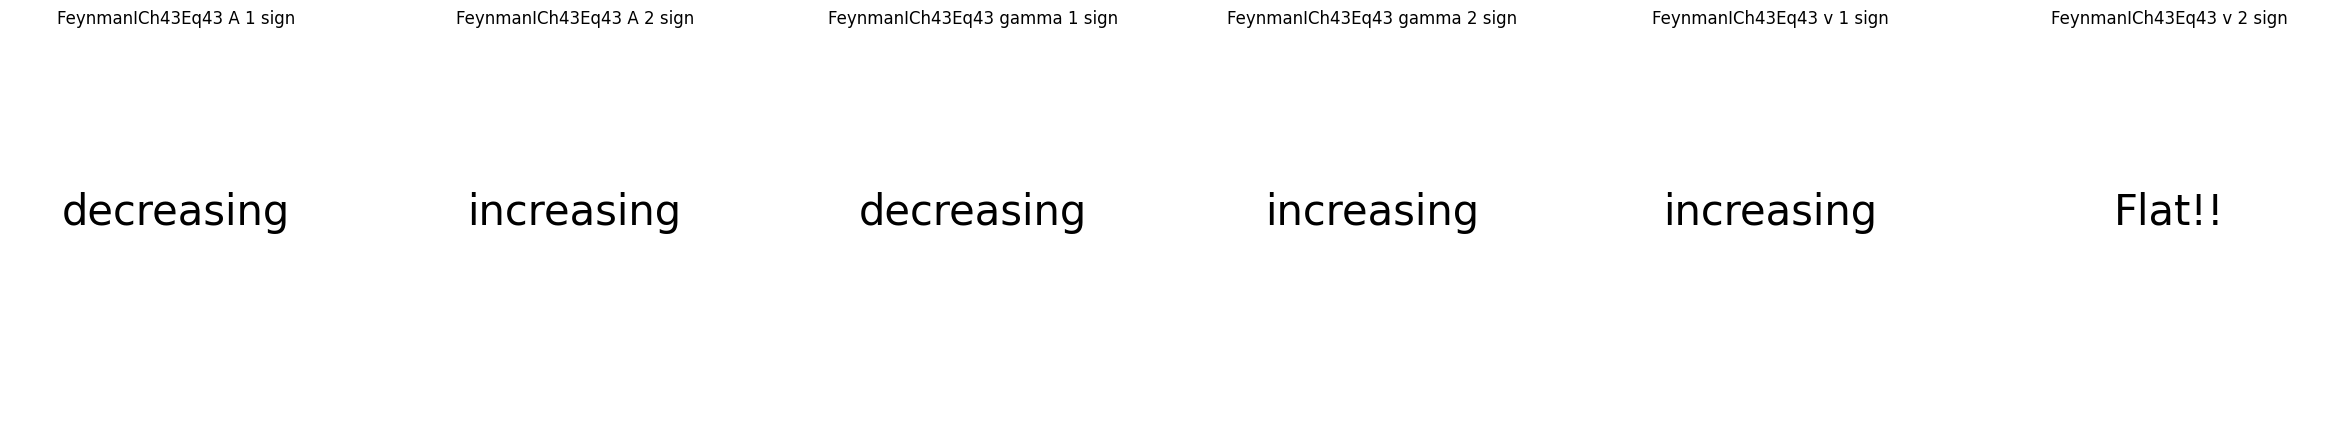

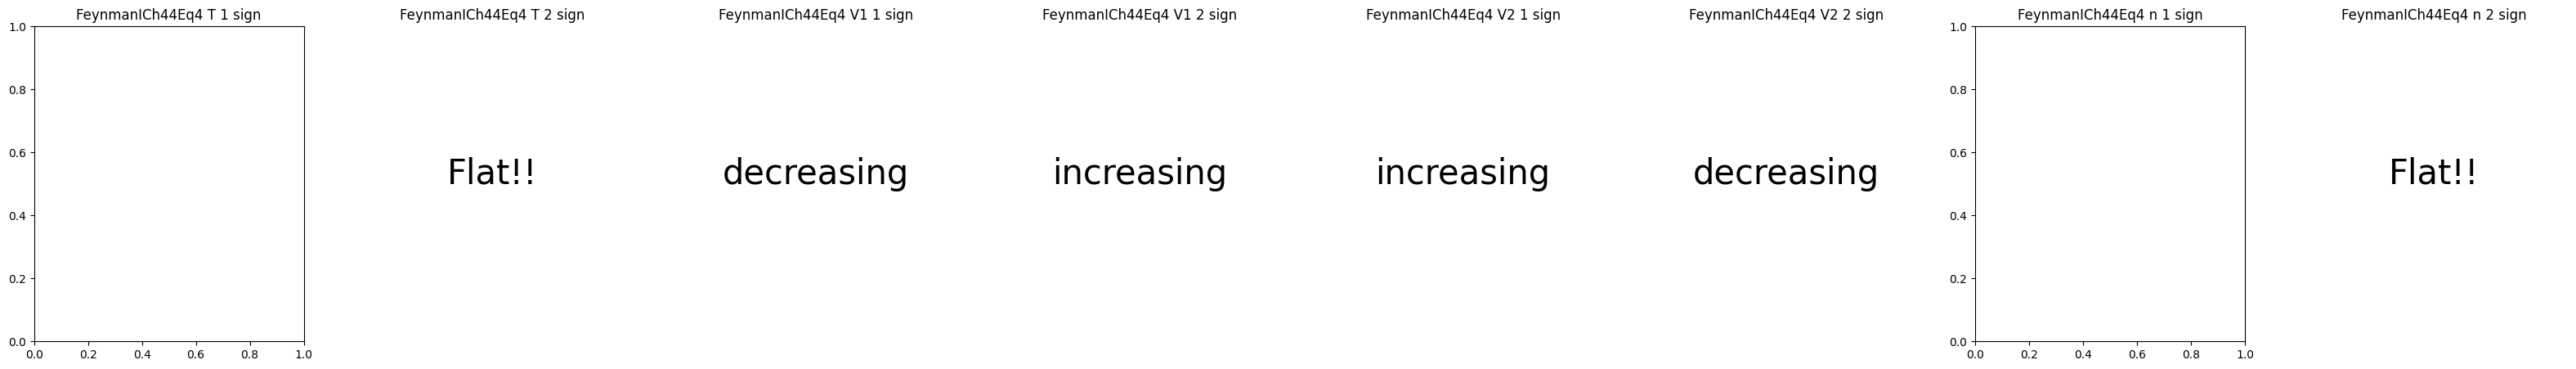

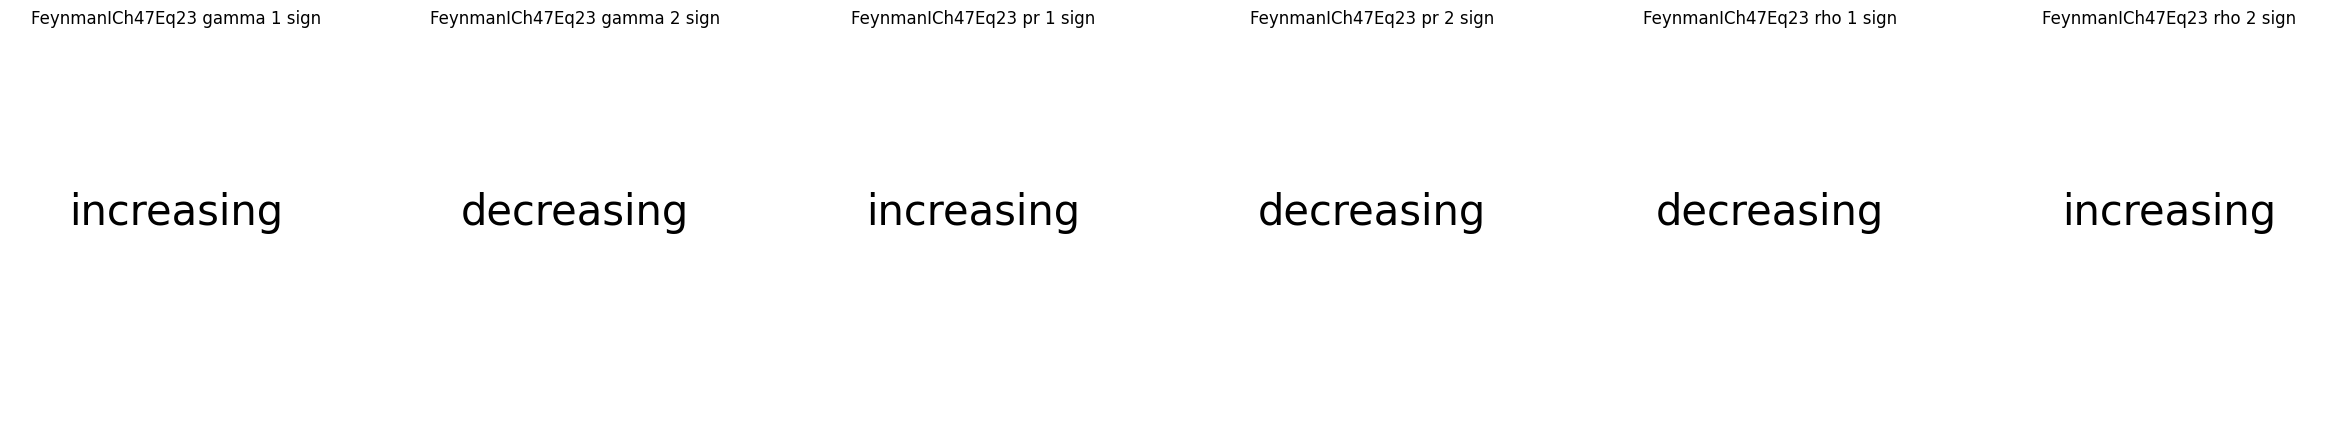

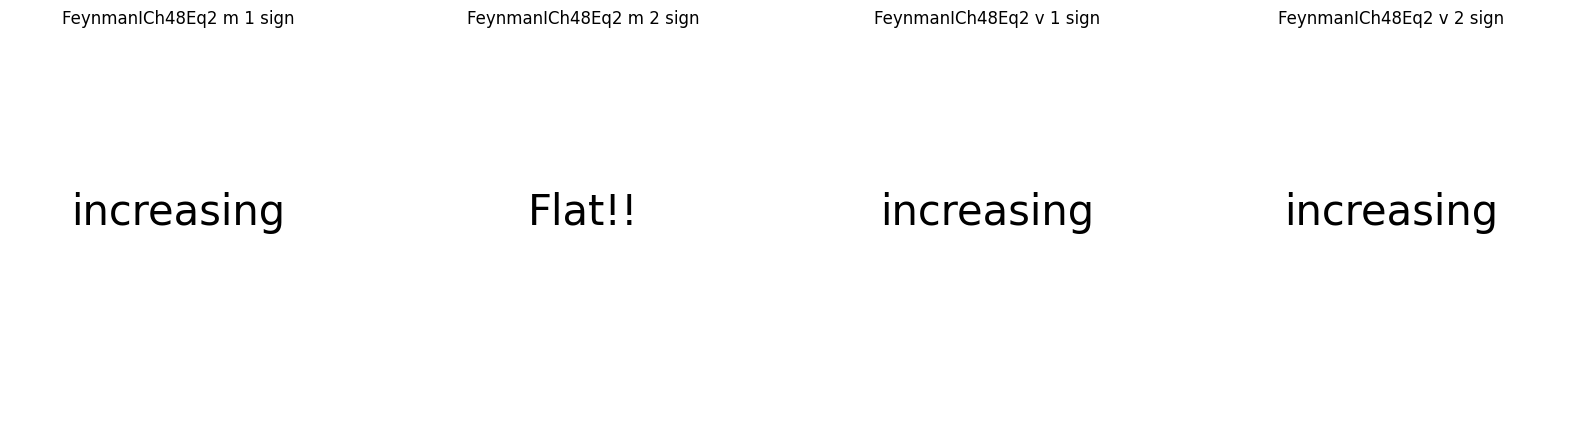

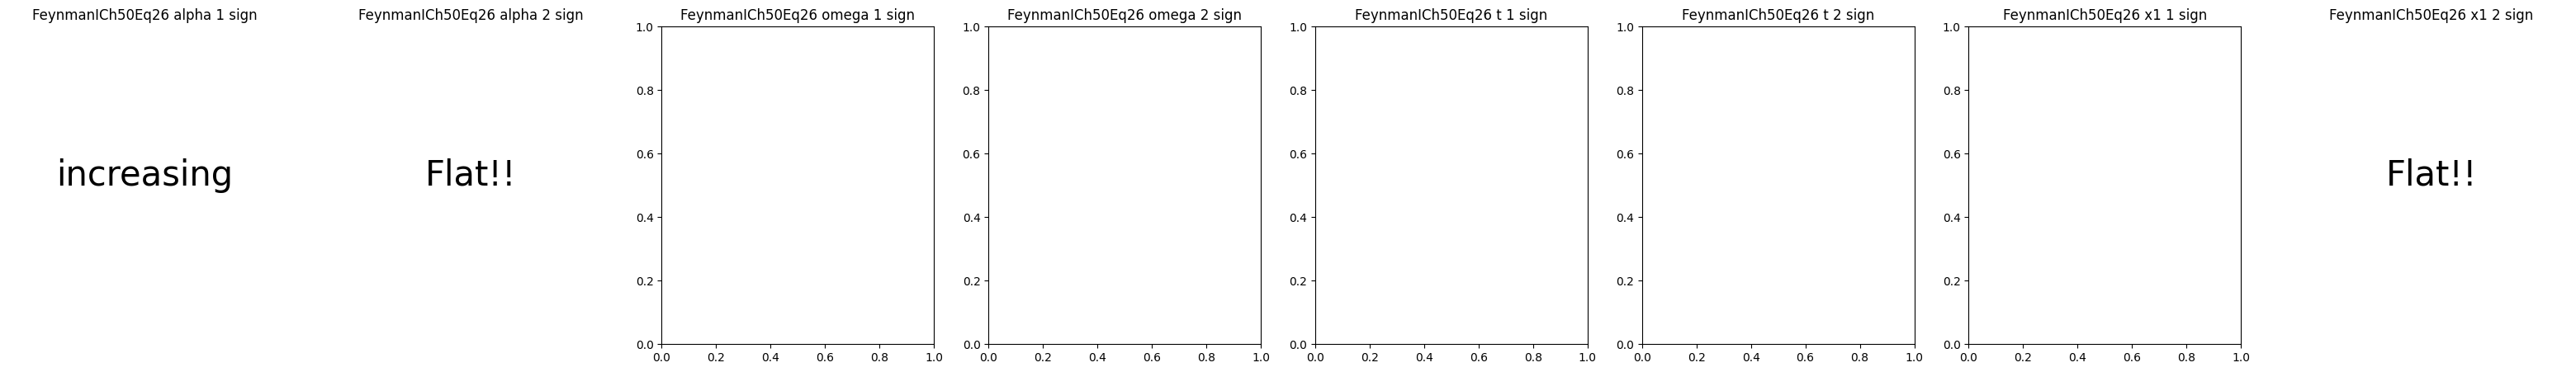

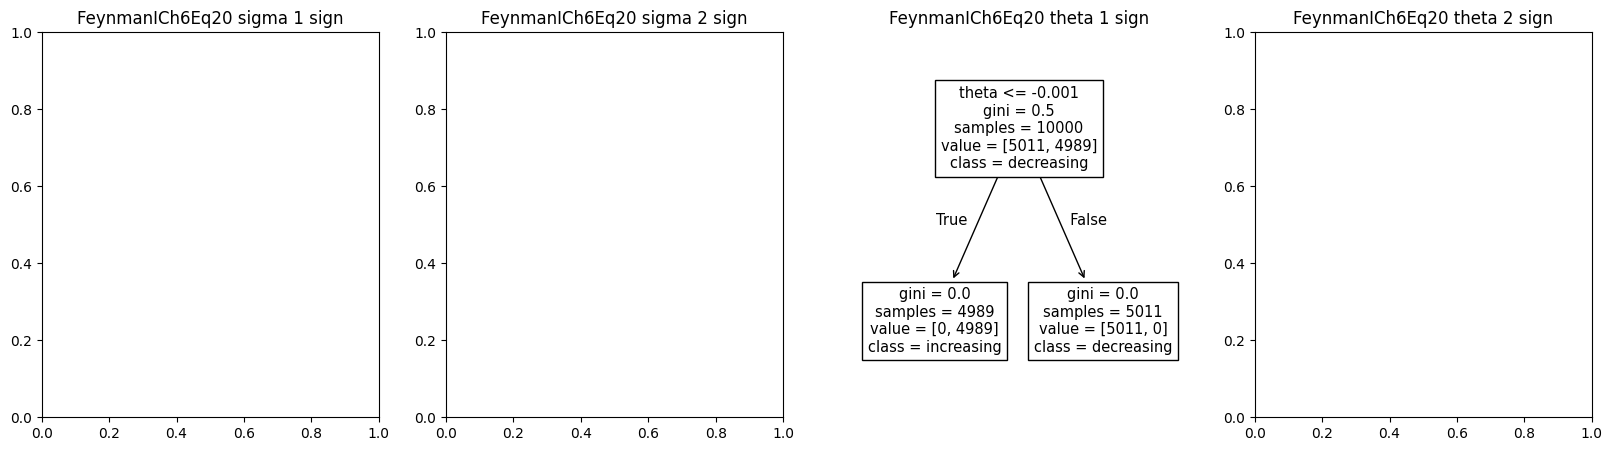

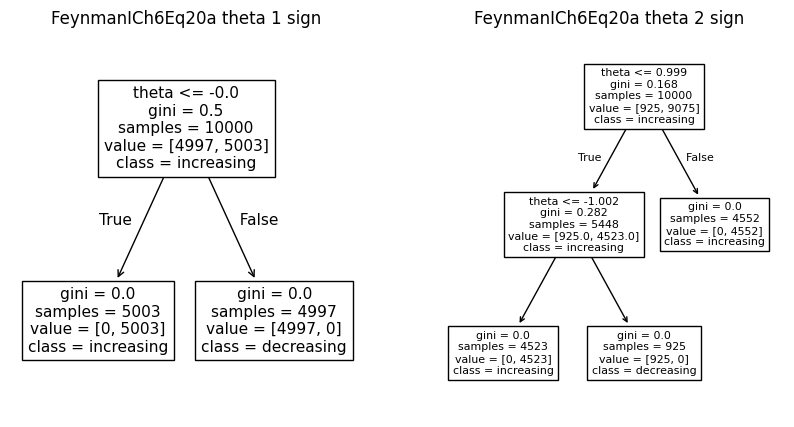

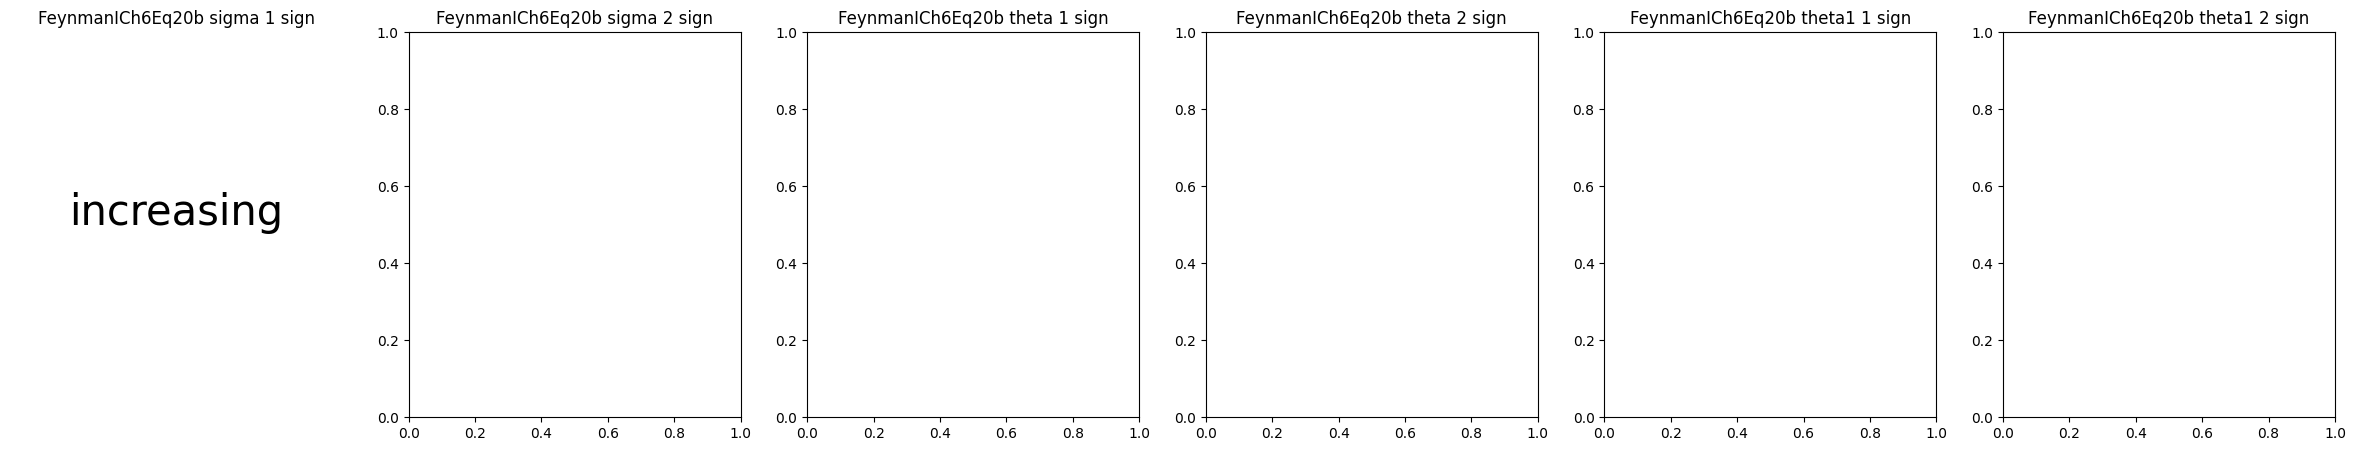

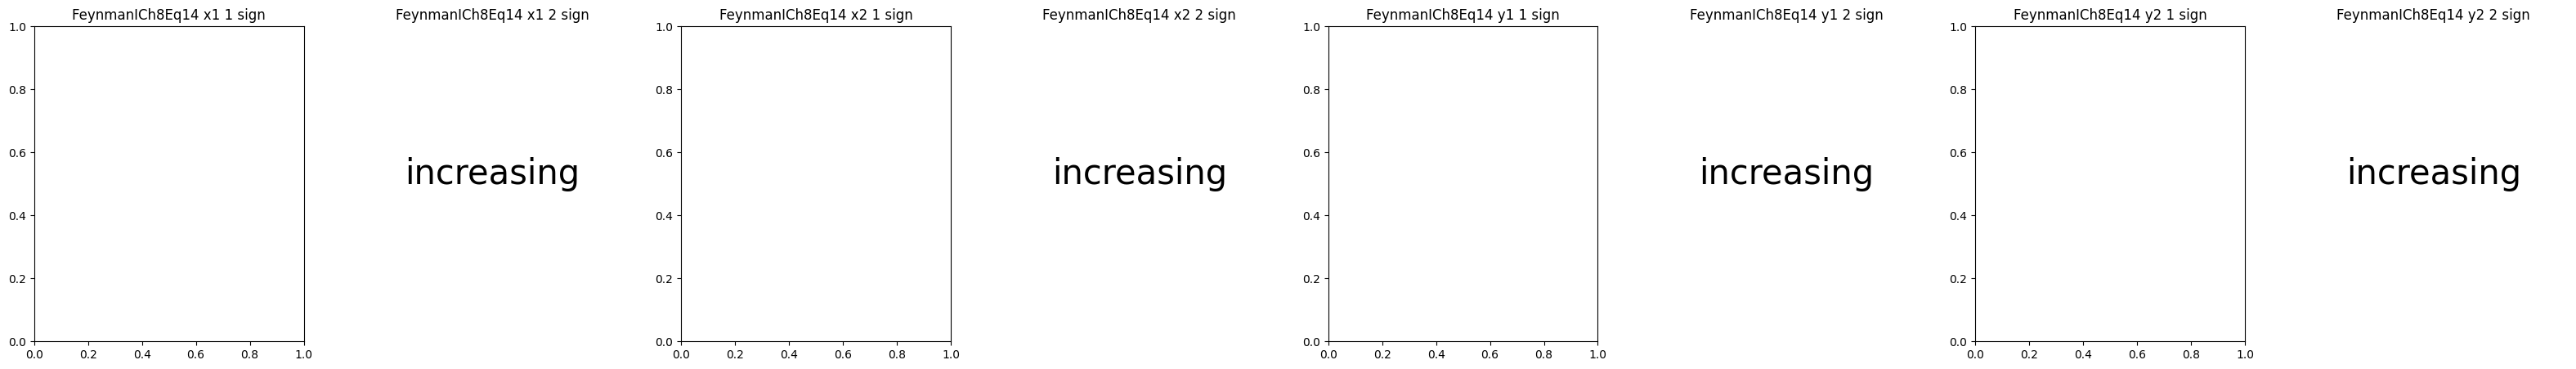

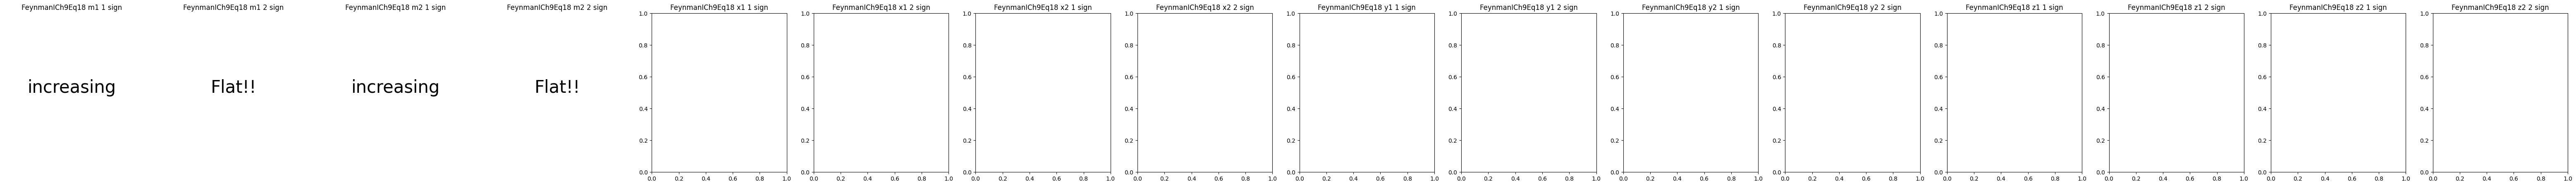

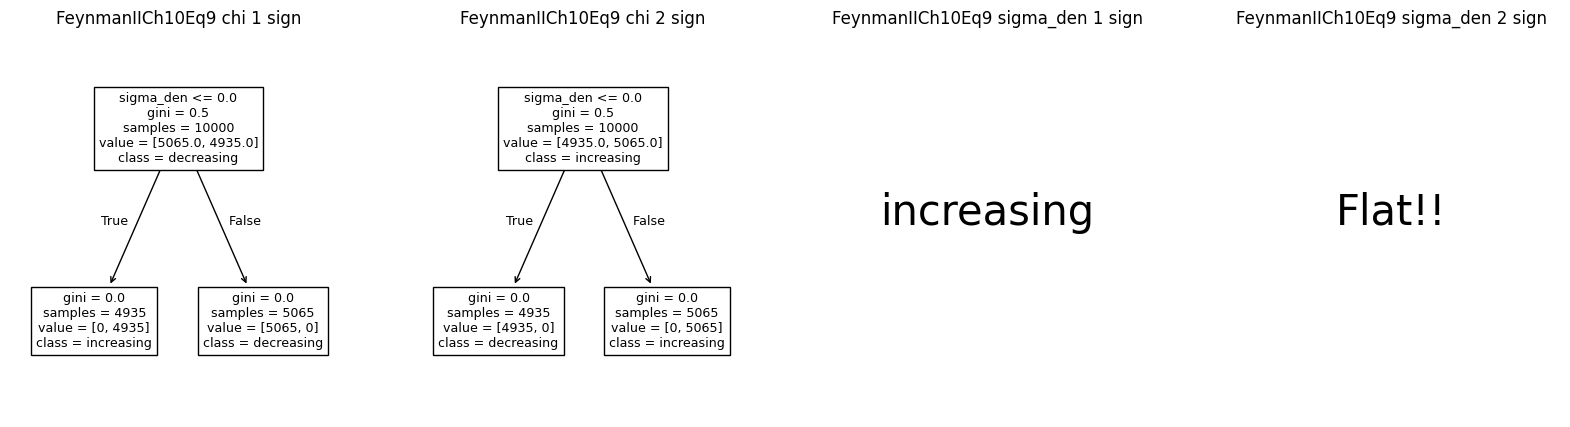

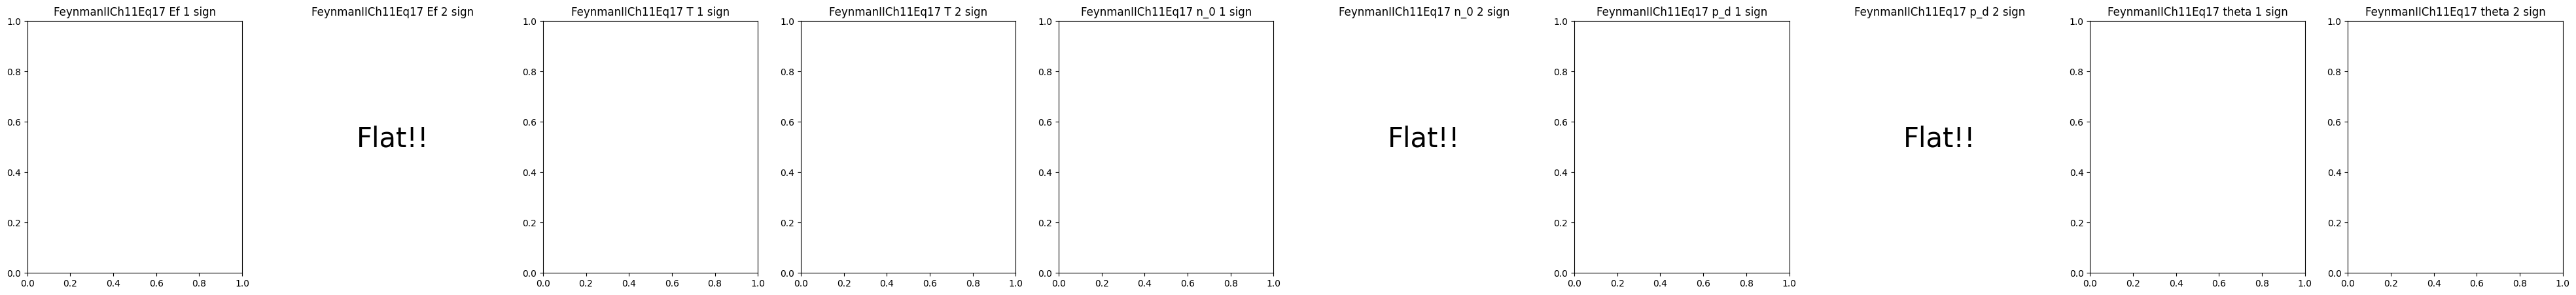

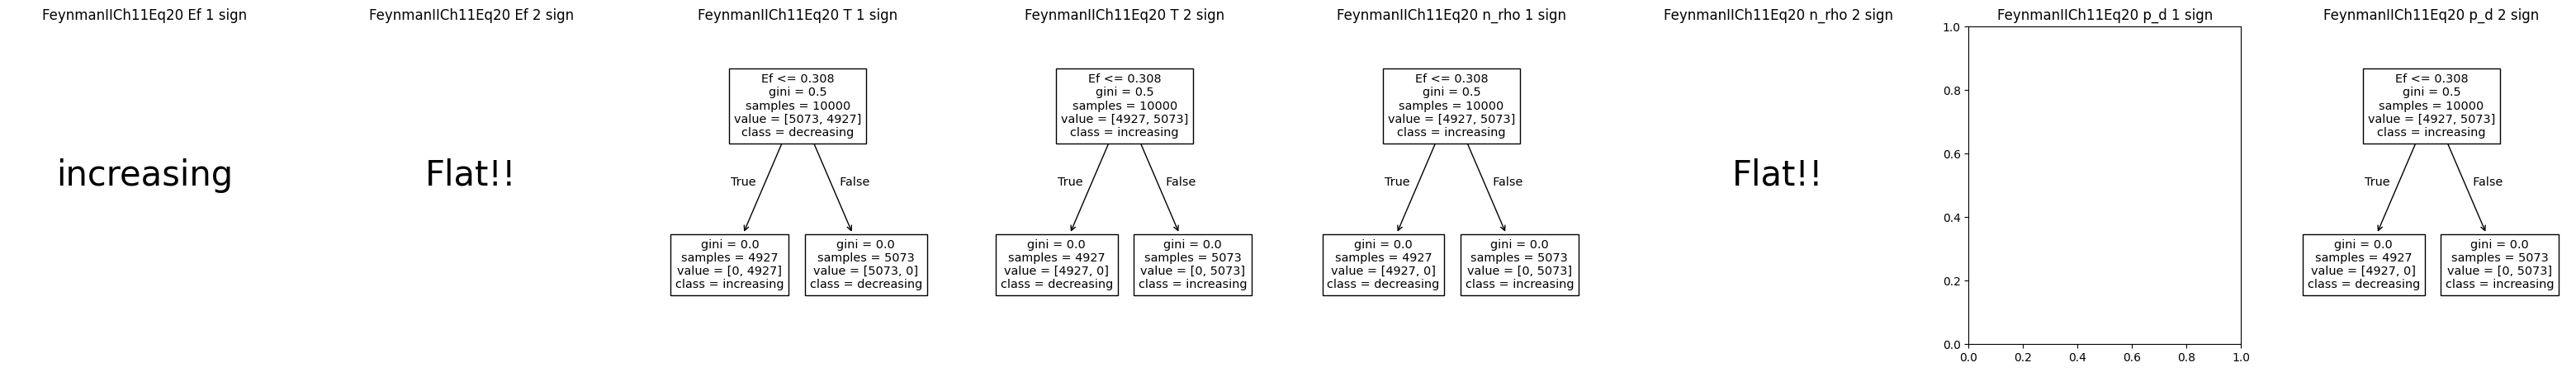

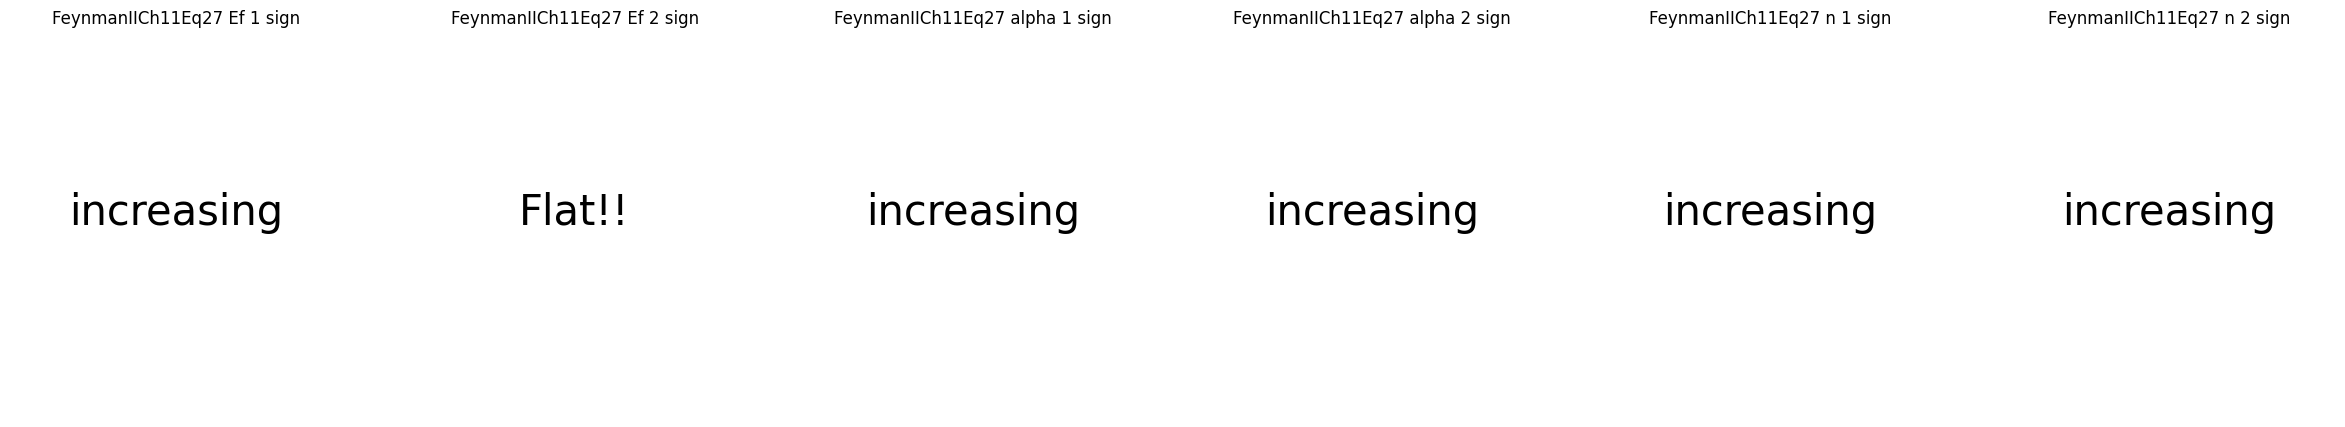

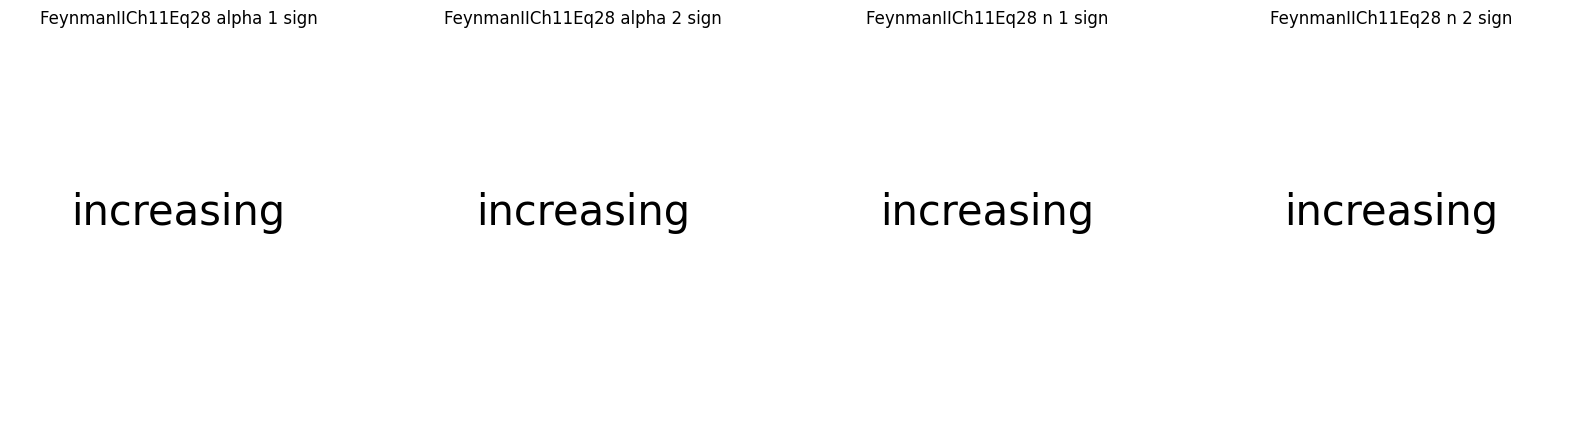

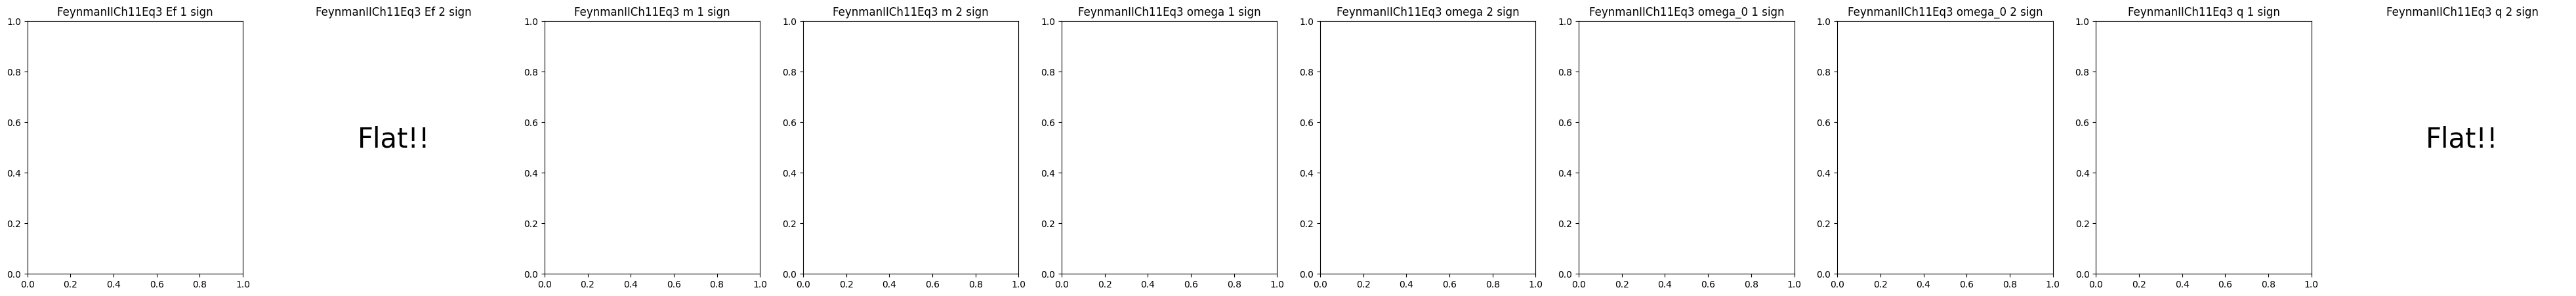

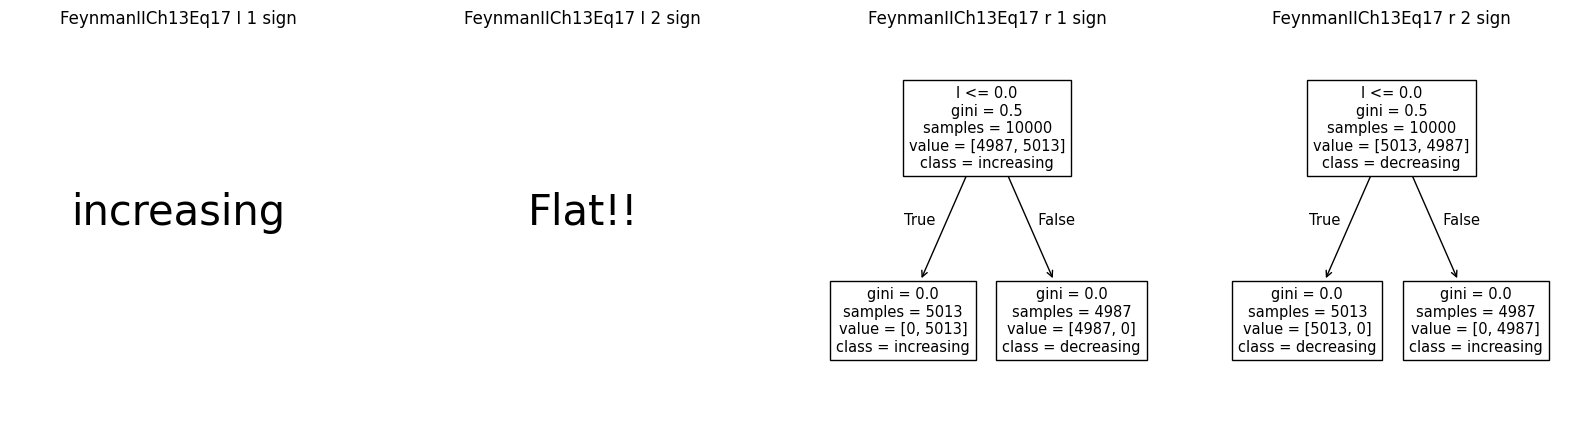

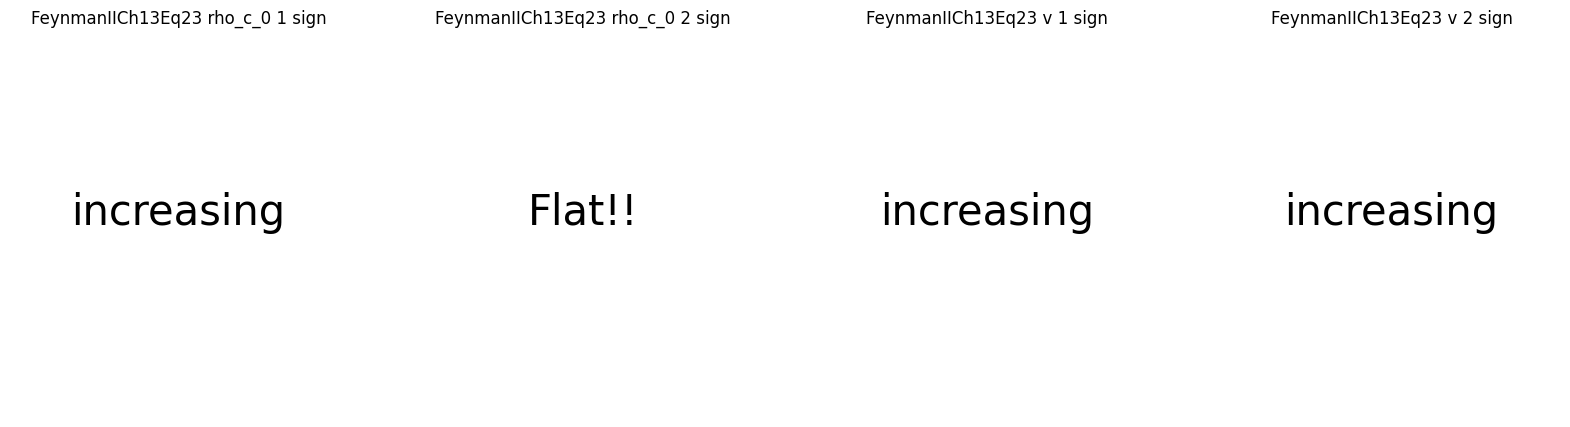

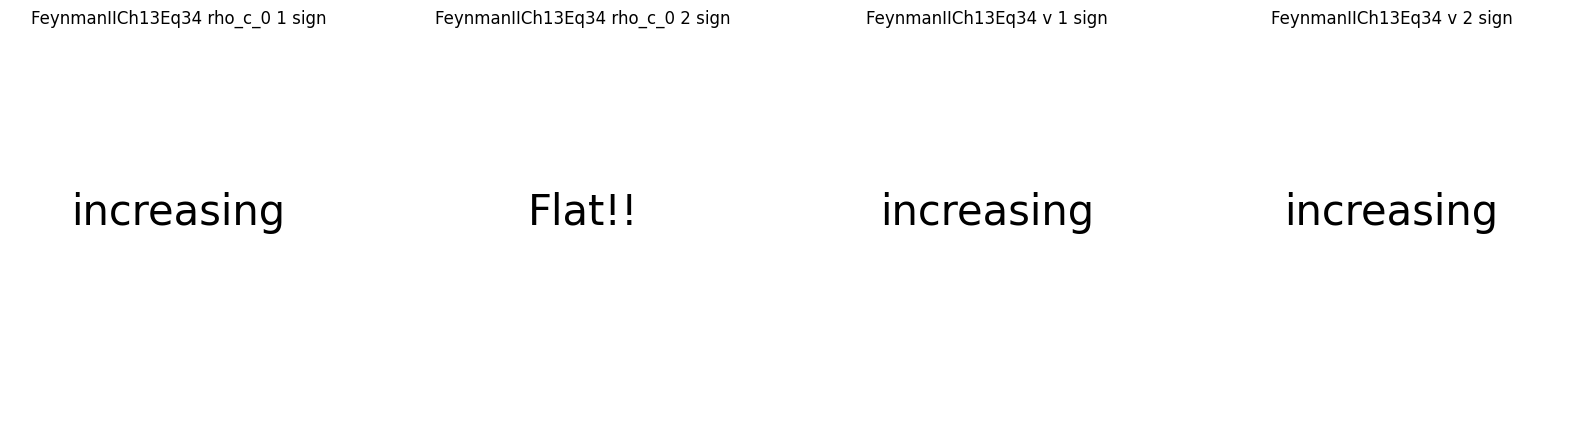

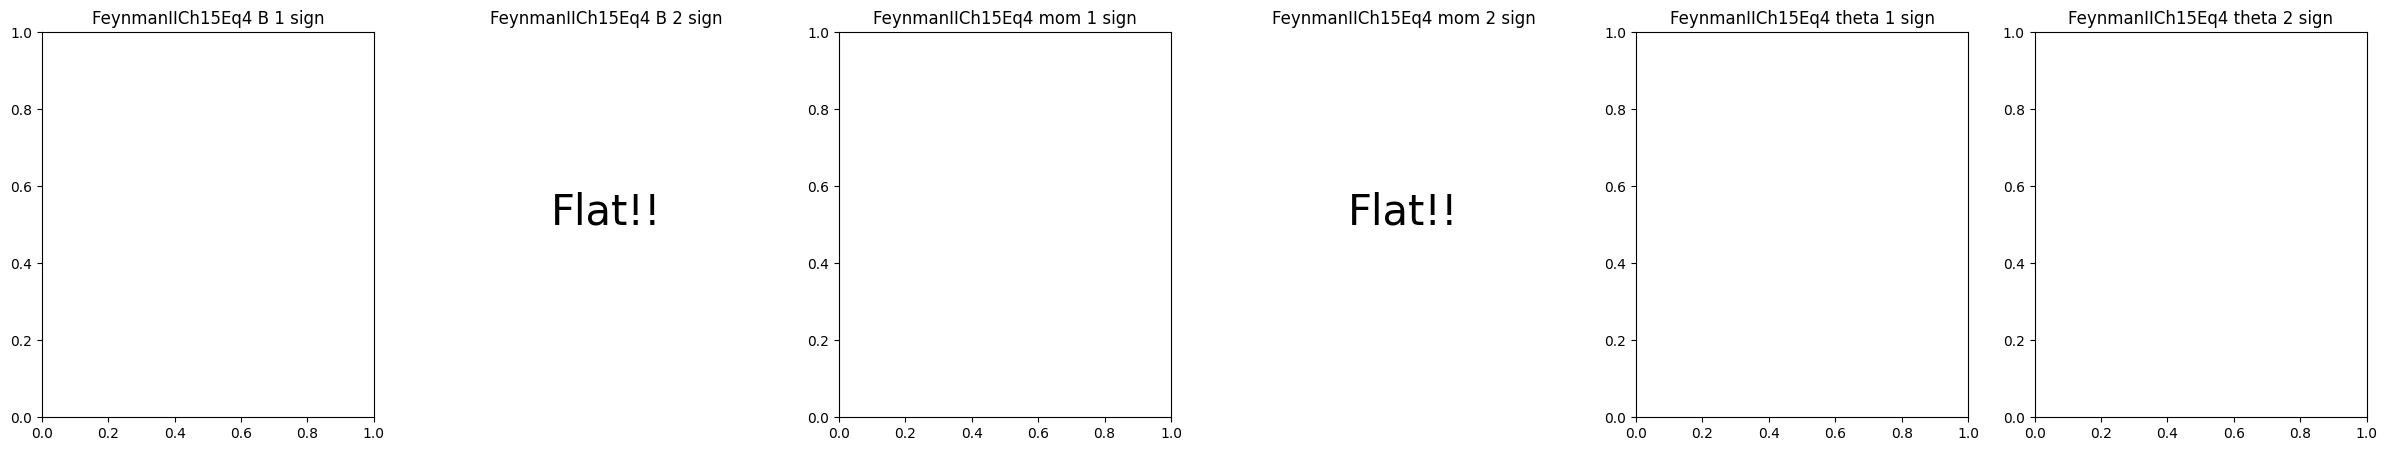

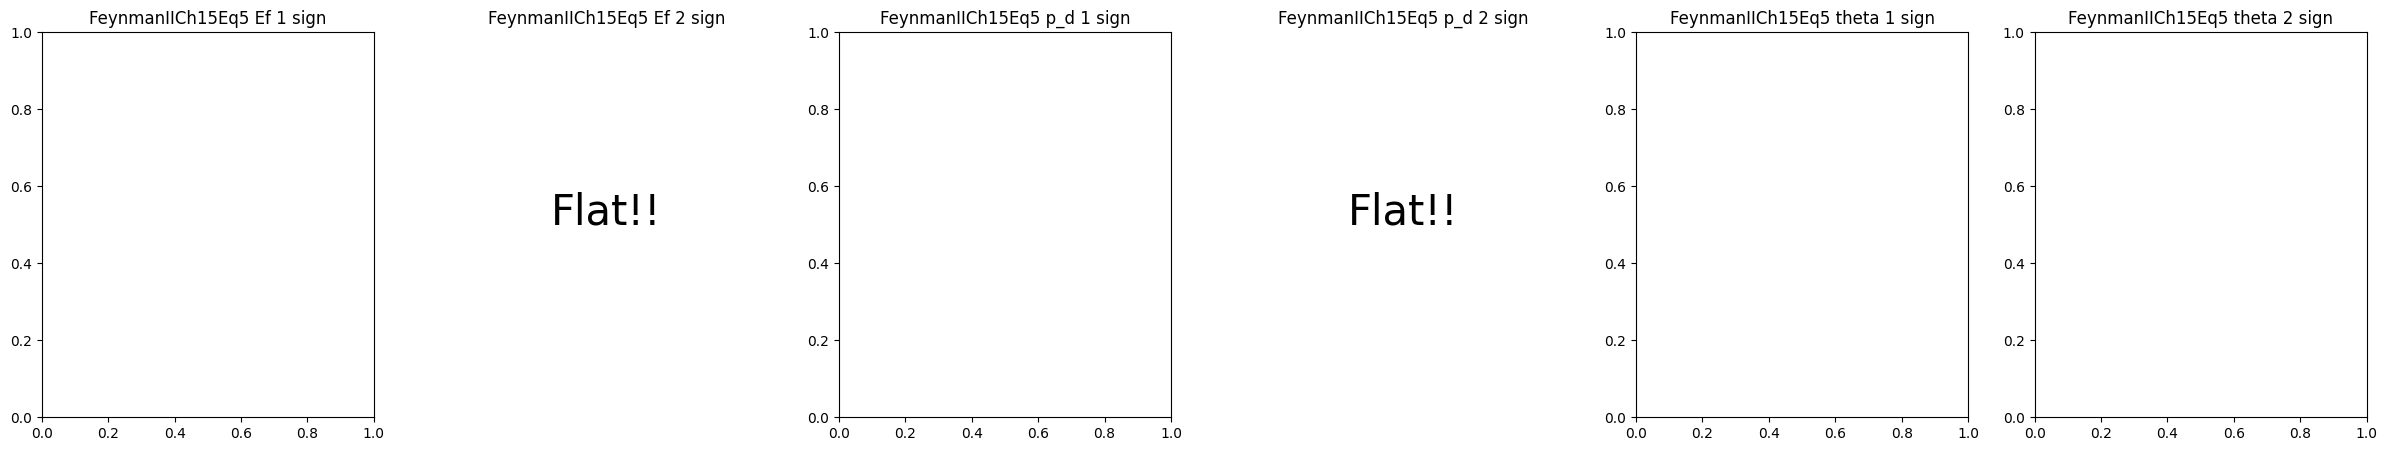

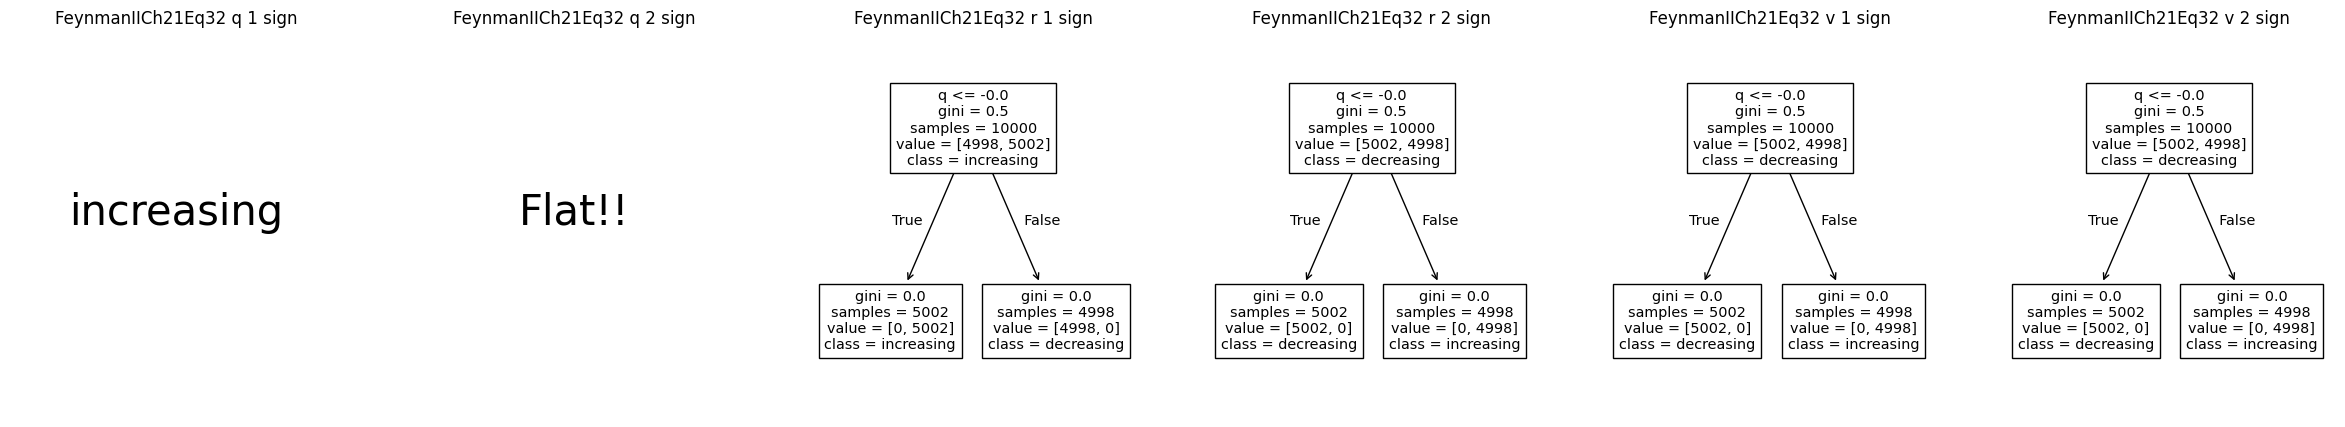

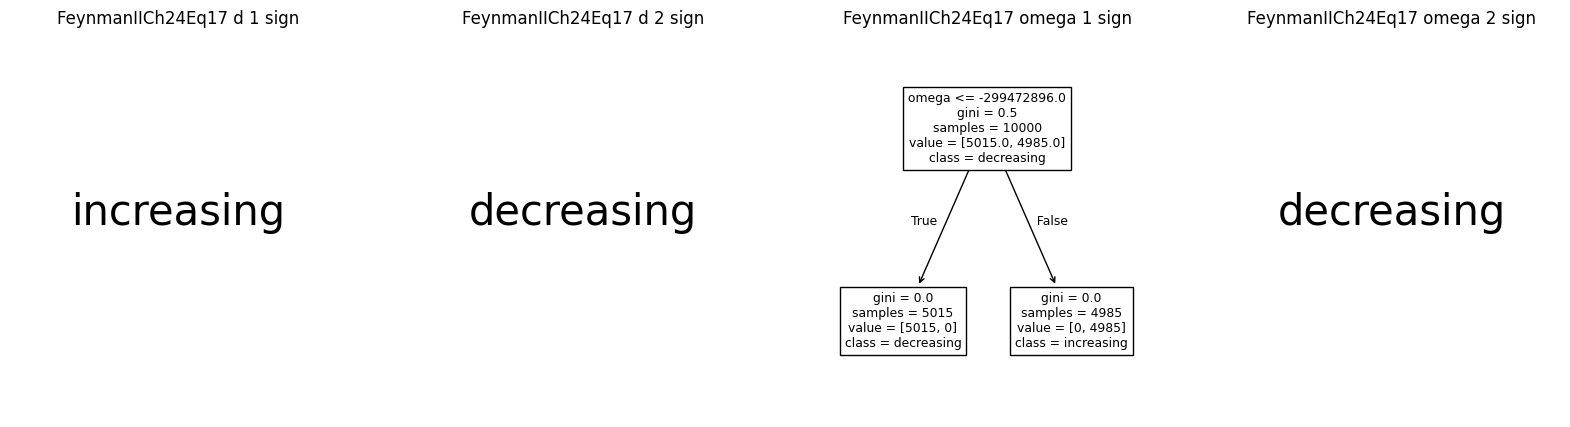

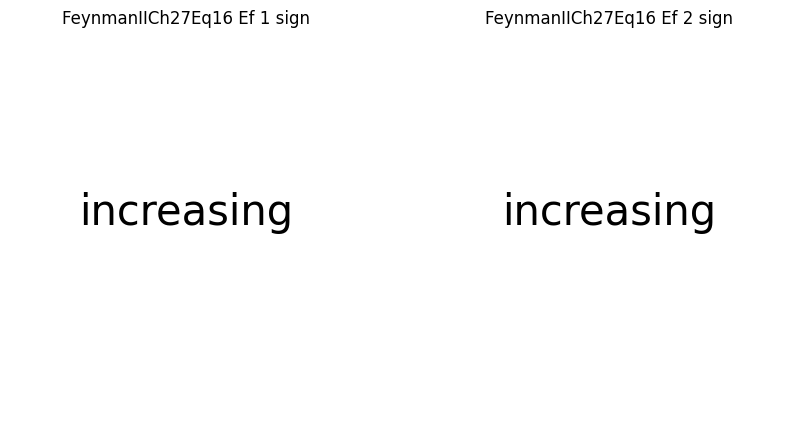

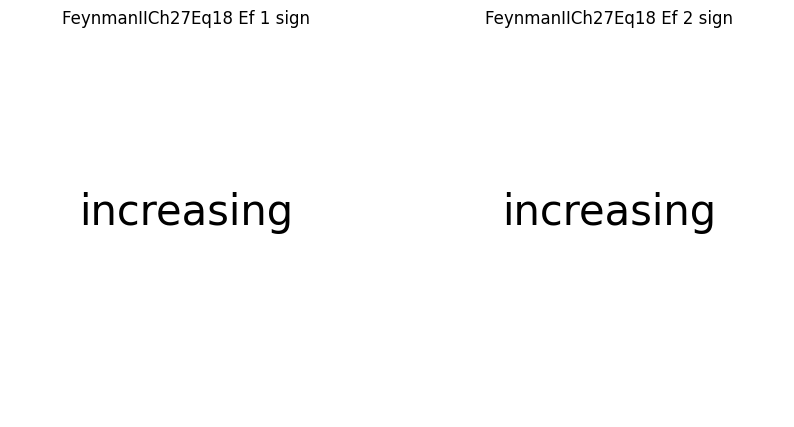

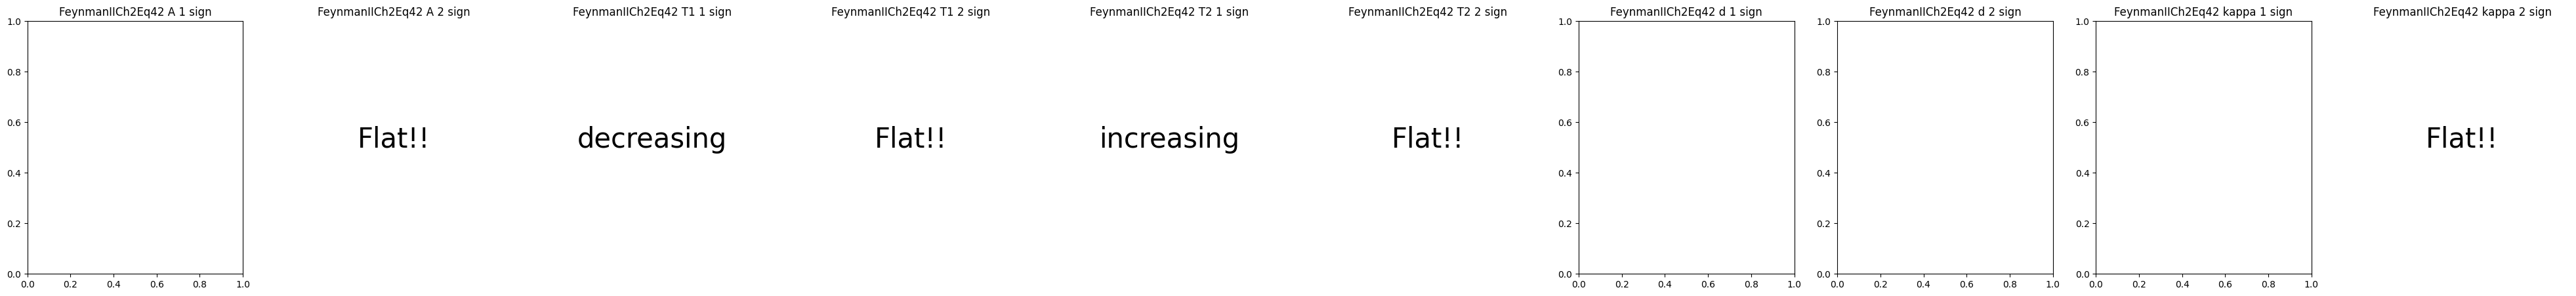

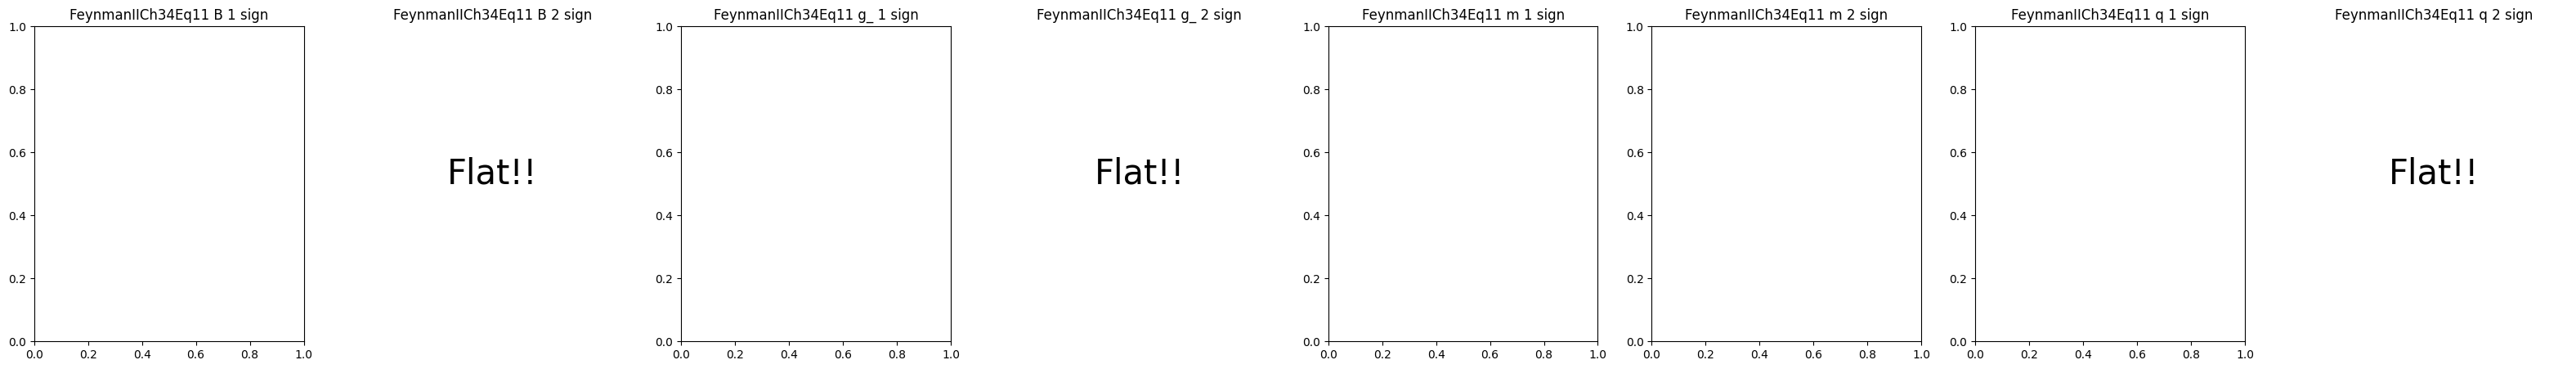

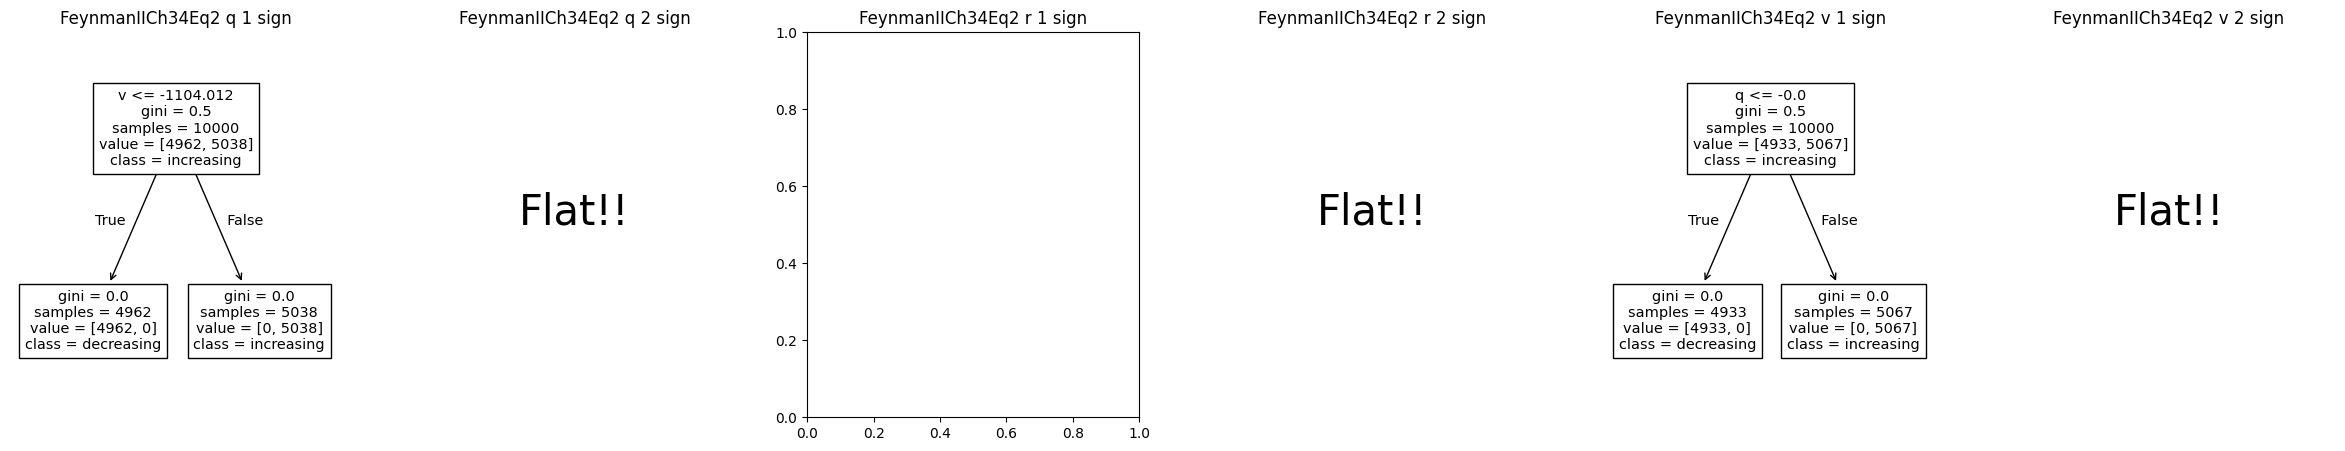

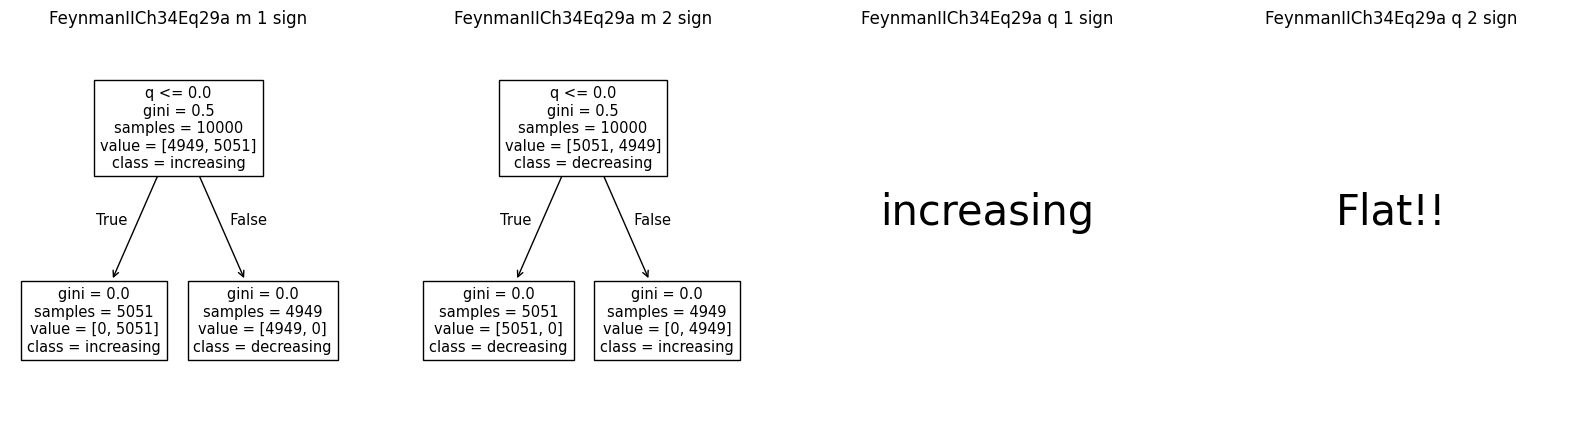

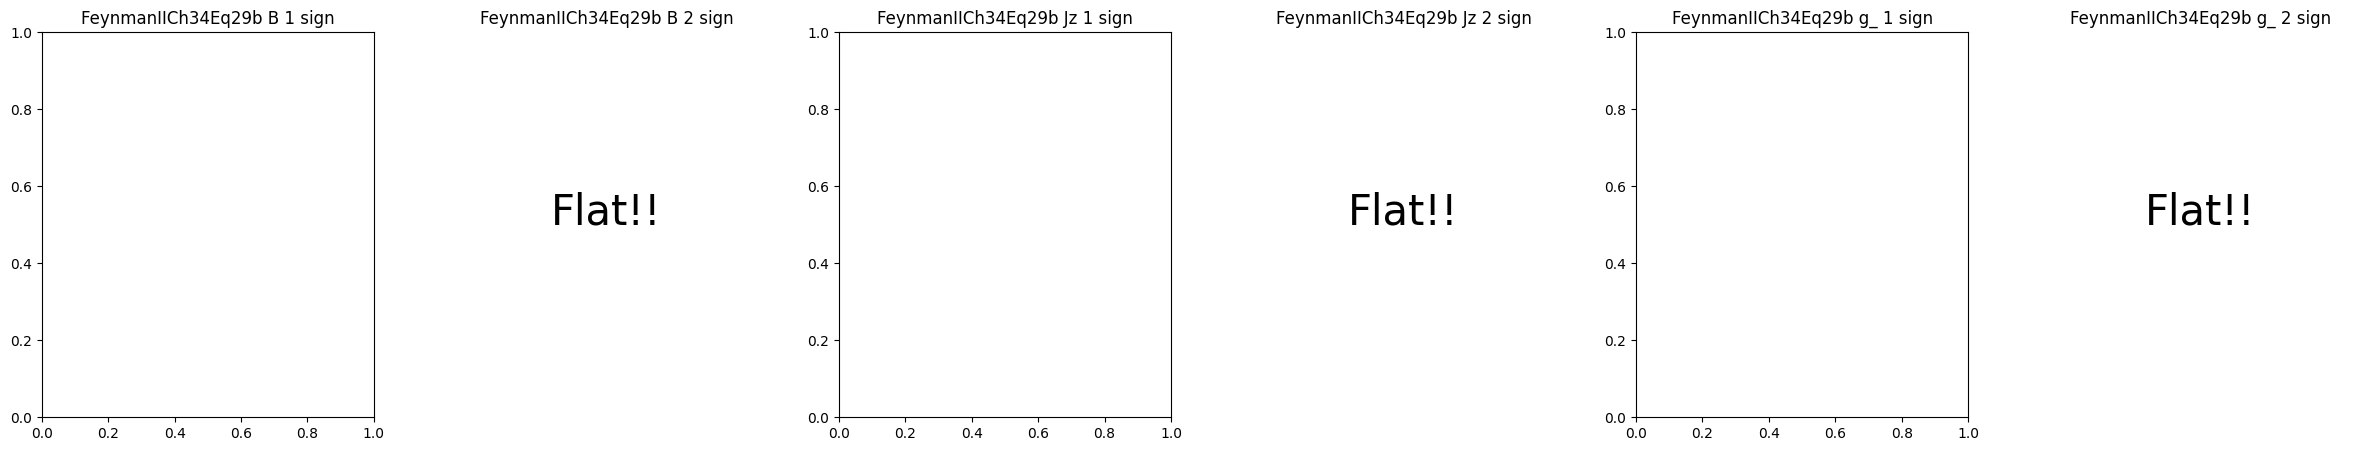

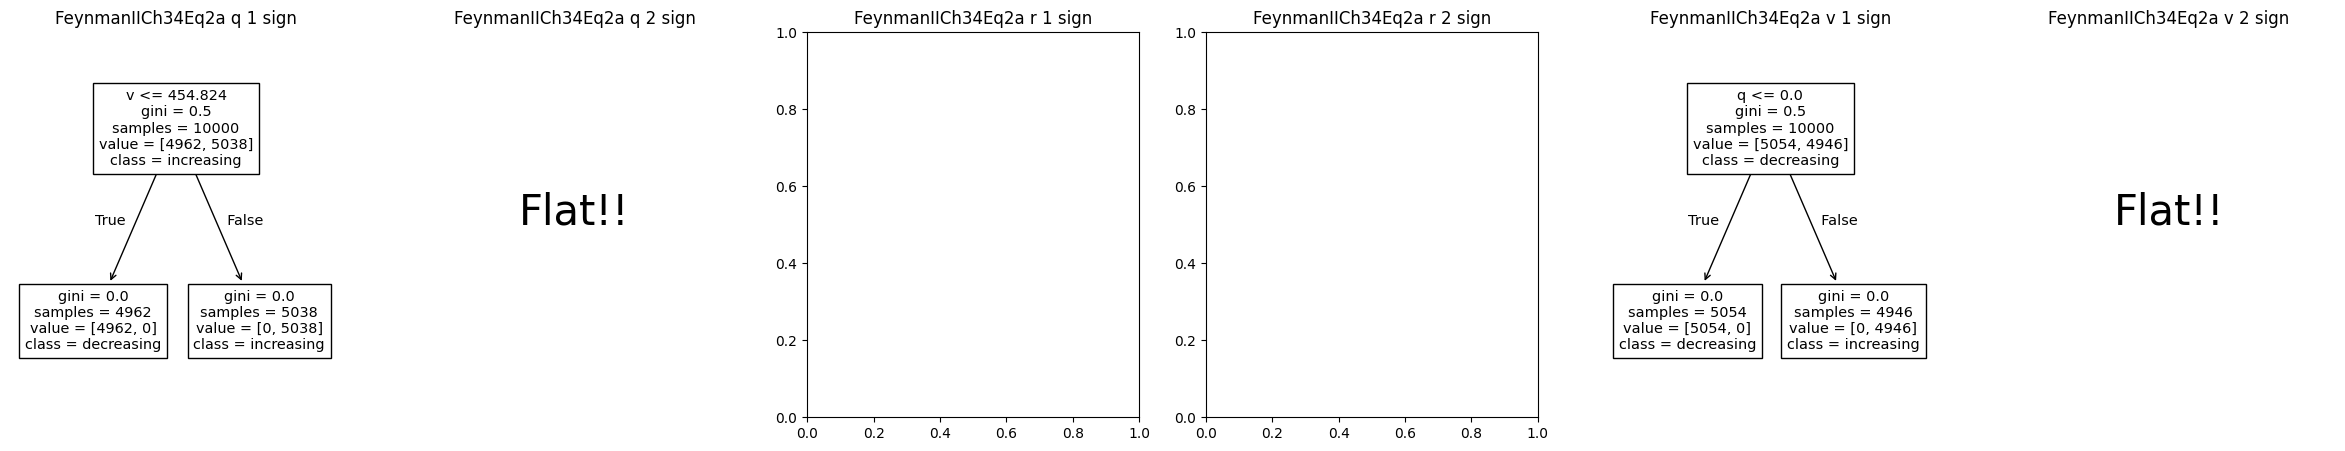

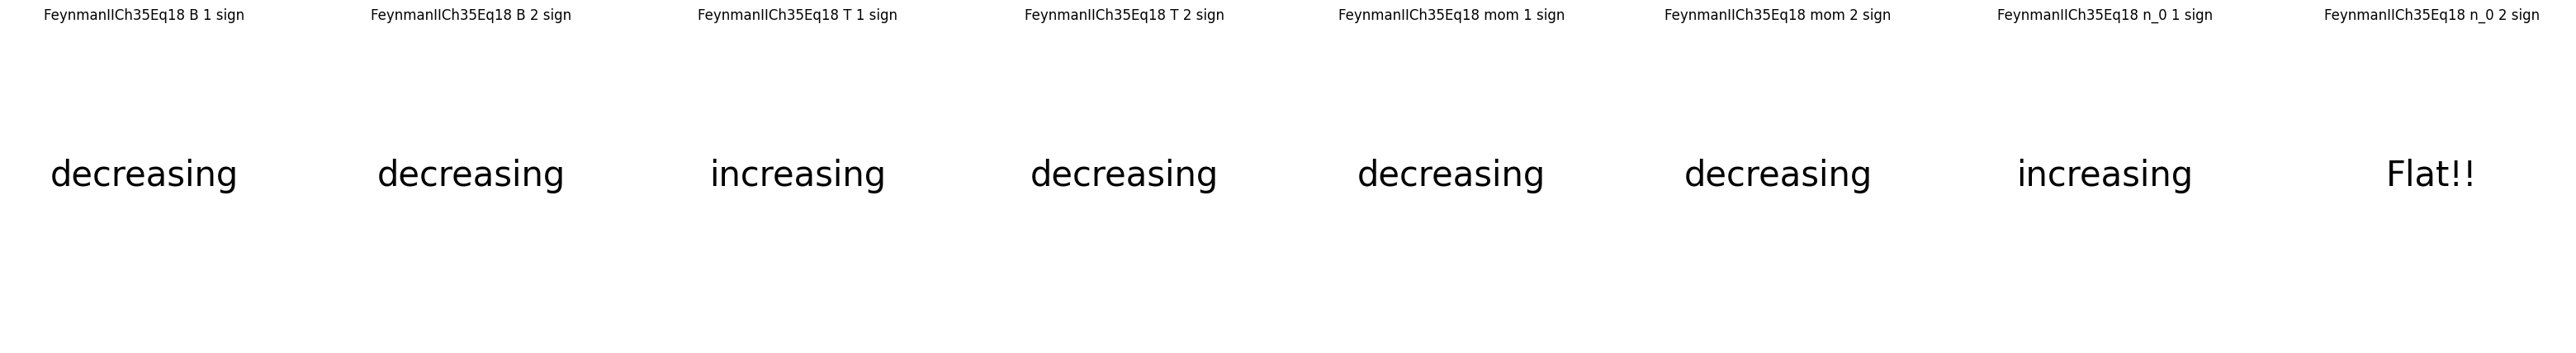

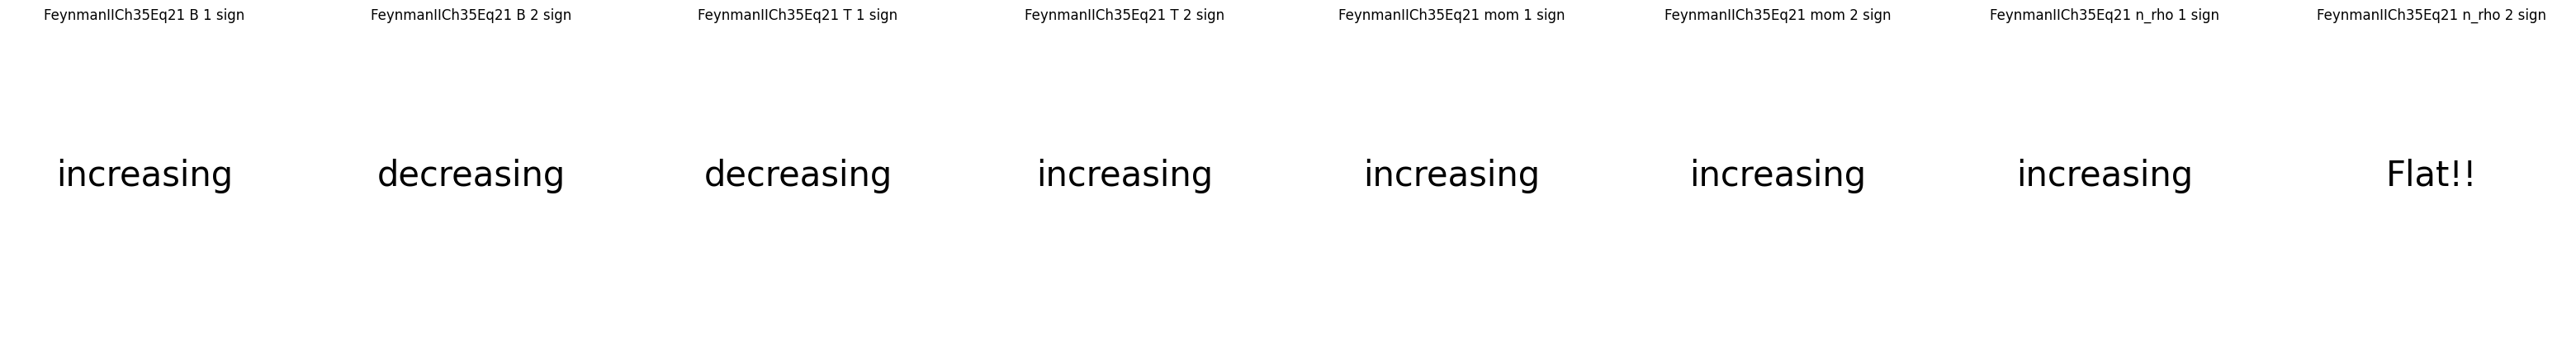

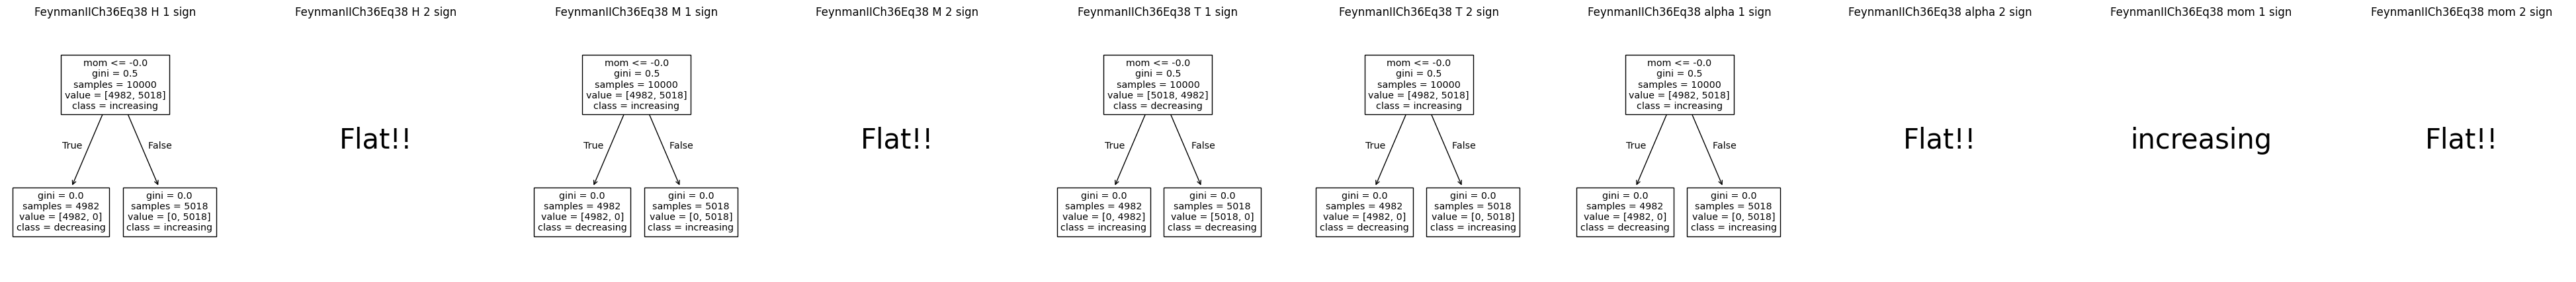

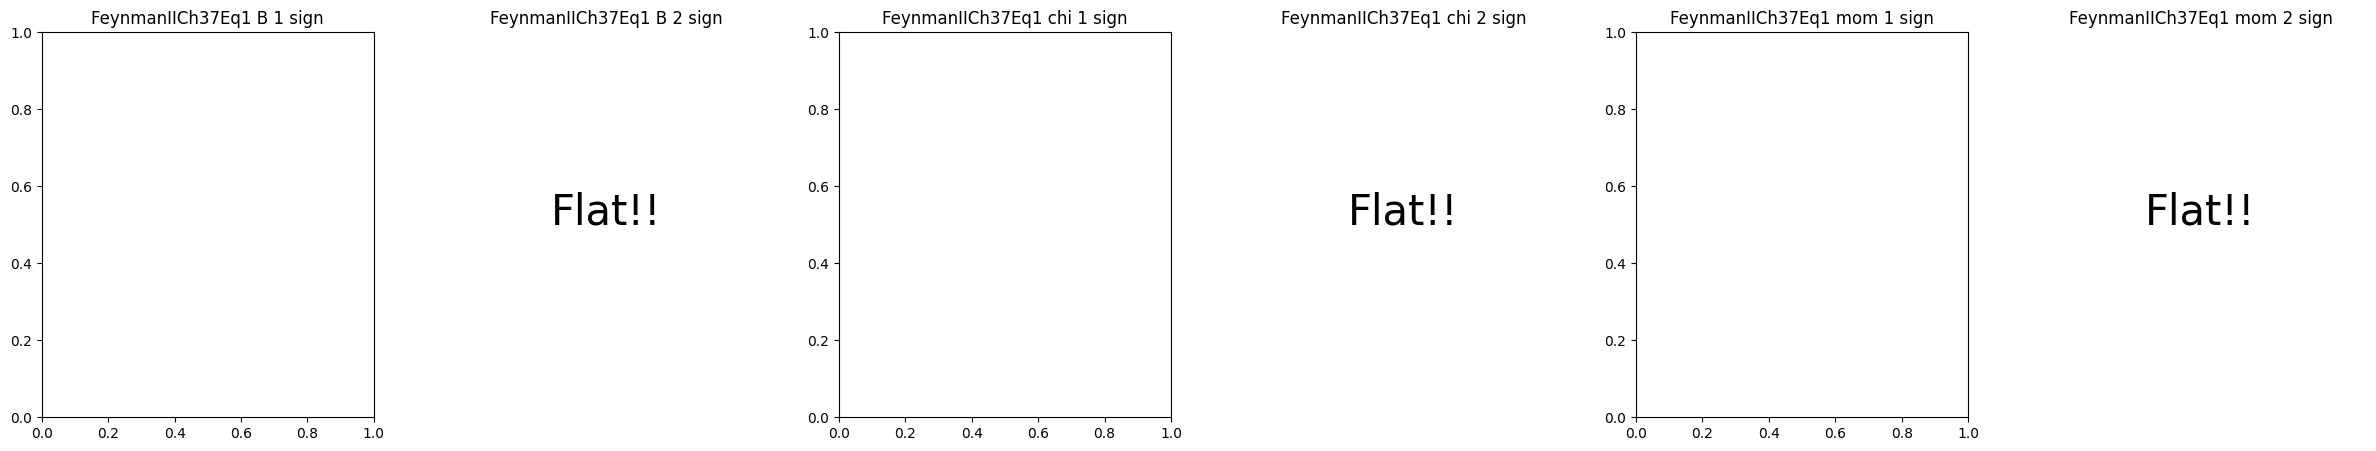

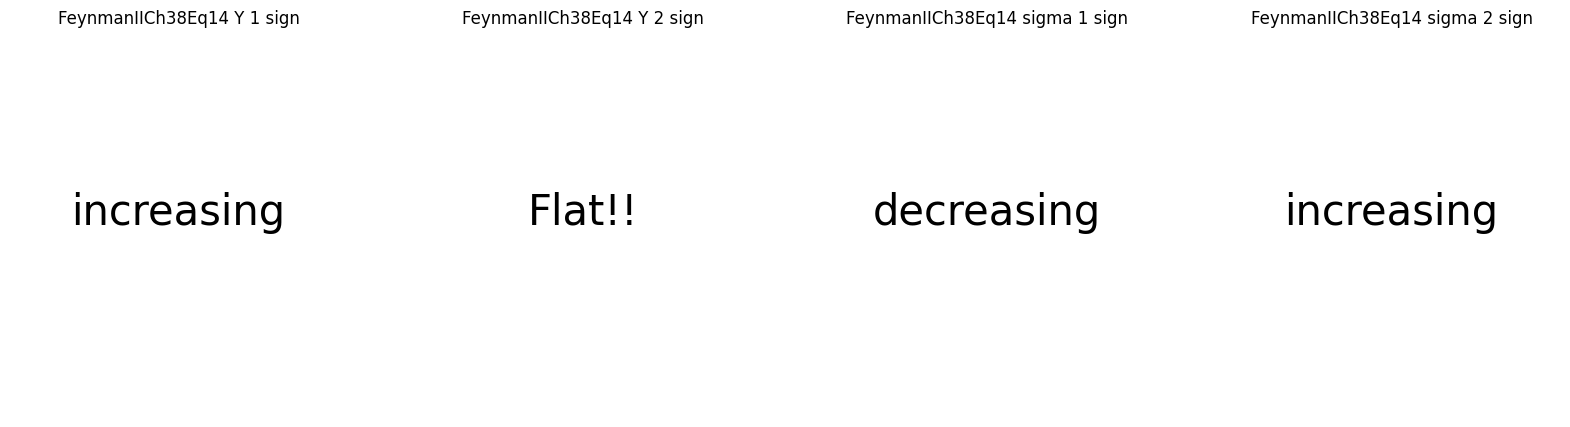

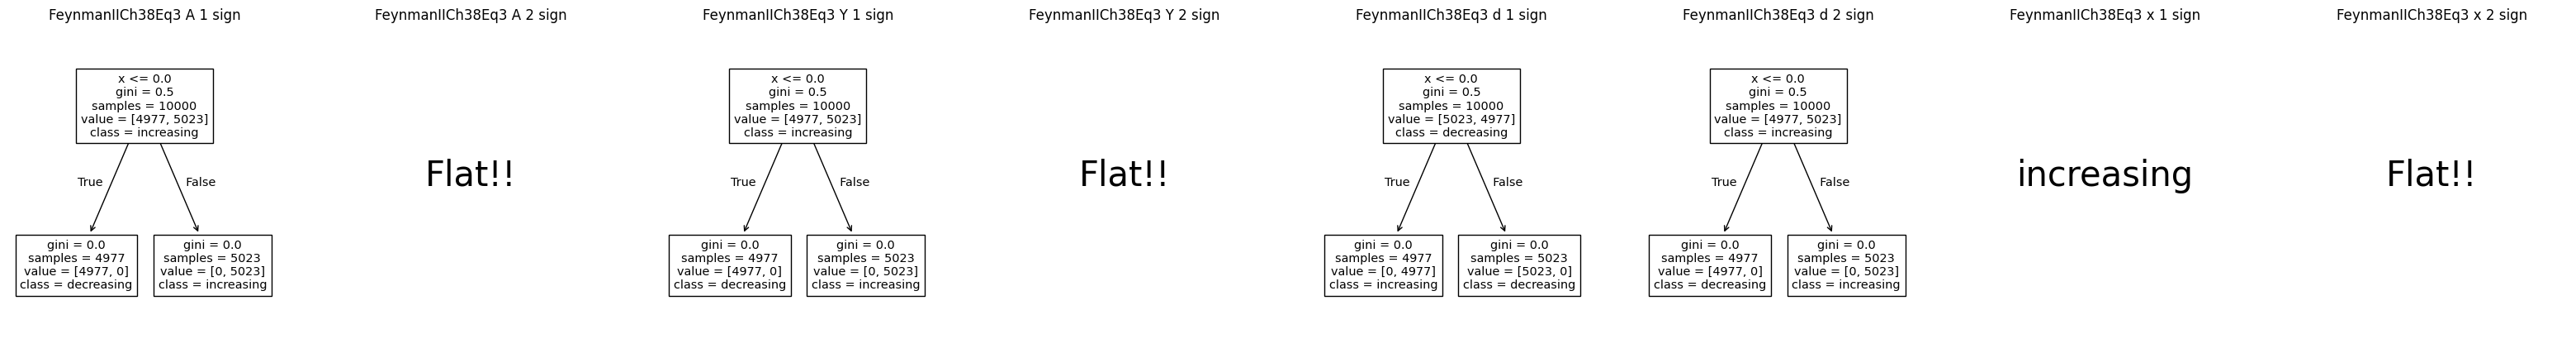

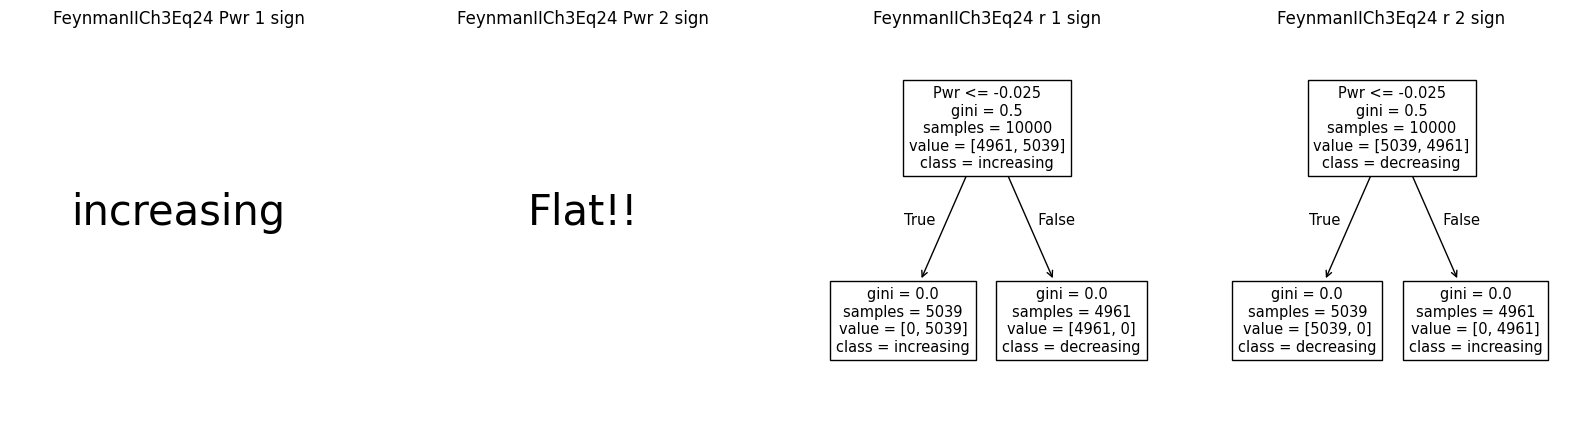

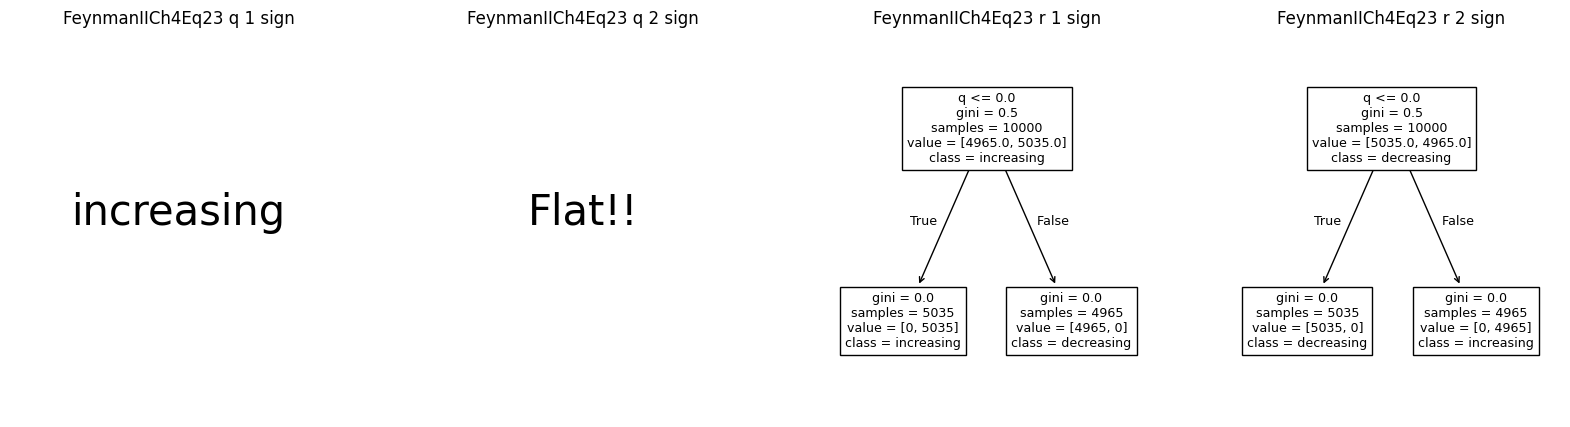

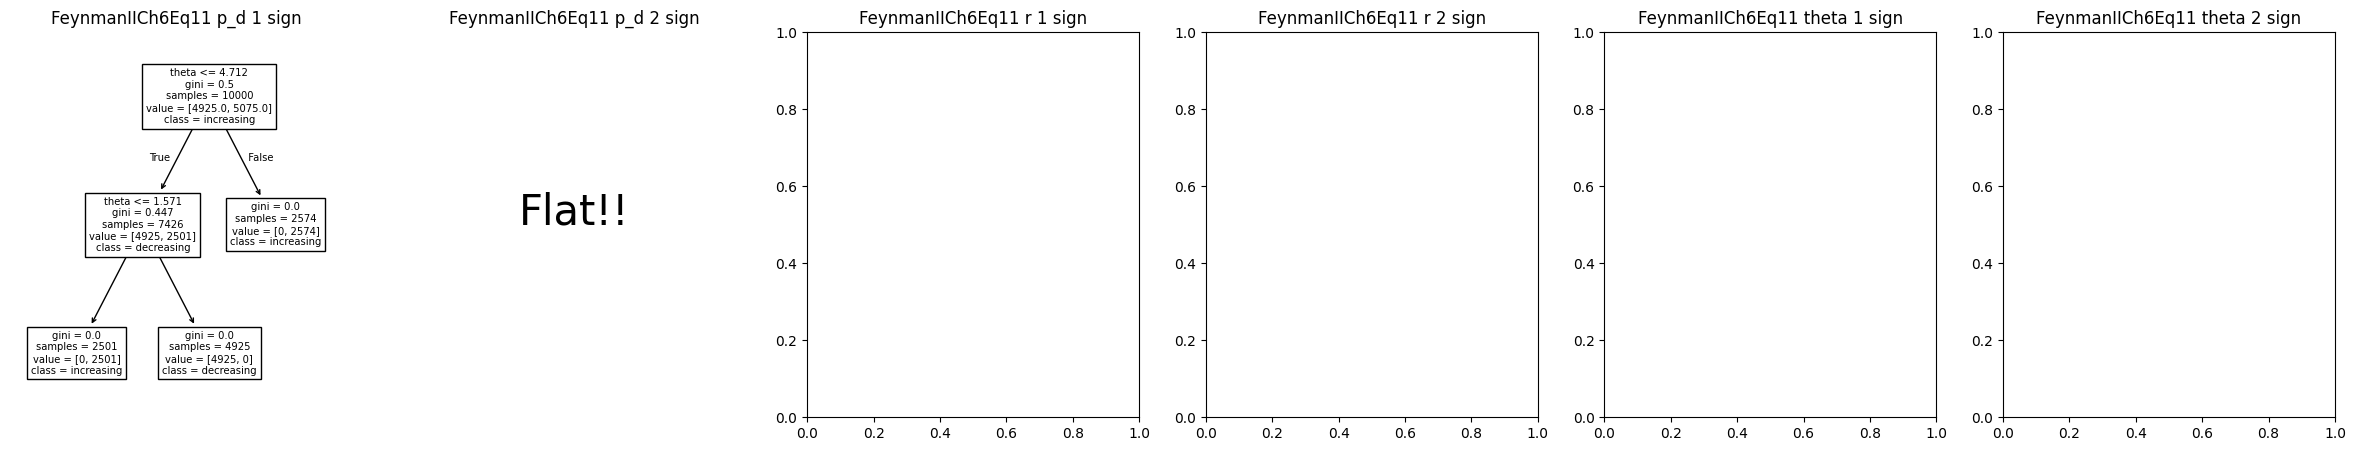

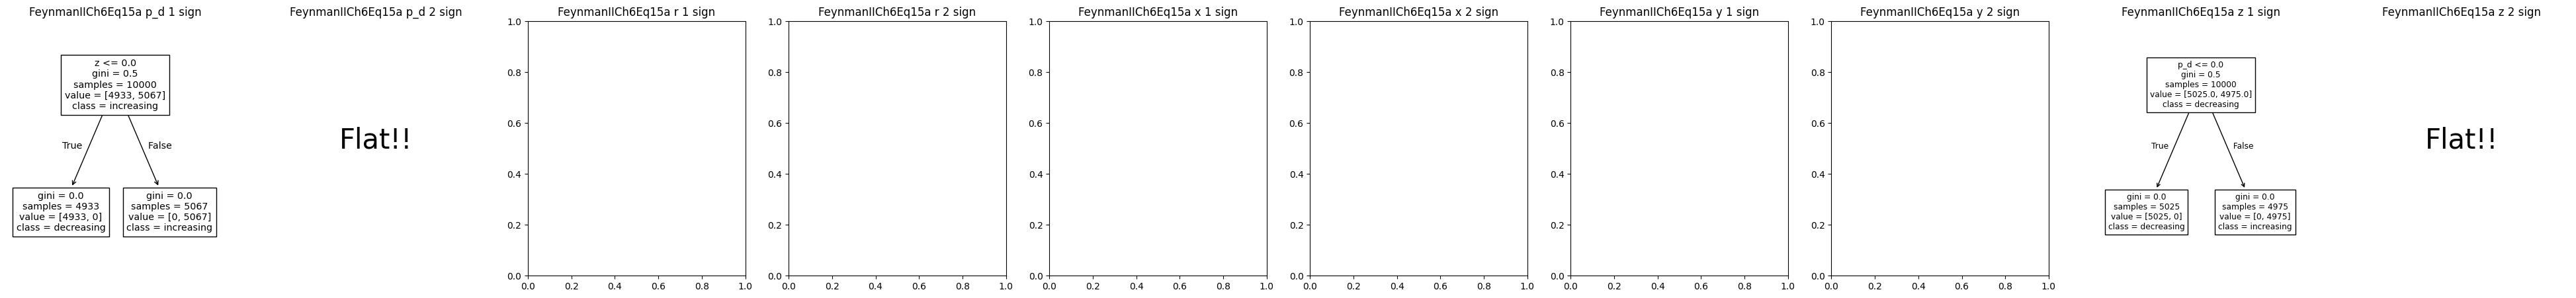

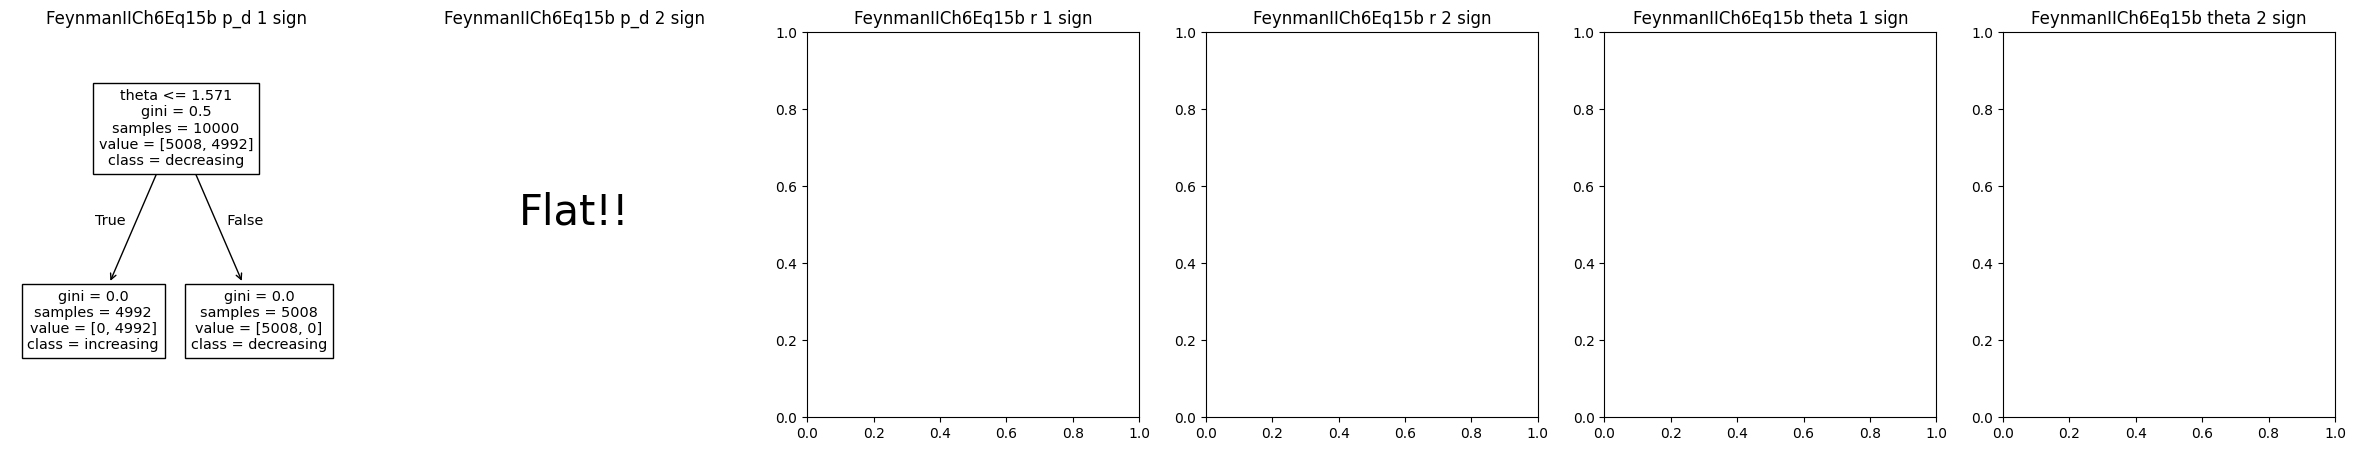

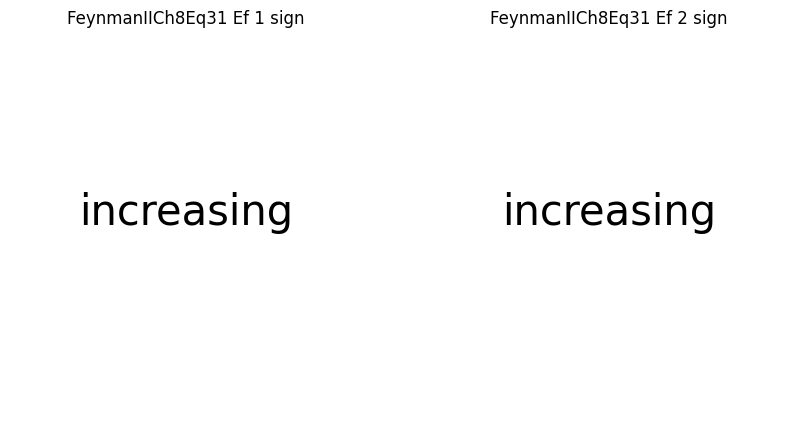

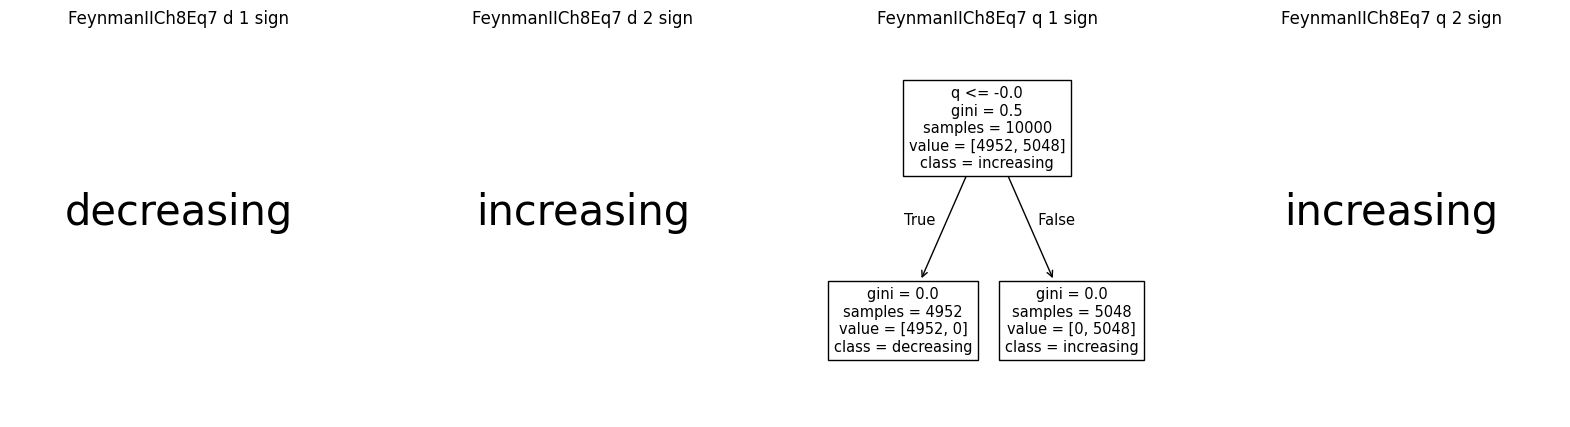

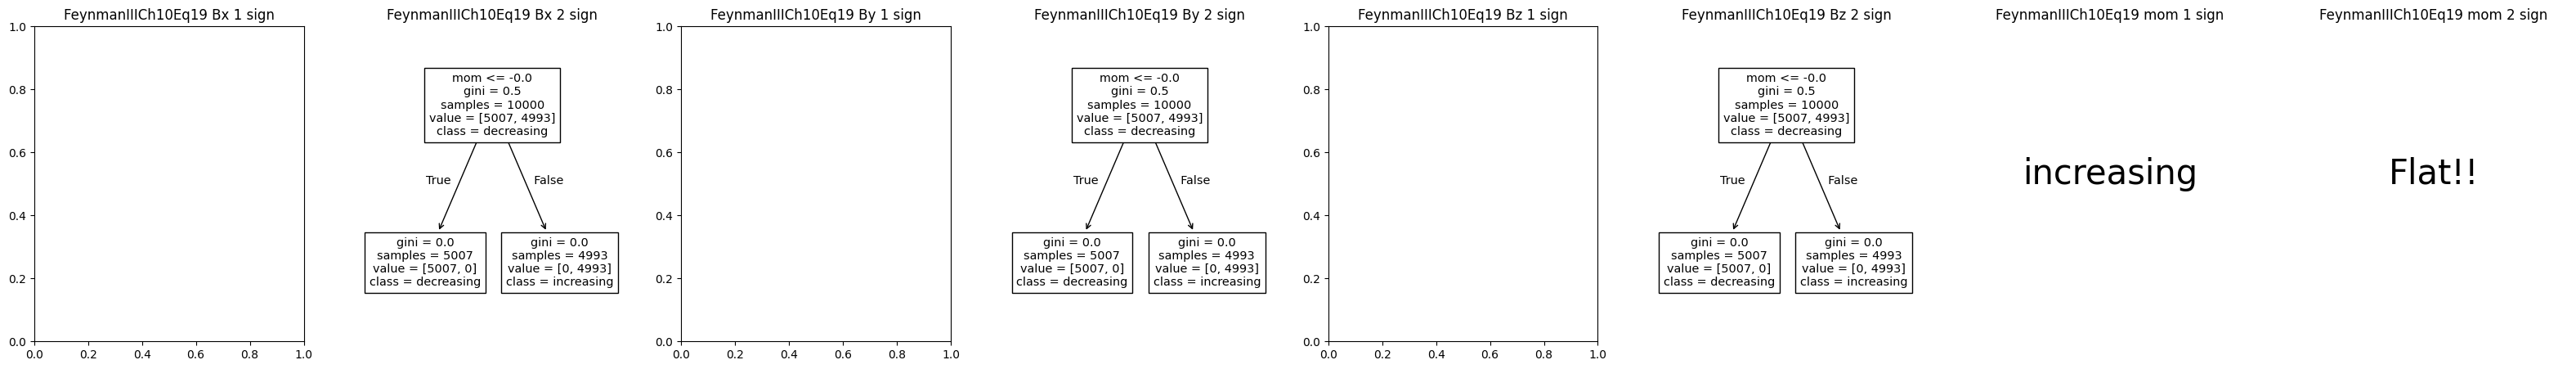

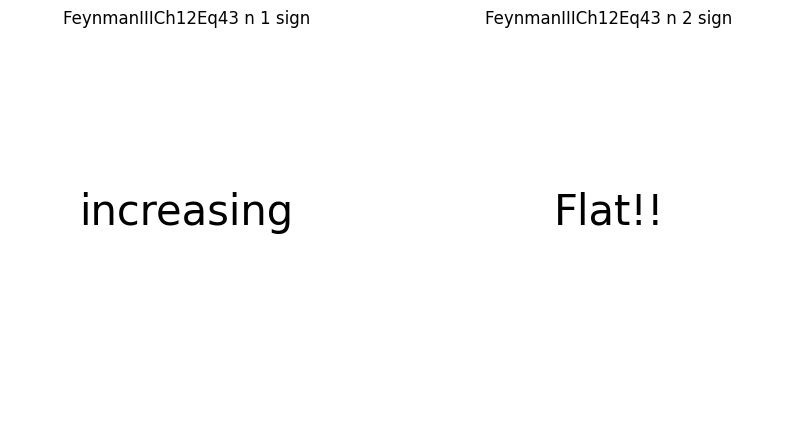

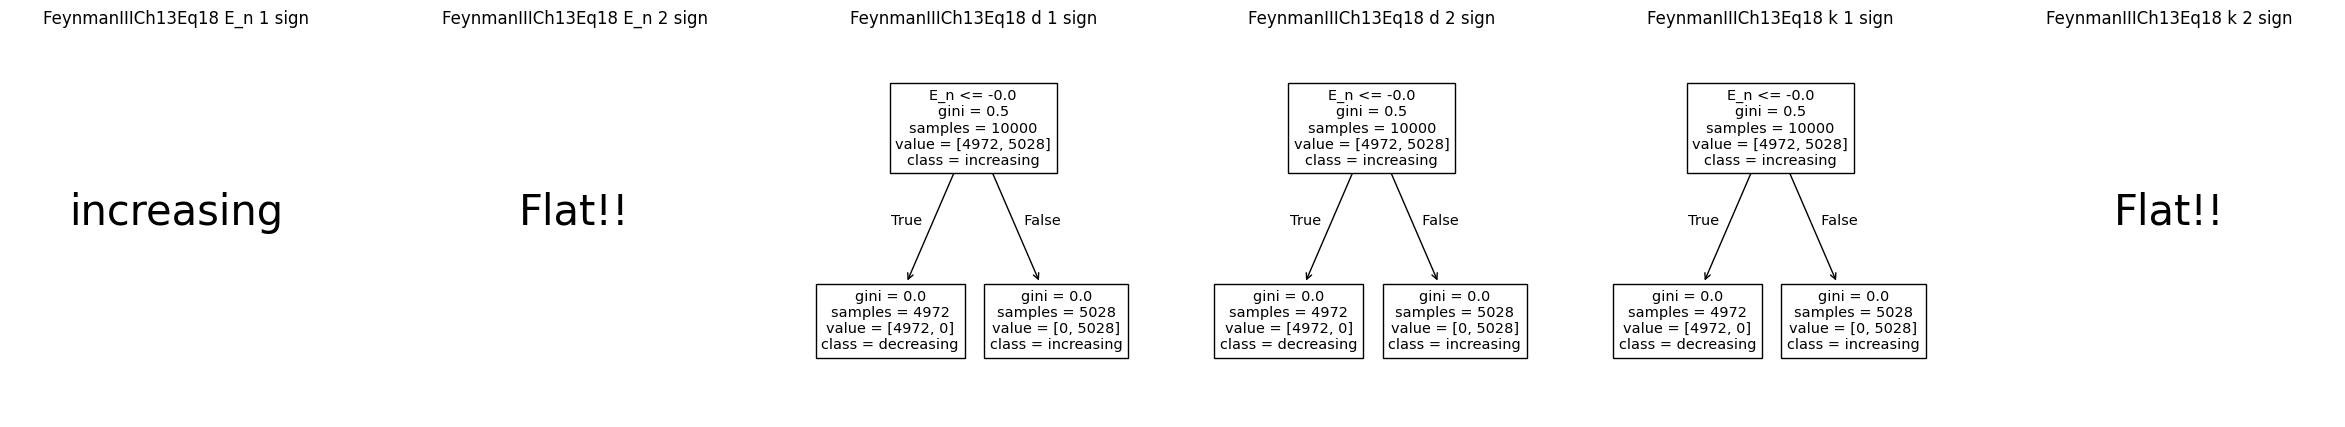

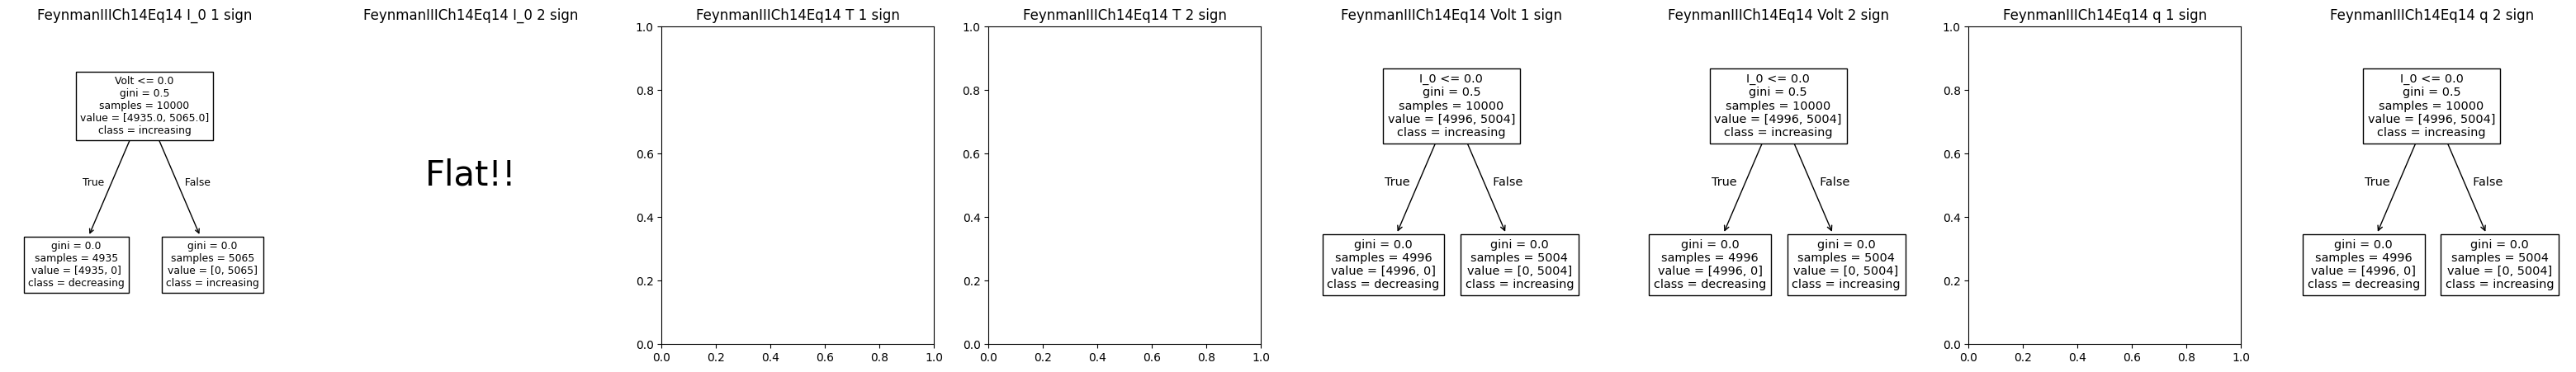

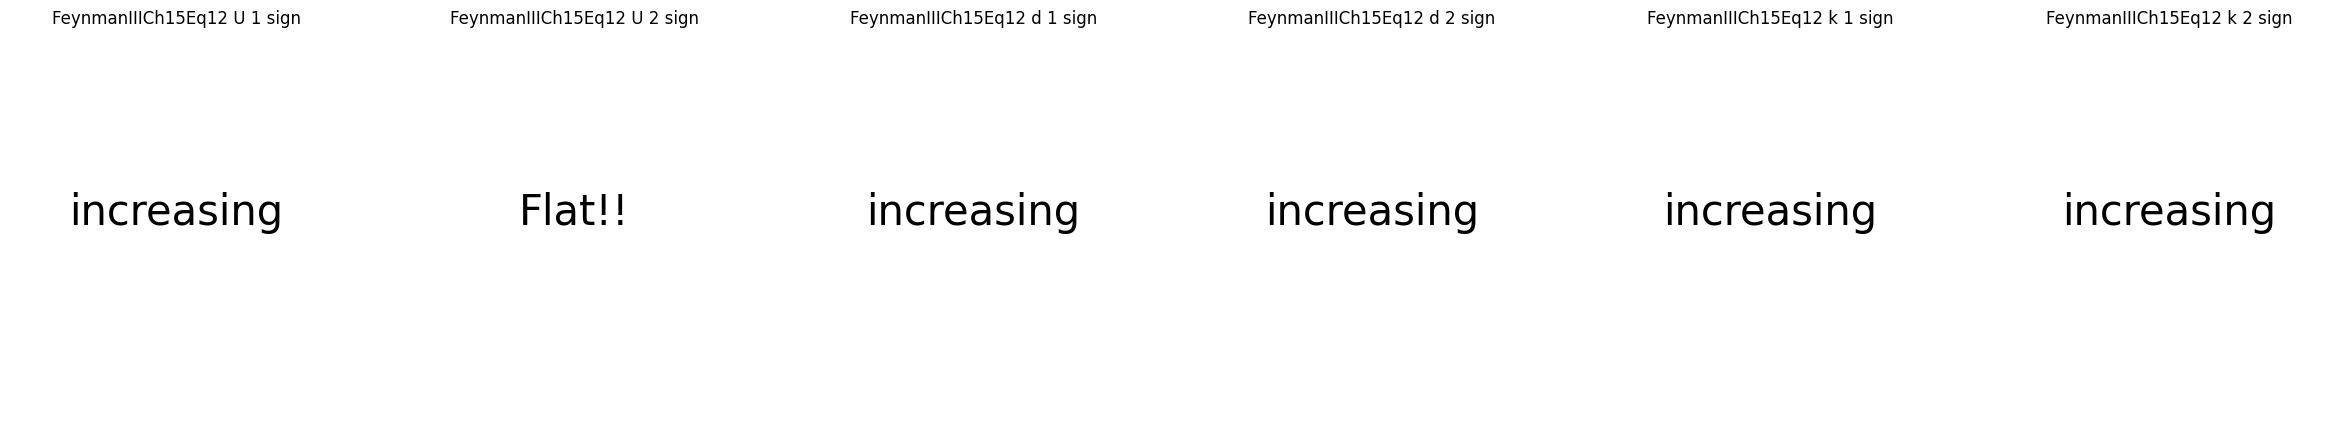

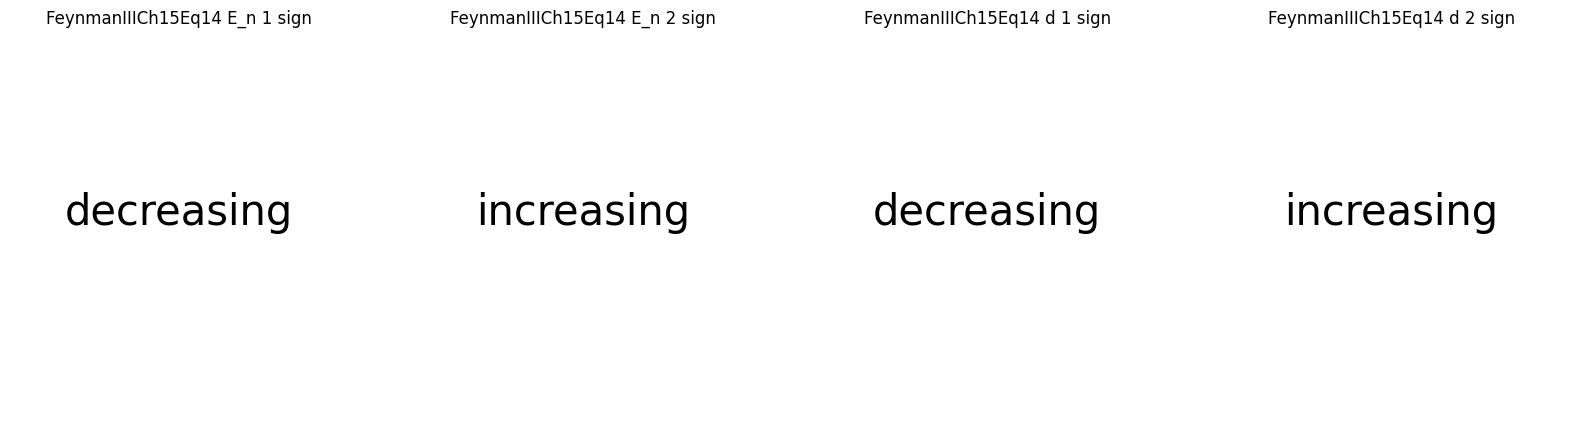

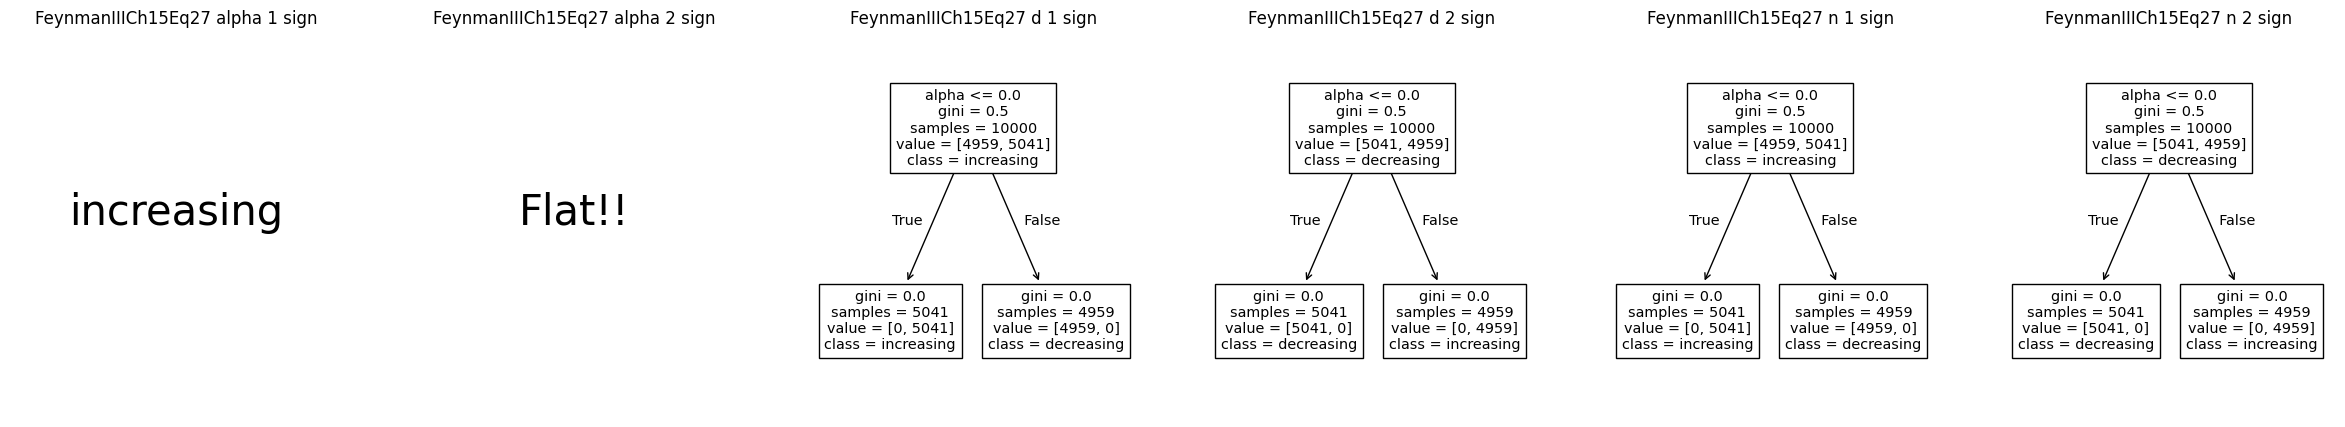

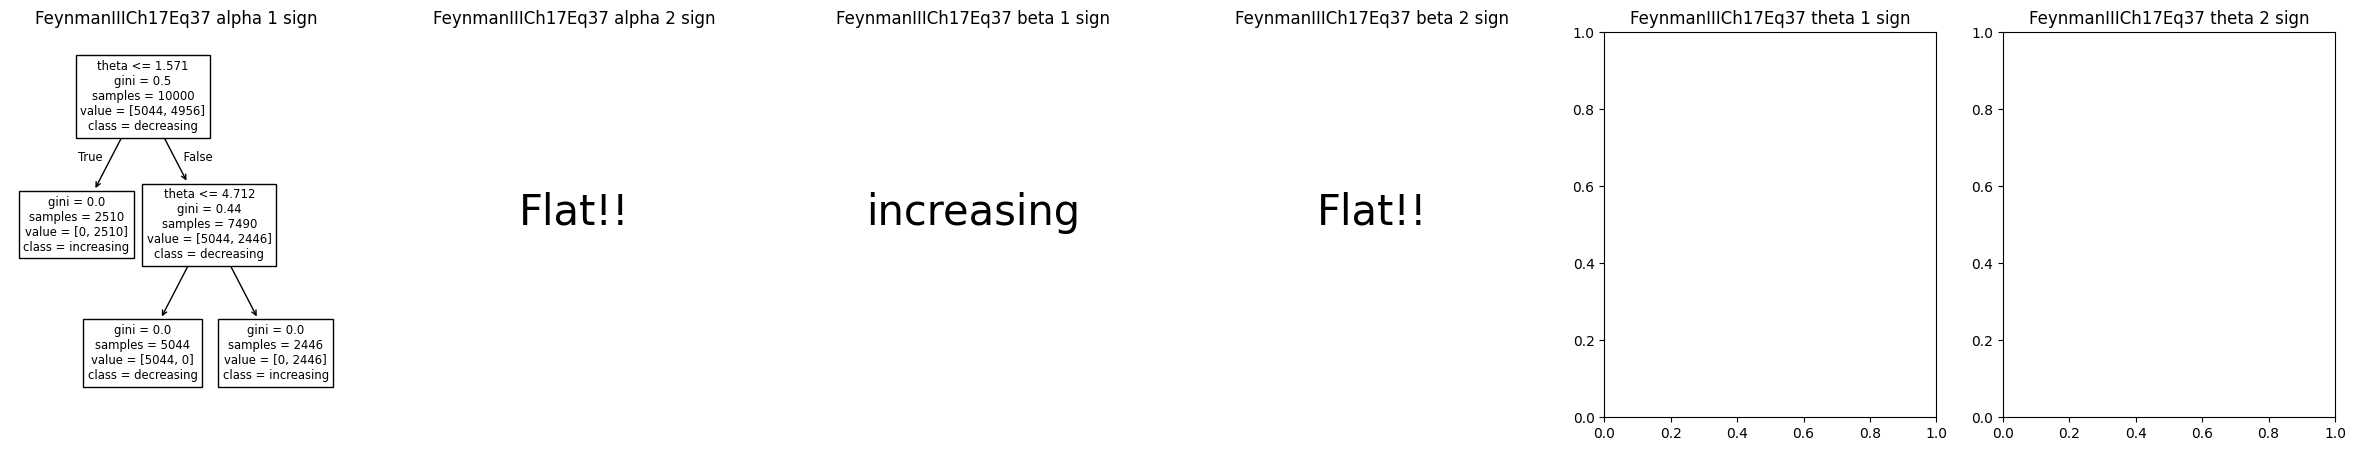

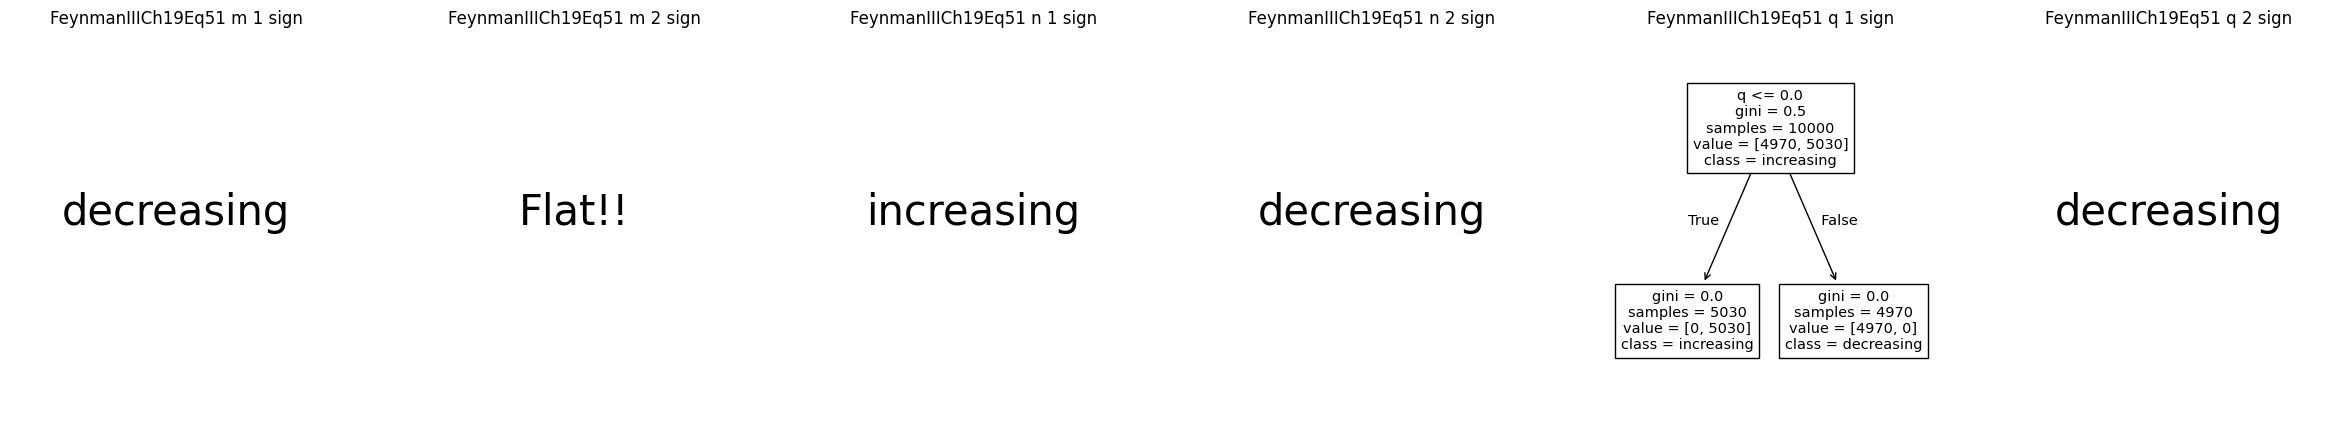

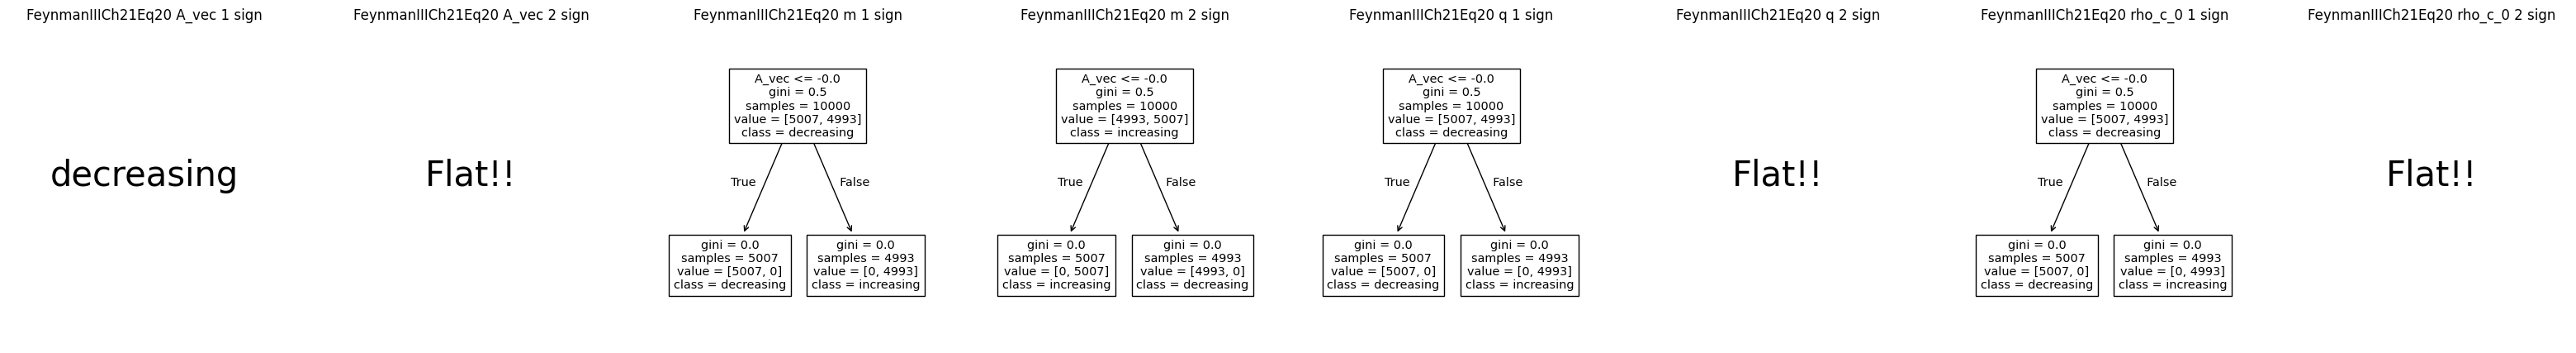

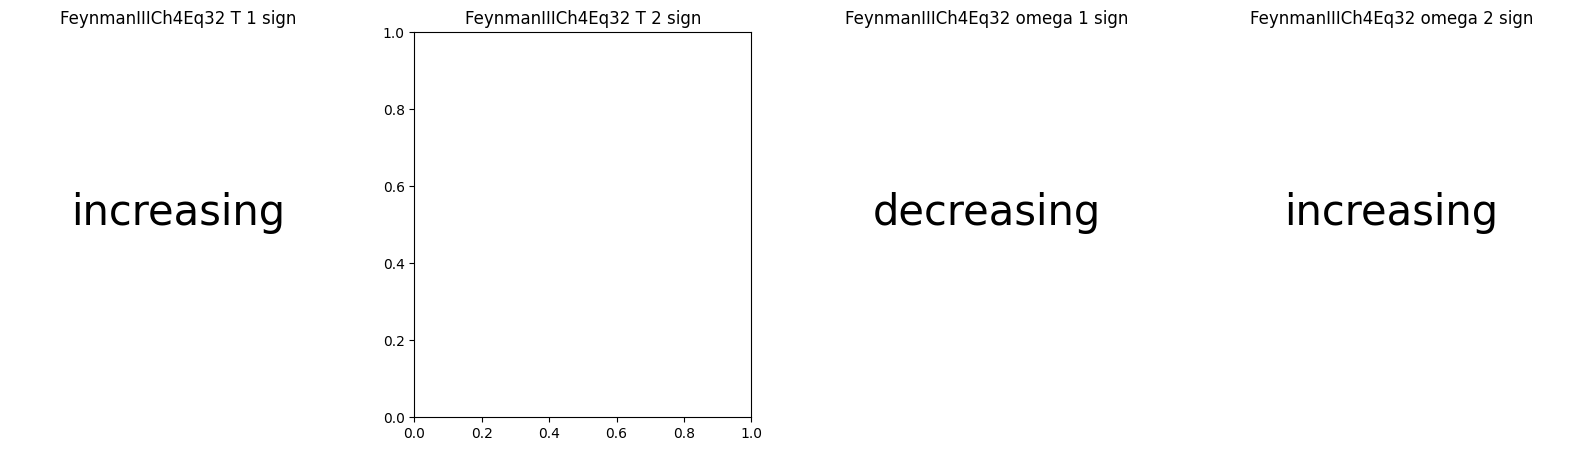

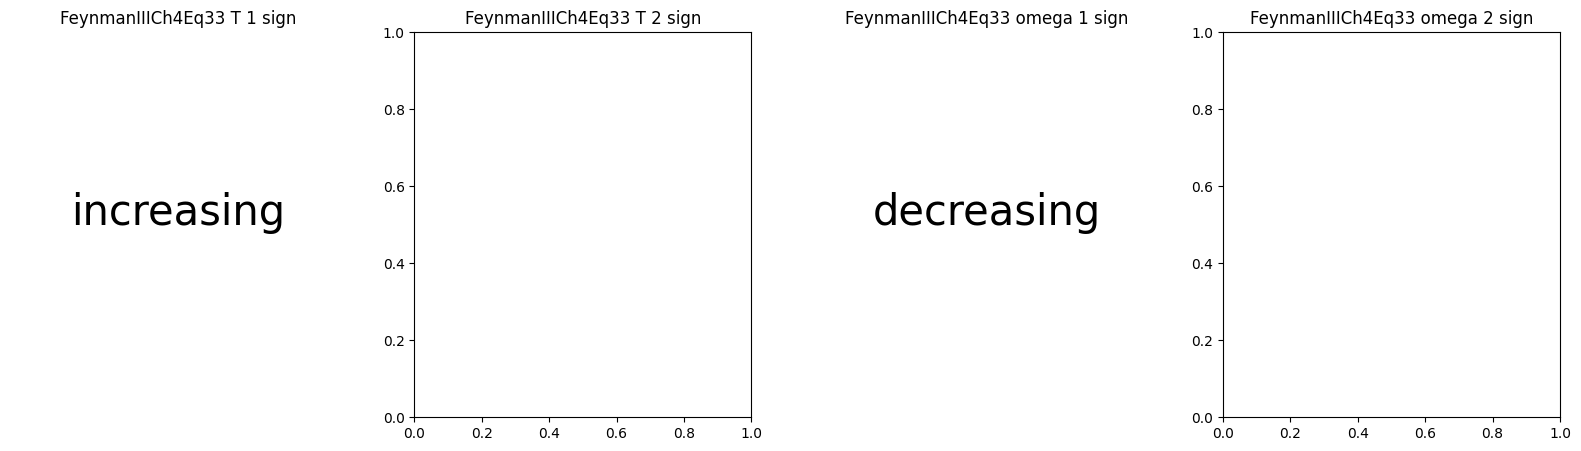

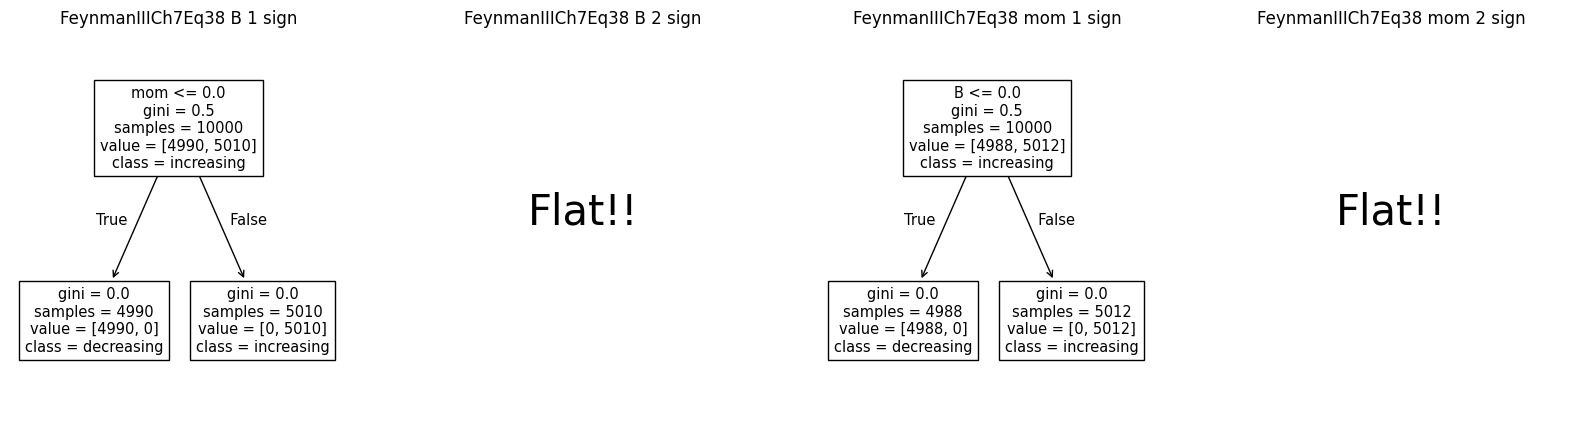

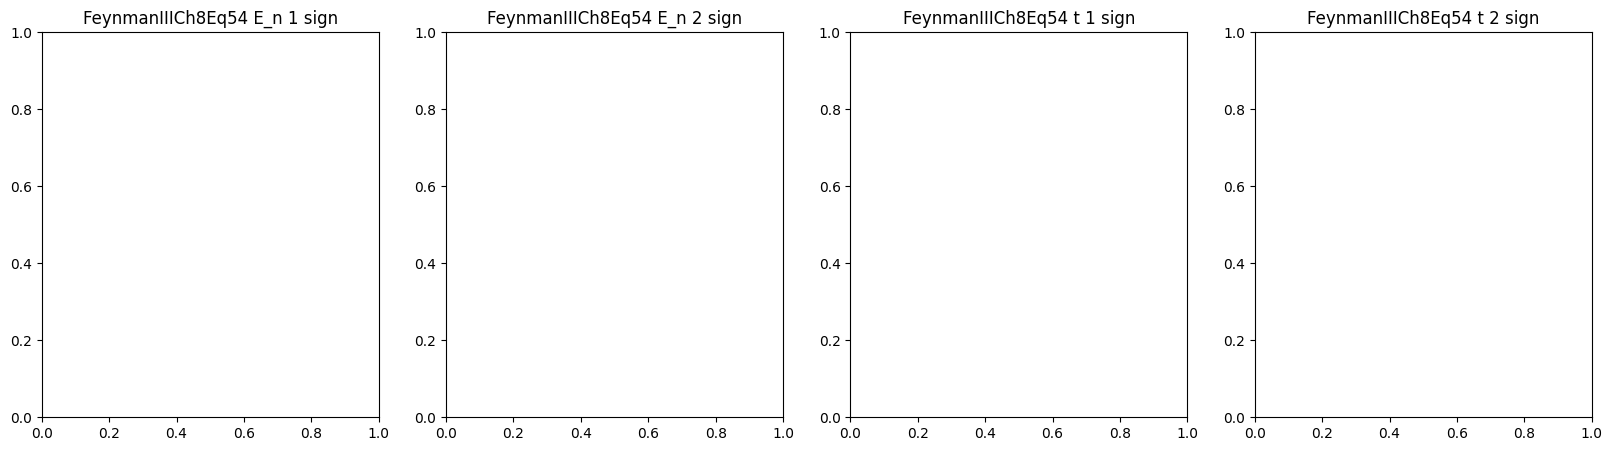

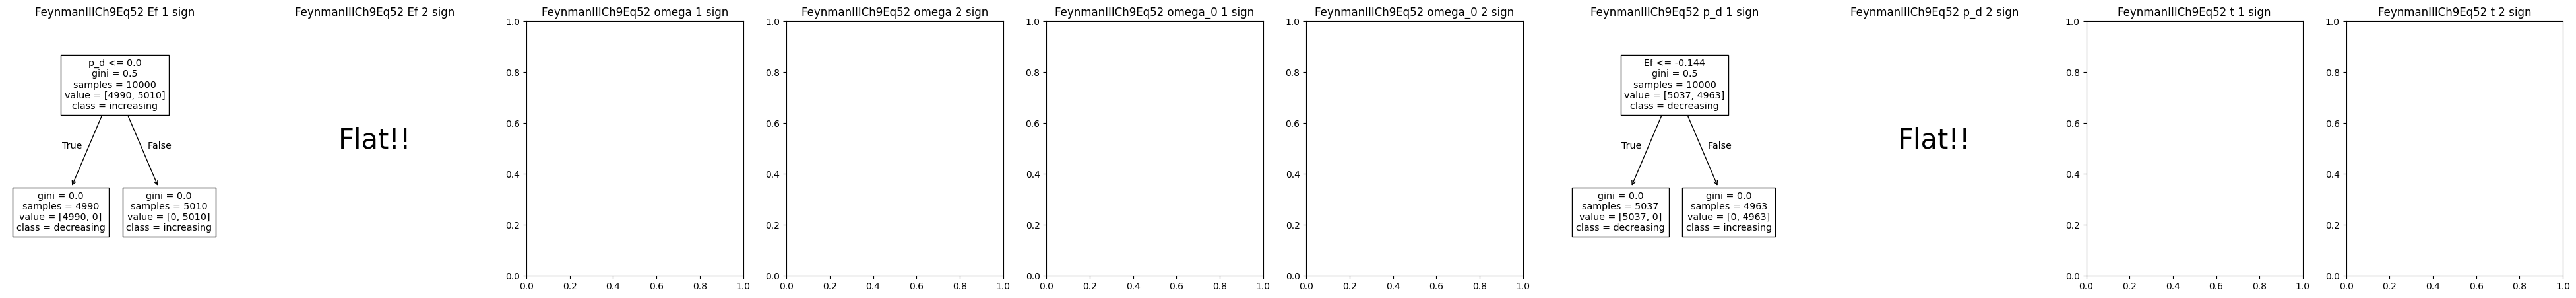

In [22]:
rows = len(res)
cols = max([len(res[x]) for x in res])
print(rows, cols)
i = 0
for n in tqdm(list(sorted(res))):
    j = 0
    cols = len(res[n])
    fig, axs = plt.subplots(1, cols, figsize = (5*cols, 5))
    for t in sorted(res[n]):
        ax = axs[j] if cols>1 else axs
        clt = res[n][t]
        match clt:
            case None:
                pass
            case 0:
                ax.text(0.5, 0.5, "Flat",  fontsize=30, horizontalalignment = "center")
                ax.set_axis_off()
            case 1:
                ax.text(0.5, 0.5, "Increasing",  fontsize=30, horizontalalignment = "center")
                ax.set_axis_off()
            case -1:
                ax.text(0.5, 0.5, "Decreasing", fontsize=30, horizontalalignment = "center")
                ax.set_axis_off()
            case _:
                tree.plot_tree(clt[0], class_names=["decreasing", "increasing"],feature_names=clt[1] ,ax = ax)
        ax.set_title(f'{n} {t}')
        
        j +=1
    i+=1
    #fig.savefig(f'{n}.pdf')

In [23]:
ranges = {i:(min(data[c]),max(data[c])) for i,c in enumerate(data.columns[0:3])}
to_constraint(clf=clf, node = 0, bounds=ranges)


[({0: (1002480567.2198744, 99995538503.70514),
   1: (1011782546.920047, 99996090005.7803),
   2: (0.0005640804581111725, np.float64(3.9272959232330322))},
  None),
 ({0: (1002480567.2198744, 99995538503.70514),
   1: (1011782546.920047, 99996090005.7803),
   2: (np.float64(3.9272959232330322), np.float64(5.498386859893799))},
  'monotonic increasing'),
 ({0: (1002480567.2198744, 99995538503.70514),
   1: (1011782546.920047, 99996090005.7803),
   2: (np.float64(5.498386859893799), 6.282727137169138)},
  'monotonic decreasing')]

In [24]:
for n in range(0,clf.tree_.node_count):
   print(clf.tree_.impurity[n], clf.tree_.children_left[n], clf.tree_.children_right[n], clf.tree_.threshold[n],clf.tree_.value[n][0], clf.tree_.feature[n])

0.49999662 1 4 5.498386859893799 [0.5013 0.4987] 2
0.4896785770865383 2 3 3.9272959232330322 [0.42816191 0.57183809] 2
0.4784037788211085 -1 -1 -2.0 [0.60391396 0.39608604] -2
0.0 -1 -1 -2.0 [0. 1.] -2
0.0 -1 -1 -2.0 [1. 0.] -2


[Text(0.6, 0.8333333333333334, 'x[2] <= 5.498\ngini = 0.5\nsamples = 10000\nvalue = [5013, 4987]'),
 Text(0.4, 0.5, 'x[2] <= 3.927\ngini = 0.49\nsamples = 8721\nvalue = [3734.0, 4987.0]'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'gini = 0.478\nsamples = 6183\nvalue = [3734.0, 2449.0]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 2538\nvalue = [0, 2538]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 1279\nvalue = [1279, 0]'),
 Text(0.7, 0.6666666666666667, '  False')]

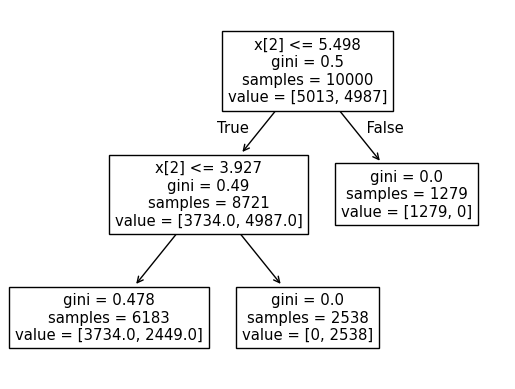

In [25]:
tree.plot_tree(clf)